In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid', {'axes.facecolor': '.9'})
#sns.set_palette(palette='deep')
#sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

from sklearn.model_selection import LeaveOneOut

In [73]:
from sklearn.cluster import SpectralClustering
from itertools import chain
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
# SKlearn metrics
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

In [3]:
# Tanimoto coefficient
def tanimoto(fingerprint1, fingerprint2):
    fp1 = int(fingerprint1, 16)
    fp2 = int(fingerprint2, 16)
    fp1_count = bin(fp1).count('1')
    fp2_count = bin(fp2).count('1')
    both_count = bin(fp1 & fp2).count('1')  
    
    if (fp1_count + fp2_count - both_count) != 0:
        return float(both_count)/(fp1_count + fp2_count - both_count)
    else:
        return float(0)

# Rogot-Goldberg index
def rogot_goldberg(fingerprint1, fingerprint2):
    sum1, sum2 = 0,0
    a,b,c,d = 0,0,0,0 
    for i in range(len(fingerprint1)):
        if fingerprint1[i] == "1" and fingerprint2[i] == "1":
            a += 1
            
        elif fingerprint1[i] == "1" and fingerprint2[i] == "0":
            b += 1
            
        elif fingerprint1[i] == "0" and fingerprint2[i] == "1":
            c += 1
           
        elif fingerprint1[i] == "0" and fingerprint2[i] == "0":
            d += 1
    try:
        sum1 = a/(2*a+b+c)
    except ZeroDivisionError:
        sum1 = 0 
        
    try:
        sum2 = d/(2*d+b+c)
    except ZeroDivisionError:
        sum2 = 0 

    return sum1+sum2

In [785]:
# Calculate similarity score and plot the histogram
def similarity_score_dist(df,fingerprint, method ="Tanimoto"):
    if method == "Tanimoto":
        Tani = []
        for i in range(df.shape[0]):
            #print("index i:", df.loc[i,"Name"])
            for j in range(i+1, df.shape[0]):
                #print("index j:", df.loc[j,"Name"])
                Tani.append(tanimoto(df.loc[i,fingerprint], df.loc[j,fingerprint]))
        return Tani
    
    if method == "Rogot-Goldberg":
        Tani = []
        for i in range(df.shape[0]):
            for j in range(i+1, df.shape[0]):
                Tani.append(rogot_goldberg(df.loc[i,fingerprint], df.loc[j,fingerprint]))
        return Tani
    else:
        print(f"Warning: Wrong method specified: {method}.")
    #return Tani

In [4]:
# Calculate similarity matrix using Tanimoto or Rogot-Goldberg
def similarity_matrix(df, similarity, fingerprint):
    list_len = df.shape[0]
    test_cid_1 = list(df['Name'])
    test_cid_1 = test_cid_1[0:list_len]
    test_cid_2 = test_cid_1
    
    df_cid = pd.DataFrame(0,index=test_cid_1,columns=test_cid_2)
    df_pair = pd.DataFrame(0,index=test_cid_1,columns=['Pair','MaxValue'])

    for i,cid_1 in enumerate(test_cid_1):
        #print(i)
        #if i%50 == 0:
        #    print(i*100/df.shape[0],'%')
        for j,cid_2 in enumerate(test_cid_2):
            #print(j)
            df_cid.loc[cid_1,cid_2] = similarity(df.loc[i,fingerprint], df.loc[j,fingerprint])
        tmpInd = df_cid.loc[cid_1,cid_1 != df_cid.columns].idxmax()
        tmpValue = df_cid.loc[cid_1,tmpInd]
        df_pair.loc[cid_1,'Pair'] = tmpInd
        df_pair.loc[cid_1,'MaxValue'] = tmpValue
    
    df_pair = df_pair.reset_index()
    
    return df_cid, df_pair

#### Load dataset of all predicted Ph-fp 

In [5]:
path = '/Users/hek/Research/Cheminformatics/Project_1_NPS/Stimulant vs. Hallucinogens/ChEMBL Dataset ML results/'

In [6]:
NPS_active = pd.read_csv(path+"Drugs Raman or SERS in literature _ Paper 1.csv",dtype="object")
NPS_active = NPS_active.astype({"Pharm class label": "float64"})
NPS_active = NPS_active.astype({"MCS_K": "float64"})
NPS_Compounds = NPS_active['Name']

In [7]:
NPS_active.head(1)

Name Other name    Formula     MW       CAS PubChem CID RotBondCount  \
0  Heroin        NaN  C21H23NO5  369.4  561-27-3     5462328            4   

  Conformers                                   Canonical SMILES  \
0        9.0  CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)...   

           Pharm class  ...  \
0  Depressants_Opioids  ...   

                                            morganfp  \
0  0000000000010001000000000000000001001000000000...   

                                           RF_morgan MCS_K  \
0  0000000000000000000000000000000000000000000000...   3.0   

                                        RF_p5_morgan  \
0  0000000000000000100000000000000000000001000110...   

                                        RF_p6_morgan  \
0  0000000000000000001000000000000000000001001110...   

                                        RF_p7_morgan  \
0  0000000000000100010000000000000000001000000000...   

                                         RF_p5_maccs  \
0  0000000000001011010101110000100010010101110111...   

                                         RF_p6_maccs  \
0  0000000000001010001010000000100000010001110111...   

                                         RF_p7_maccs  \
0  1000000000101000101100001000000110111000011000...   

                                              Mol_fp  
0  [27, 369.41700000000014, 369.15762283600003, 3...  

[1 rows x 27 columns]

### Histplot of similarity scores calculated using 
* Structural fingerprint and Tanimoto 
* Ph-fp and Rogot-Goldberg

In [784]:
MACCS = similarity_score_dist(NPS_active,"maccsfp")
MORGAN = similarity_score_dist(NPS_active,"morganfp")

index i: Heroin
index j: Morphine
index j: Acetylcodeine
index j: Codeine
index j: Hydrocodone
index j: Oxycodone
index j: Hydromorphone
index j: Oxymorphone
index j: Naltrexone
index j: Naloxone
index j: Buprenorphine
index j: Norbuprenorphine
index j: Fentanyl
index j: Butyrfentanyl
index j: Acetylfentanyl
index j: Alpha-Methylfentanyl
index j: Acrylfentanyl
index j: 4-MeO-butyrfentanyl
index j: Furanylfentanyl
index j: Carfentanil
index j: Remifentanil
index j: Methylphenidate
index j: IPH
index j: EPH
index j: PPH
index j: 4-MeTMP
index j: 4-FMPH
index j: HDMP-28
index j: HDEP-28
index j: 3,4-DCMP
index j: Amphetamine
index j: Methamphetamine
index j: Etilamfetamine
index j: 4-MA
index j: 4-FMA
index j: 4-FA
index j: 4-CA
index j: 4-CMA
index j: 4-MOA
index j: 4-MMA
index j: 4-MTA
index j: MDA
index j: MDMA
index j: MDEA
index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-M

index j: 4-FA
index j: 4-CA
index j: 4-CMA
index j: 4-MOA
index j: 4-MMA
index j: 4-MTA
index j: MDA
index j: MDMA
index j: MDEA
index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
ind

index j: Remifentanil
index j: Methylphenidate
index j: IPH
index j: EPH
index j: PPH
index j: 4-MeTMP
index j: 4-FMPH
index j: HDMP-28
index j: HDEP-28
index j: 3,4-DCMP
index j: Amphetamine
index j: Methamphetamine
index j: Etilamfetamine
index j: 4-MA
index j: 4-FMA
index j: 4-FA
index j: 4-CA
index j: 4-CMA
index j: 4-MOA
index j: 4-MMA
index j: 4-MTA
index j: MDA
index j: MDMA
index j: MDEA
index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index 

index j: Furanylfentanyl
index j: Carfentanil
index j: Remifentanil
index j: Methylphenidate
index j: IPH
index j: EPH
index j: PPH
index j: 4-MeTMP
index j: 4-FMPH
index j: HDMP-28
index j: HDEP-28
index j: 3,4-DCMP
index j: Amphetamine
index j: Methamphetamine
index j: Etilamfetamine
index j: 4-MA
index j: 4-FMA
index j: 4-FA
index j: 4-CA
index j: 4-CMA
index j: 4-MOA
index j: 4-MMA
index j: 4-MTA
index j: MDA
index j: MDMA
index j: MDEA
index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PV

index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-007
index j: JWH-018
index j: JWH-073
index j: JWH-081
index j: JWH-210
index j: AM-1220
index j: AM-2201
index j: MAM-2201
index j: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA
index j: UR-144
index j: XLR-11
index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
ind

index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3
index j: 2C-T-4
index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flu

index j: MDEA
index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210

index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-007
index j: JWH-018
index j: JWH-073
index j: JWH-081
index j: JWH-210
index j: AM-1220
index j: AM-2201
index j: MAM-2201
index j: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA


index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
index j: NBOMe-2C-D
index j: NBOMe-2C-E
index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3
index j: 2C-T-4
index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepa

index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-

index j: Etizolam
index i: 4-MTA
index j: MDA
index j: MDMA
index j: MDEA
index j: MBDB
index j: MDB
index j: Cathinone
index j: Methcathinone
index j: Ethcathinone
index j: Buphedrone
index j: Pentedrone
index j: Mephedrone
index j: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: D

index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3
index j: 2C-T-4
index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Py

index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: 3-MMC
index j: 4-MEC
index j: 3,4-DMMC
index j: 2,3-DMMC
index j: 2,4-DMMC
index j: Methedrone
index j: 4-FMC
index j: 3-FMC
index j: 4-EMC
index j: 4-CMC
index j: 3-CMC
index j: 4-BMC
index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrov

index j: BK-MDA
index j: Methylone
index j: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-007
index j: JWH-018
index j: JWH-073
index j: JWH-081
index j: JWH-210
index j: AM-1220
index j: AM-2201
index j: MAM-2201
index j: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA
index j: UR-144
index j: XLR-11
index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j

index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-007
index j: JWH-018
index j: JWH-073
index j: JWH-081
index j: JWH-210
index j: AM-1220
index j: AM-2201
index j: MAM-2201
index j: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA
index j: UR-144
index j: XLR-11
index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
i

index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: Butylone
index j: Ethylone
index j: Pentylone
index j: Ephylone
index j: MDPPP
index j: MDPV
index j: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5

index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: MDPBP
index j: Naphyrone
index j: Pyrovalerone
index j: Alpha PVP
index j: Alpha PPP
index j: Alpha PBP
index j: Alpha PHP
index j: 2-Aminoindane
index j: NM-2-AI
index j: MMAI
index j: MDAI
index j: 5-IAI
index j: 4-APB
index j: 5-APB
index j: 6-APB
index j: 7-APB
index j: 5-EAPB
index j: 6-EAPB
index j: 5-APDB
index j: 6-APDB
index j: 5-MAPDB
index j: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-007
index j

index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
index j: NBOMe-2C-D
index j: NBOMe-2C-E
index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3
index j: 2C-T-4
index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index 

index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
index j: NBOMe-2C-D
index j: NBOMe-2C-E
index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3
index j: 2C-T-4
index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j:

index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: 6-MAPDB
index j: THC
index j: D9THC
index j: D6THC
index j: Synhexyl
index j: DMHP
index j: Cannabidiol
index j: Cannabinol
index j: HU-210
index j: JWH-007
index j: JWH-018
index j: JWH-073
index j: JWH-081
index j: JWH-210
index j: AM-1220
index j: AM-2201
index j: MAM-2201
index j: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA
index j: UR-144
index j: XLR-11
index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B


index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: HU-210
index j: JWH-007
index j: JWH-018
index j: JWH-073
index j: JWH-081
index j: JWH-210
index j: AM-1220
index j: AM-2201
index j: MAM-2201
index j: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA
index j: UR-144
index j: XLR-11
index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
index j: NBOMe-2C-D
index j: NBOMe-2C-E
index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E


index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: PB-22
index j: 5F-PB-22
index j: MDMB-CHMICA
index j: MDMB-FUBICA
index j: UR-144
index j: XLR-11
index j: ADB-FUBINACA
index j: AB-FUBINACA
index j: AMB-FUBINACA
index j: AB-CHMINACA
index j: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
index j: NBOMe-2C-D
index j: NBOMe-2C-E
index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 

index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: MA-CHMINACA
index j: ADB-PINACA
index j: 5F-ADB
index j: NBOMe-2C-B
index j: NBOMe-2C-C
index j: NBOMe-2C-I
index j: NBOMe-2C-D
index j: NBOMe-2C-E
index j: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-

index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: NBOMe-2C-H
index j: NBOMe-2C-N
index j: NBOMe-2C-P
index j: NBOMe-mescaline
index j: 2C-O
index j: 2C-B
index j: DOB
index j: Bk-2C-B
index j: 2C-C
index j: DOC
index j: 2C-I
index j: DOI
index j: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3


index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: 2C-D
index j: DOM
index j: 2C-E
index j: 2C-H
index j: 2C-N
index j: 2C-P
index j: Mescaline
index j: 2C-T-2
index j: 2C-T
index j: 2C-T-3
index j: 2C-T-4
index j: 2C-T-7
index j: 2C-T-16
index j: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
in

index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: 2C-T-17
index j: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
index j: 2C-T-31
index j: 2C-T-33
index j: Psilocin
index j: DMT
index j: DET
index j: DiPT
index j: MiPT
index j: 4-HO-DiPT
index j: 4-HO-MET
index j: 4-HO-DET
index j: 4-HO-MiPT
index j: 5-MeO-AMT
index j: 5-MeO-MiPT
index j: 5-MeO-DMT
index j: 5-MeO-DiPT
index j: 5-MeO-DET
index j: Diazepam
index j: Temazepam
index j: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: 2C-T-19
index j: 2C-T-21
index j: 2C-T-25
index j: 2C-T-27
index j: 2C-T-28
index j: 2C-T-30
in

index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: Oxazepam
index j: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: Clobazam
index j: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: Nordazepam
index j: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: Fludiazepam
index j: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubromazolam
index j: Etizolam
index i: Flubromazepam
index j: Phenazepam
index j: Meclonazepam
index j: Clonazolam
index j: Pyrazolam
index j: Flubrom

In [779]:
print(np.median(MACCS))
print(np.median(MORGAN))

0.3508771929824561
0.13043478260869565


In [825]:
Ph_RF_p5_morgan = similarity_score_dist(NPS_active,"RF_p5_morgan", method = "Rogot-Goldberg")
Ph_RF_p5_maccs = similarity_score_dist(NPS_active,"RF_p5_maccs", method = "Rogot-Goldberg")
#Ph_MLP_maccs = similarity_score_dist(NPS_active,"Phfp_MLP_maccs", method = "Rogot-Goldberg")

In [778]:
print(np.median(Ph_RF_p5_maccs))
print(np.median(Ph_RF_p5_morgan))

0.5579658605974396
0.4830917874396135


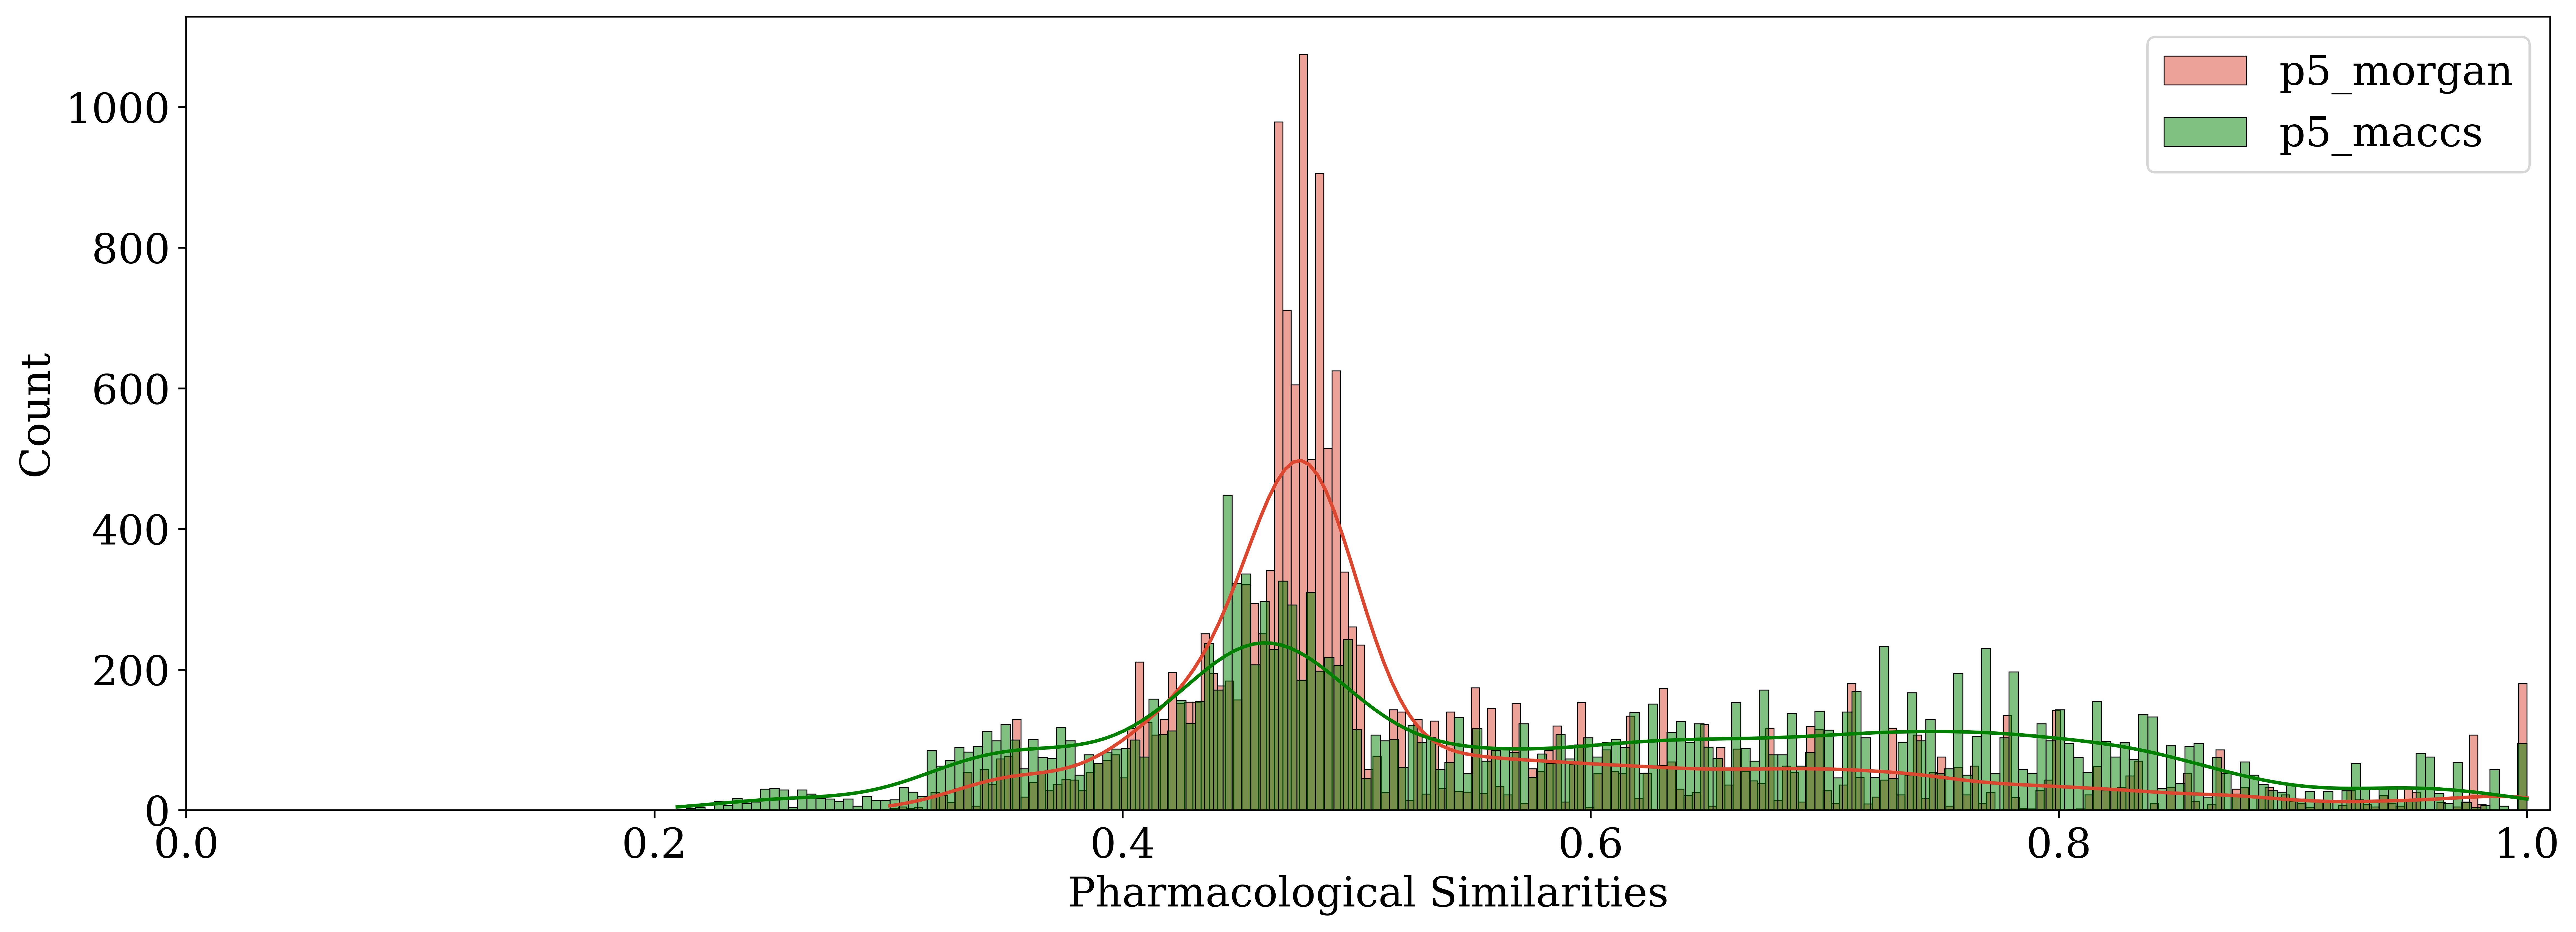

In [827]:
fig = plt.figure(figsize=(16,6), dpi = 600)
plt.rc('font', family='serif', size = 18)
#sns.histplot(MACCS, label = "MACCS" ,  kde=True,bins=200)
#sns.histplot(MORGAN, label = "Morgan" , kde=True,  color="darkorange",bins=200)
sns.histplot(Ph_RF_p5_morgan, label = "p5_morgan", kde=True, color="#DC4730",bins=200)
sns.histplot(Ph_RF_p5_maccs, label = "p5_maccs", kde=True, color="green",bins=200)
#plt.xlabel('Structural Similarities')
plt.xlabel('Pharmacological Similarities')
plt.xlim(0, 1.01)
legend = plt.legend(loc='upper right', shadow=False, fontsize=18)
fig.tight_layout()
plt.show()
fig.savefig(path+"Fig b. Structral and Pharmacological similarity histogram of NPS compounds.png",  bbox_inches='tight')

In [781]:
df_pair = pd.DataFrame()
index = 0
for i in range(0,NPS_active.shape[0]):
    #print(cid_list[i])
    for j in range(i+1,NPS_active.shape[0]):
        #print(index)
        #print(cid_list[i], cid_list[j])
        df_pair.loc[index,'Name_1'] = NPS_Compounds[i]
        df_pair.loc[index,'Name_2'] = NPS_Compounds[j]
        index += 1

In [788]:
df_pair['MACCS'] = similarity_score_dist(NPS_active,"maccsfp")
df_pair['Morgan'] = similarity_score_dist(NPS_active,"morganfp")
df_pair['p5_maccs'] = similarity_score_dist(NPS_active,"RF_p5_maccs", method = "Rogot-Goldberg")
df_pair['p6_maccs'] = similarity_score_dist(NPS_active,"RF_p6_maccs", method = "Rogot-Goldberg")
df_pair['p7_maccs'] = similarity_score_dist(NPS_active,"RF_p7_maccs", method = "Rogot-Goldberg")
df_pair['p5_morgan'] = similarity_score_dist(NPS_active,"RF_p5_morgan", method = "Rogot-Goldberg")
df_pair['p6_morgan'] = similarity_score_dist(NPS_active,"RF_p6_morgan", method = "Rogot-Goldberg")
df_pair['p7_morgan'] = similarity_score_dist(NPS_active,"RF_p7_morgan", method = "Rogot-Goldberg")

In [789]:
df_pair.describe()

MACCS        Morgan      p5_maccs      p6_maccs      p7_maccs  \
count  17766.000000  17766.000000  17766.000000  17766.000000  17766.000000   
mean       0.379173      0.163937      0.589080      0.582785      0.527272   
std        0.150604      0.116186      0.176113      0.171072      0.134020   
min        0.102041      0.029412      0.209790      0.228173      0.238806   
25%        0.275000      0.101449      0.449992      0.452736      0.450222   
50%        0.350877      0.130435      0.557966      0.548374      0.492537   
75%        0.441176      0.173077      0.734118      0.710457      0.597037   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

          p5_morgan     p6_morgan     p7_morgan  
count  17766.000000  17766.000000  17766.000000  
mean       0.537860      0.527605      0.522145  
std        0.138856      0.125700      0.126694  
min        0.300654      0.311688      0.315789  
25%        0.462312      0.467337      0.472081  
50%        0.483092      0.485437      0.485149  
75%        0.594038      0.558333      0.500000  
max        1.000000      1.000000      1.000000

In [790]:
df_pair.to_csv(path+"NPS vs. NPS all pair-wise similarity.csv",index=False)

#### Distribution of the similarit scores between Pharmacologically similar and unsimilar pairs

In [812]:
print("PF similar pairs",df_pair[df_pair['p5_morgan']>=0.594].shape[0])

PF similar pairs 4495


In [821]:
df_test = pd.DataFrame()

df_test['p5_morgan'] = [1 if i>=0.594 else 0 for i in df_pair['p5_morgan']]

df_test['Morgan'] = [str(math.floor(i)) + str(math.ceil(i)+1) if math.floor(i)== math.ceil(i) else str(math.floor(i)) + str(math.ceil(i)) for i in df_pair['Morgan']*10]

In [822]:
df_a = df_test.groupby('Morgan').count()
df_a.head()

df_a.index.names=['index']
df_a = df_a.rename(columns={'p5_morgan':'Morgan'})
df_a.head()

Morgan
index        
01       4165
1011        1
12      10321
23       1721
34        583

In [823]:
df_b = df_test.groupby('Morgan')['p5_morgan'].sum()

df_a['p5_morgan'] = df_b.values

In [824]:
df_a

Morgan  p5_morgan
index                   
01       4165        384
1011        1          1
12      10321       2295
23       1721        695
34        583        405
45        314        203
56        300        223
67        240        184
78        105         90
89         14         13
910         2          2

### Hierarchical clustering and silhouette analysis

In [11]:
def form_likage(df, method):
    X = df.values
    Z = linkage(X, method=method)
    return X, Z

# if fingerprint = ["maccsfp","morganfp"], then df_cid, df_pair is calculate using similarity coefficient, then subject to hierarchical clustering
# if fingerprint = "Mol_fp", then 
def hierarchical_clustering(df, similarity,fingerprint, method):
    df_cid, df_pair = similarity_matrix(df,similarity,fingerprint)
    df_X, df_Z = form_likage(df_cid, method)
    
    # Cluster label according to maximum common core, form 17 clusters
    MCS_labels_pred = fcluster(df_Z, 17, criterion='maxclust')
    ARI_MCS = adjusted_rand_score(df['MCS_K'], MCS_labels_pred) 
    NMI_MCS = adjusted_mutual_info_score(df['MCS_K'], MCS_labels_pred)
    sil_MCS = silhouette_score(df_X, MCS_labels_pred, metric='euclidean')
    print("Cluster label predicted according to maximum common substructure cluster: K = 17")
    print("ARI %0.3f" %ARI_MCS, ", NMI: %0.3f" % NMI_MCS, ", Silhouette: %0.3f" %sil_MCS)
    
    # Cluster label according to pharmacological categorization, form 4 clusters
    Ph_labels_pred = fcluster(df_Z, 5, criterion='maxclust')
    ARI_Ph = adjusted_rand_score(df['Pharm class label'], Ph_labels_pred) 
    NMI_Ph = adjusted_mutual_info_score(df['Pharm class label'], Ph_labels_pred)
    sil_Ph = silhouette_score(df_X, Ph_labels_pred, metric='euclidean')
    print("Cluster label predicted according to pharmacological categorization: K = 5")
    print("ARI %0.3f" %ARI_Ph, ", NMI: %0.3f" % NMI_Ph, ", Silhouette: %0.3f" %sil_Ph)
    
    return ARI_MCS, NMI_MCS, sil_MCS, ARI_Ph, NMI_Ph, sil_Ph

def sil_K_plot(ylabel, K, value, label):
    fig = plt.figure(figsize=(12,4), dpi = 300)
    plt.rc('font', family='serif')
    plt.scatter(K, value,label=label)
    plt.legend()
    legend = plt.legend(loc='lower right', shadow=True, fontsize=16)
    plt.xticks(np.arange(2,21,step=1))
    plt.xlabel("Number of clusters K", fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.show()
    #return fig

def cluster_metric(X, Z, class_label_true):
    labels_pred = fcluster()
    silhouette = silhouette_score(X, opt_num_cluster, metric='euclidean')
    ARI = adjusted_rand_score(class_label_true, opt_num_cluster)
    NMI = adjusted_mutual_info_score(class_label_true, opt_num_cluster)
    print('ARI: %.4f'%ARI,'silhouette: %.4f'%silhouette, 'NMI : %.4f'% NMI)

### Parameterization 
#### Try different linkage methods:
* "ward"
* "complete"
* "average"
* "single"

#### Evaluate clustering performance using ARI and NMI according to true labels:
* MCS_K = 17
* Ph_K = 5

In [10]:
NPS_active.head(1)

Name Other name    Formula     MW       CAS PubChem CID RotBondCount  \
0  Heroin        NaN  C21H23NO5  369.4  561-27-3     5462328            4   

  Conformers                                   Canonical SMILES  \
0        9.0  CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)OC(=O)C)...   

           Pharm class  ...  \
0  Depressants_Opioids  ...   

                                            morganfp  \
0  0000000000010001000000000000000001001000000000...   

                                           RF_morgan MCS_K  \
0  0000000000000000000000000000000000000000000000...   3.0   

                                        RF_p5_morgan  \
0  0000000000000000100000000000000000000001000110...   

                                        RF_p6_morgan  \
0  0000000000000000001000000000000000000001001110...   

                                        RF_p7_morgan  \
0  0000000000000100010000000000000000001000000000...   

                                         RF_p5_maccs  \
0  0000000000001011010101110000100010010101110111...   

                                         RF_p6_maccs  \
0  0000000000001010001010000000100000010001110111...   

                                         RF_p7_maccs  \
0  1000000000101000101100001000000110111000011000...   

                                              Mol_fp  
0  [27, 369.41700000000014, 369.15762283600003, 3...  

[1 rows x 27 columns]

In [13]:
fingerprint = "maccsfp"
method = "single"
ARI_MCS_total, NMI_MCS_total, sil_MCS_total, ARI_Ph_total, NMI_Ph_total, sil_Ph_total = [],[],[],[],[],[]
LOO = LeaveOneOut()
for train_index, test_index in LOO.split(NPS_active):
    print("Leave", test_index, "out")
    NPS_train, NPS_test = NPS_active.iloc[train_index], NPS_active.iloc[test_index]
    print(NPS_train.shape[0])
    NPS_train.reset_index(drop=True, inplace=True)
    ARI_MCS, NMI_MCS, sil_MCS, ARI_Ph, NMI_Ph, sil_Ph = hierarchical_clustering(NPS_train, tanimoto, fingerprint, method)
    
    ARI_MCS_total.append(ARI_MCS) 
    NMI_MCS_total.append(NMI_MCS)
    sil_MCS_total.append(sil_MCS)
    ARI_Ph_total.append(ARI_Ph)
    NMI_Ph_total.append(NMI_Ph)
    sil_Ph_total.append(sil_Ph)
    print("*"*10)

print("ARI MCS cluster label average %0.3f" %(np.mean(ARI_MCS_total)),"std %0.3f" %(np.std(ARI_MCS_total)))
print("NMI MCS cluster labelaverage %0.3f" %(np.mean(NMI_MCS_total)), "std %0.3f" %(np.std(NMI_MCS_total)))
print("Silhouettee MCS cluster label average %0.3f" %(np.mean(sil_MCS_total)), "std %0.3f" %(np.std(sil_MCS_total)))
print("ARI Pharmacological cluster label average %0.3f" %(np.mean(ARI_Ph_total)), "std %0.3f" %(np.std(ARI_Ph_total)))
print("NMI Pharmacological cluster label average %0.3f" %(np.mean(NMI_Ph_total)),"std %0.3f" %(np.std(NMI_Ph_total)))
print("Silhouettee Pharmacological cluster label average %0.3f" %(np.mean(sil_Ph_total)),"std %0.3f" %(np.std(sil_Ph_total)))

Leave [0] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.448 , NMI: 0.687 , Silhouette: 0.329
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.177 , NMI: 0.401 , Silhouette: 0.210
**********
Leave [1] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.448 , NMI: 0.687 , Silhouette: 0.328
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.177 , NMI: 0.401 , Silhouette: 0.210
**********
Leave [2] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.448 , NMI: 0.687 , Silhouette: 0.329
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.177 , NMI: 0.401 , Silhouette: 0.210
**********
Leave [3] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.465 , NMI: 0.690 , Silhouette: 0.333
Cluster label predicted according to pharmaco

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.452 , NMI: 0.689 , Silhouette: 0.332
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.178 , NMI: 0.403 , Silhouette: 0.211
**********
Leave [32] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.550 , NMI: 0.733 , Silhouette: 0.370
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.178 , NMI: 0.403 , Silhouette: 0.212
**********
Leave [33] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.452 , NMI: 0.689 , Silhouette: 0.330
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.178 , NMI: 0.403 , Silhouette: 0.211
**********
Leave [34] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.452 , NMI: 0.689 , Silhouette: 0.331
Cluster label predicted according to pharmacological categor

KeyboardInterrupt: 

In [690]:
fingerprint = "RF_p7_maccs"
method = "single"
ARI_MCS_total, NMI_MCS_total, sil_MCS_total, ARI_Ph_total, NMI_Ph_total, sil_Ph_total = [],[],[],[],[],[]
for train_index, test_index in LOO.split(NPS_active):
    print("Leave", test_index, "out")
    NPS_train, NPS_test = NPS_active.iloc[train_index], NPS_active.iloc[test_index]
    print(NPS_train.shape[0])
    NPS_train.reset_index(drop=True, inplace=True)
    ARI_MCS, NMI_MCS, sil_MCS, ARI_Ph, NMI_Ph, sil_Ph = hierarchical_clustering(NPS_train, rogot_goldberg, fingerprint, method)
    
    ARI_MCS_total.append(ARI_MCS) 
    NMI_MCS_total.append(NMI_MCS)
    sil_MCS_total.append(sil_MCS)
    ARI_Ph_total.append(ARI_Ph)
    NMI_Ph_total.append(NMI_Ph)
    sil_Ph_total.append(sil_Ph)
    print("*"*10)

print("ARI MCS cluster label average %0.3f" %(np.mean(ARI_MCS_total)),"std %0.3f" %(np.std(ARI_MCS_total)))
print("NMI MCS cluster labelaverage %0.3f" %(np.mean(NMI_MCS_total)), "std %0.3f" %(np.std(NMI_MCS_total)))
print("Silhouettee MCS cluster label average %0.3f" %(np.mean(sil_MCS_total)), "std %0.3f" %(np.std(sil_MCS_total)))
print("ARI Pharmacological cluster label average %0.3f" %(np.mean(ARI_Ph_total)), "std %0.3f" %(np.std(ARI_Ph_total)))
print("NMI Pharmacological cluster label average %0.3f" %(np.mean(NMI_Ph_total)),"std %0.3f" %(np.std(NMI_Ph_total)))
print("Silhouettee Pharmacological cluster label average %0.3f" %(np.mean(sil_Ph_total)),"std %0.3f" %(np.std(sil_Ph_total)))

Leave [0] out
188
Cophenetic coefficient: 0.793
maximum average silhouette score
    n_clusters  average_silouette
37          39            0.58302
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.387 , NMI: 0.609 , Silhouette: 0.430
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.211 , NMI: 0.355 , Silhouette: 0.346
**********
Leave [1] out
188
Cophenetic coefficient: 0.795
maximum average silhouette score
    n_clusters  average_silouette
63          65            0.57877
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.293 , NMI: 0.544 , Silhouette: 0.334
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.211 , NMI: 0.355 , Silhouette: 0.344
**********
Leave [2] out
188
Cophenetic coefficient: 0.785
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.580977
Cluster label predicted according to maximum co

Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576755
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.298 , NMI: 0.547 , Silhouette: 0.337
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.360 , Silhouette: 0.345
**********
Leave [22] out
188
Cophenetic coefficient: 0.793
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.578686
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.298 , NMI: 0.547 , Silhouette: 0.339
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.360 , Silhouette: 0.347
**********
Leave [23] out
188
Cophenetic coefficient: 0.793
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.578686
Cluster label predicted according to maximum common substructur

Cophenetic coefficient: 0.793
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576256
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.294 , NMI: 0.547 , Silhouette: 0.337
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.360 , Silhouette: 0.347
**********
Leave [43] out
188
Cophenetic coefficient: 0.788
maximum average silhouette score
    n_clusters  average_silouette
37          39           0.587539
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.302 , NMI: 0.551 , Silhouette: 0.338
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.360 , Silhouette: 0.344
**********
Leave [44] out
188
Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.570858
Cluster label predicted according to maximum common substructur

Cophenetic coefficient: 0.791
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576031
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.296 , NMI: 0.547 , Silhouette: 0.333
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.218 , NMI: 0.361 , Silhouette: 0.342
**********
Leave [64] out
188
Cophenetic coefficient: 0.791
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576031
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.300 , NMI: 0.551 , Silhouette: 0.333
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.218 , NMI: 0.361 , Silhouette: 0.342
**********
Leave [65] out
188
Cophenetic coefficient: 0.791
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576031
Cluster label predicted according to maximum common substructur

Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.577097
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.294 , NMI: 0.547 , Silhouette: 0.337
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.360 , Silhouette: 0.345
**********
Leave [85] out
188
Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.577097
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.294 , NMI: 0.547 , Silhouette: 0.337
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.360 , Silhouette: 0.345
**********
Leave [86] out
188
Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.577097
Cluster label predicted according to maximum common substructur

188
Cophenetic coefficient: 0.791
maximum average silhouette score
    n_clusters  average_silouette
39          41           0.587468
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.299 , NMI: 0.548 , Silhouette: 0.338
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.220 , NMI: 0.362 , Silhouette: 0.347
**********
Leave [106] out
188
Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
45          47           0.583115
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.299 , NMI: 0.548 , Silhouette: 0.340
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.220 , NMI: 0.362 , Silhouette: 0.347
**********
Leave [107] out
188
Cophenetic coefficient: 0.789
maximum average silhouette score
    n_clusters  average_silouette
39          41           0.581105
Cluster label predicted according to maximum common subst

Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.181 , NMI: 0.276 , Silhouette: 0.248
**********
Leave [126] out
188
Cophenetic coefficient: 0.789
maximum average silhouette score
    n_clusters  average_silouette
38          40            0.57665
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.293 , NMI: 0.544 , Silhouette: 0.332
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.181 , NMI: 0.276 , Silhouette: 0.248
**********
Leave [127] out
188
Cophenetic coefficient: 0.790
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576641
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.293 , NMI: 0.544 , Silhouette: 0.332
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.181 , NMI: 0.276 , Silhouette: 0.248
**********
Leave [128] out
188
Cophenetic coefficient: 0.789
maximum avera

Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.580031
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.293 , NMI: 0.547 , Silhouette: 0.340
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.216 , NMI: 0.360 , Silhouette: 0.344
**********
Leave [147] out
188
Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40            0.57671
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.293 , NMI: 0.547 , Silhouette: 0.337
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.216 , NMI: 0.360 , Silhouette: 0.345
**********
Leave [148] out
188
Cophenetic coefficient: 0.792
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.576982
Cluster label predicted according to maximum common substruct

Cophenetic coefficient: 0.793
maximum average silhouette score
    n_clusters  average_silouette
37          39           0.582307
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.301 , NMI: 0.551 , Silhouette: 0.342
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.181 , NMI: 0.276 , Silhouette: 0.251
**********
Leave [168] out
188
Cophenetic coefficient: 0.786
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.578778
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.293 , NMI: 0.544 , Silhouette: 0.335
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.214 , NMI: 0.357 , Silhouette: 0.343
**********
Leave [169] out
188
Cophenetic coefficient: 0.788
maximum average silhouette score
    n_clusters  average_silouette
38          40           0.578506
Cluster label predicted according to maximum common substruct

Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.213 , NMI: 0.357 , Silhouette: 0.347
**********
Leave [188] out
188
Cophenetic coefficient: 0.793
maximum average silhouette score
    n_clusters  average_silouette
61          63           0.581455
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.296 , NMI: 0.546 , Silhouette: 0.338
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.213 , NMI: 0.357 , Silhouette: 0.347
**********
ARI MCS cluster label average 0.298 std 0.015
NMI MCS cluster labelaverage 0.549 std 0.010
Silhouettee MCS cluster label average 0.339 std 0.019
ARI Pharmacological cluster label average 0.214 std 0.006
NMI Pharmacological cluster label average 0.357 std 0.015
Silhouettee Pharmacological cluster label average 0.342 std 0.017


### Final evaluation of hierarchical by varying K
* MACCS
* Morgan
* Ph-fp 
* Mol_fp

In [940]:
#df_result = pd.DataFrame()
#df_result['K'] = np.arange(2, 21,step=1)
#df_result.head()

In [47]:
# Final clustering evaluation by varying K
df_result = pd.read_csv(path+"Clustering performance by varying requested K, evaluated by K=Pharm.csv")
# NPS compounds described by Mol_fp
df_Mol_fp= pd.read_csv(path+"Drugs Mol_fp _ Paper 1.csv")

In [79]:
def spearman_COR(spec1,spec2):
    scorr, _ = spearmanr(spec1,spec2)
    return scorr
def Spearman_matrix(df,i0):
    COR_spearman= pd.DataFrame()
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            COR_spearman.loc[i,j] =spearman_COR(df.iloc[i,i0:],df.iloc[j,i0:])
    return COR_spearman

In [80]:
df_Mol_fp_cid = Spearman_matrix(df_Mol_fp,0)

/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [81]:
df_Mol_fp_cid

0         1         2         3         4         5         6    \
0    1.000000  0.883315  0.958341  0.890635  0.925169  0.877766  0.909692   
1    0.883315  1.000000  0.893903  0.977923  0.877549  0.884695  0.926208   
2    0.958341  0.893903  1.000000  0.933176  0.968811  0.893250  0.922446   
3    0.890635  0.977923  0.933176  1.000000  0.912963  0.911065  0.908313   
4    0.925169  0.877549  0.968811  0.912963  1.000000  0.926657  0.958316   
..        ...       ...       ...       ...       ...       ...       ...   
184  0.660854  0.652386  0.666865  0.656153  0.658682  0.680181  0.663782   
185  0.696120  0.692068  0.708043  0.699542  0.693757  0.685453  0.701307   
186  0.651031  0.649210  0.694304  0.675368  0.679540  0.642183  0.672857   
187  0.705780  0.714761  0.740120  0.724784  0.720751  0.675691  0.725029   
188  0.652928  0.651250  0.691000  0.669793  0.666285  0.621341  0.663835   

          7         8         9    ...       179       180       181  \
0    0.843580  0.879501  0.844017  ...  0.656469  0.657708  0.664270   
1    0.879916  0.898808  0.865115  ...  0.613823  0.651850  0.626303   
2    0.845082  0.879502  0.839970  ...  0.684844  0.698917  0.705882   
3    0.878765  0.899846  0.867317  ...  0.628778  0.669254  0.651931   
4    0.883295  0.914261  0.869423  ...  0.671664  0.679889  0.689800   
..        ...       ...       ...  ...       ...       ...       ...   
184  0.656228  0.712358  0.674349  ...  0.881625  0.843534  0.894743   
185  0.678055  0.724277  0.718588  ...  0.757033  0.770487  0.746318   
186  0.642725  0.650467  0.686672  ...  0.637020  0.721182  0.632333   
187  0.670279  0.704723  0.708474  ...  0.696841  0.738088  0.735779   
188  0.607466  0.635139  0.658452  ...  0.661907  0.729873  0.652329   

          182       183       184       185       186       187       188  
0    0.687757  0.679335  0.660854  0.696120  0.651031  0.705780  0.652928  
1    0.682617  0.638802  0.652386  0.692068  0.649210  0.714761  0.651250  
2    0.729039  0.689368  0.666865  0.708043  0.694304  0.740120  0.691000  
3    0.696115  0.658460  0.656153  0.699542  0.675368  0.724784  0.669793  
4    0.707899  0.667923  0.658682  0.693757  0.679540  0.720751  0.666285  
..        ...       ...       ...       ...       ...       ...       ...  
184  0.852705  0.811072  1.000000  0.837672  0.666393  0.725252  0.693258  
185  0.771282  0.754696  0.837672  1.000000  0.900609  0.925943  0.916964  
186  0.696668  0.720440  0.666393  0.900609  1.000000  0.912639  0.969943  
187  0.824016  0.736363  0.725252  0.925943  0.912639  1.000000  0.901210  
188  0.680775  0.722705  0.693258  0.916964  0.969943  0.901210  1.000000  

[189 rows x 189 columns]

In [82]:
for i in range(df_result.shape[0]):
    K = i+2
    print("Requested number of clusters", K)
    
    LOO = LeaveOneOut()
    ARI_K_total, NMI_K_total, sil_K_total = [],[],[]
    for train_index, test_index in LOO.split(NPS_active):
        print("Leave", test_index, "out")
        Mol_fp_train, NPS_Pharm_label= df_Mol_fp_cid.iloc[train_index], NPS_active.iloc[train_index]

        X = Mol_fp_train.values
        Z = linkage(X, method="ward")
        cluster_nodes = fcluster(Z,K,criterion="maxclust")
        ARI = adjusted_rand_score(NPS_Pharm_label['Pharm class label'], cluster_nodes) 
        NMI = adjusted_mutual_info_score(NPS_Pharm_label['Pharm class label'], cluster_nodes)
        sil = silhouette_score(X,cluster_nodes,metric="euclidean")
    
        ARI_K_total.append(ARI)
        NMI_K_total.append(NMI)
        sil_K_total.append(sil)
    df_result.loc[i,"Hier_"+"Mol_fp"+"_ARI"]=np.mean(ARI_K_total)
    df_result.loc[i,"Hier_"+"Mol_fp"+"_NMI"]=np.mean(NMI_K_total)
    df_result.loc[i,"Hier_"+"Mol_fp"+"_Sil"]=np.mean(sil_K_total)

Requested number of clusters 2
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leav

Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 5
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] o

Leave [130] out
Leave [131] out
Leave [132] out
Leave [133] out
Leave [134] out
Leave [135] out
Leave [136] out
Leave [137] out
Leave [138] out
Leave [139] out
Leave [140] out
Leave [141] out
Leave [142] out
Leave [143] out
Leave [144] out
Leave [145] out
Leave [146] out
Leave [147] out
Leave [148] out
Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 8
Leave [0] out
Leave [1] o

Leave [105] out
Leave [106] out
Leave [107] out
Leave [108] out
Leave [109] out
Leave [110] out
Leave [111] out
Leave [112] out
Leave [113] out
Leave [114] out
Leave [115] out
Leave [116] out
Leave [117] out
Leave [118] out
Leave [119] out
Leave [120] out
Leave [121] out
Leave [122] out
Leave [123] out
Leave [124] out
Leave [125] out
Leave [126] out
Leave [127] out
Leave [128] out
Leave [129] out
Leave [130] out
Leave [131] out
Leave [132] out
Leave [133] out
Leave [134] out
Leave [135] out
Leave [136] out
Leave [137] out
Leave [138] out
Leave [139] out
Leave [140] out
Leave [141] out
Leave [142] out
Leave [143] out
Leave [144] out
Leave [145] out
Leave [146] out
Leave [147] out
Leave [148] out
Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [1

Leave [70] out
Leave [71] out
Leave [72] out
Leave [73] out
Leave [74] out
Leave [75] out
Leave [76] out
Leave [77] out
Leave [78] out
Leave [79] out
Leave [80] out
Leave [81] out
Leave [82] out
Leave [83] out
Leave [84] out
Leave [85] out
Leave [86] out
Leave [87] out
Leave [88] out
Leave [89] out
Leave [90] out
Leave [91] out
Leave [92] out
Leave [93] out
Leave [94] out
Leave [95] out
Leave [96] out
Leave [97] out
Leave [98] out
Leave [99] out
Leave [100] out
Leave [101] out
Leave [102] out
Leave [103] out
Leave [104] out
Leave [105] out
Leave [106] out
Leave [107] out
Leave [108] out
Leave [109] out
Leave [110] out
Leave [111] out
Leave [112] out
Leave [113] out
Leave [114] out
Leave [115] out
Leave [116] out
Leave [117] out
Leave [118] out
Leave [119] out
Leave [120] out
Leave [121] out
Leave [122] out
Leave [123] out
Leave [124] out
Leave [125] out
Leave [126] out
Leave [127] out
Leave [128] out
Leave [129] out
Leave [130] out
Leave [131] out
Leave [132] out
Leave [133] out
Leave 

Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leave [65] out
Leave [66] out
Leave [67] out
Leave [68] out
Leave [69] out
Leave [70] out
Leave [71] out
Leave [72] out
Leave [73] out
Leave [74] out
Leave [75] out
Leave [76] out
Leave [77] out
Leave [78] out
Leave [79] out
Leave [80] out
Leave [81] out
Leave [82] out
Leave [83] out
Leave [84] out
Leave [85] out
Leave [86] out
Leave [87] out
Leave [88] out
Leave [89] out
Leave [90] out
Leave [91] out
Leave [92] out
Leave [93] out
Leave [94] out
Leave [95] out
Leave [96] out
Leave [97] out
Leave [98] out
Leave [99] out
Leave [100

Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leave [65] out
Leave [66] out
Leave [67] out
Leave [68] out
Leave [69] out
Le

In [969]:
# Evaluation using structural fingerprints MACCS, Morgan, and Ph-fp
fingerprint = "RF_p5_maccs"
similarity = rogot_goldberg
#similarity = tanimoto

for i in range(df_result.shape[0]):
#for i in range(2):
    K = i+2
    print("Requested number of clusters", K)
    
    LOO = LeaveOneOut()
    ARI_K_total, NMI_K_total, sil_K_total = [],[],[]
    for train_index, test_index in LOO.split(NPS_active):
        print("Leave", test_index, "out")
        NPS_train, NPS_test = NPS_active.iloc[train_index], NPS_active.iloc[test_index]
        #print(NPS_train.shape[0])
        NPS_train.reset_index(drop=True, inplace=True)
    
        df_cid, df_pair = similarity_matrix(NPS_train,similarity,fingerprint)
        df_X, df_Z = form_likage(df_cid, "ward")
        cluster_nodes = fcluster(df_Z,K,criterion="maxclust")
        ARI = adjusted_rand_score(NPS_train['Pharm class label'], cluster_nodes) 
        NMI = adjusted_mutual_info_score(NPS_train['Pharm class label'], cluster_nodes)
        sil = silhouette_score(df_X,cluster_nodes,metric="euclidean")
    
        ARI_K_total.append(ARI)
        NMI_K_total.append(NMI)
        sil_K_total.append(sil)
    
    df_result.loc[i,"Hier_"+fingerprint+"_ARI"]=np.mean(ARI_K_total)
    df_result.loc[i,"Hier_"+fingerprint+"_NMI"]=np.mean(NMI_K_total)
    df_result.loc[i,"Hier_"+fingerprint+"_Sil"]=np.mean(sil_K_total)

Requested number of clusters 2
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leav

Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 5
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22

Leave [109] out
Leave [110] out
Leave [111] out
Leave [112] out
Leave [113] out
Leave [114] out
Leave [115] out
Leave [116] out
Leave [117] out
Leave [118] out
Leave [119] out
Leave [120] out
Leave [121] out
Leave [122] out
Leave [123] out
Leave [124] out
Leave [125] out
Leave [126] out
Leave [127] out
Leave [128] out
Leave [129] out
Leave [130] out
Leave [131] out
Leave [132] out
Leave [133] out
Leave [134] out
Leave [135] out
Leave [136] out
Leave [137] out
Leave [138] out
Leave [139] out
Leave [140] out
Leave [141] out
Leave [142] out
Leave [143] out
Leave [144] out
Leave [145] out
Leave [146] out
Leave [147] out
Leave [148] out
Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [1

Leave [67] out
Leave [68] out
Leave [69] out
Leave [70] out
Leave [71] out
Leave [72] out
Leave [73] out
Leave [74] out
Leave [75] out
Leave [76] out
Leave [77] out
Leave [78] out
Leave [79] out
Leave [80] out
Leave [81] out
Leave [82] out
Leave [83] out
Leave [84] out
Leave [85] out
Leave [86] out
Leave [87] out
Leave [88] out
Leave [89] out
Leave [90] out
Leave [91] out
Leave [92] out
Leave [93] out
Leave [94] out
Leave [95] out
Leave [96] out
Leave [97] out
Leave [98] out
Leave [99] out
Leave [100] out
Leave [101] out
Leave [102] out
Leave [103] out
Leave [104] out
Leave [105] out
Leave [106] out
Leave [107] out
Leave [108] out
Leave [109] out
Leave [110] out
Leave [111] out
Leave [112] out
Leave [113] out
Leave [114] out
Leave [115] out
Leave [116] out
Leave [117] out
Leave [118] out
Leave [119] out
Leave [120] out
Leave [121] out
Leave [122] out
Leave [123] out
Leave [124] out
Leave [125] out
Leave [126] out
Leave [127] out
Leave [128] out
Leave [129] out
Leave [130] out
Leave [13

Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leave [65] out
Leave [66] out
Leave [67] out
Leave [68] out
Leave [69] out
Leave [70] out
Leave [71] out
Leave [72] out
Leave [73] out
Leave [74] out
Leave [75] out
Leave [76] out
Leave [77] out
Leave [78] out
Leave [79] out
Leave [80] out
Leave [81] out
Leave [82] out
Leave [83] out
Leave [84] out
Leave [85] out
Leave [86] out
Leave [87] out
Leave [88] out
Leave [89] out
Leave [90]

Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 16
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Le

Leave [133] out
Leave [134] out
Leave [135] out
Leave [136] out
Leave [137] out
Leave [138] out
Leave [139] out
Leave [140] out
Leave [141] out
Leave [142] out
Leave [143] out
Leave [144] out
Leave [145] out
Leave [146] out
Leave [147] out
Leave [148] out
Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 19
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Le

In [83]:
df_result

K  Hier_maccsfp_ARI  Hier_maccsfp_NMI  Hier_maccsfp_Sil  \
0    2          0.079697          0.216820          0.283180   
1    3          0.135458          0.350967          0.342359   
2    4          0.197234          0.378869          0.328728   
3    5          0.281451          0.480031          0.355058   
4    6          0.299274          0.524282          0.386124   
5    7          0.337384          0.503060          0.389286   
6    8          0.357503          0.542671          0.402553   
7    9          0.405128          0.587625          0.420977   
8   10          0.362397          0.568192          0.417392   
9   11          0.338393          0.566381          0.408209   
10  12          0.367502          0.607769          0.420043   
11  13          0.375068          0.628680          0.435846   
12  14          0.321774          0.609161          0.437835   
13  15          0.291865          0.595242          0.436302   
14  16          0.275113          0.583733          0.439492   
15  17          0.270806          0.577767          0.444512   
16  18          0.265477          0.570963          0.452363   
17  19          0.259113          0.563266          0.458142   
18  20          0.252472          0.557796          0.457459   

    Hier_morganfp_ARI  Hier_morganfp_NMI  Hier_morganfp_Sil  \
0            0.183107           0.336951           0.285974   
1            0.175615           0.413729           0.222290   
2            0.309226           0.516856           0.255587   
3            0.350308           0.581800           0.286716   
4            0.416315           0.575918           0.303854   
5            0.364855           0.555714           0.316563   
6            0.393410           0.599401           0.341458   
7            0.418303           0.638363           0.355988   
8            0.456571           0.684163           0.371697   
9            0.407679           0.661990           0.371016   
10           0.420543           0.684910           0.385705   
11           0.402241           0.675587           0.399104   
12           0.369516           0.657587           0.404862   
13           0.344764           0.644256           0.399196   
14           0.308406           0.627702           0.399408   
15           0.317164           0.646682           0.406452   
16           0.305512           0.636206           0.405485   
17           0.290387           0.624986           0.409781   
18           0.280662           0.615707           0.405430   

    Hier_RF_p5_morgan_ARI  Hier_RF_p5_morgan_NMI  Hier_RF_p5_morgan_Sil  ...  \
0                0.159433               0.292555               0.388434  ...   
1                0.273918               0.448922               0.385040  ...   
2                0.402628               0.582488               0.392402  ...   
3                0.455143               0.617015               0.392413  ...   
4                0.403162               0.608706               0.412479  ...   
5                0.448731               0.649330               0.434139  ...   
6                0.419628               0.642991               0.460626  ...   
7                0.428163               0.653255               0.487293  ...   
8                0.411437               0.640374               0.513676  ...   
9                0.397752               0.624645               0.535344  ...   
10               0.369652               0.609019               0.550735  ...   
11               0.347263               0.594958               0.551344  ...   
12               0.336463               0.586275               0.559698  ...   
13               0.333992               0.586995               0.560948  ...   
14               0.306042               0.576572               0.573753  ...   
15               0.300803               0.577247               0.584896  ...   
16               0.275933               0.563908               0.571853  ...   
17               0.2677

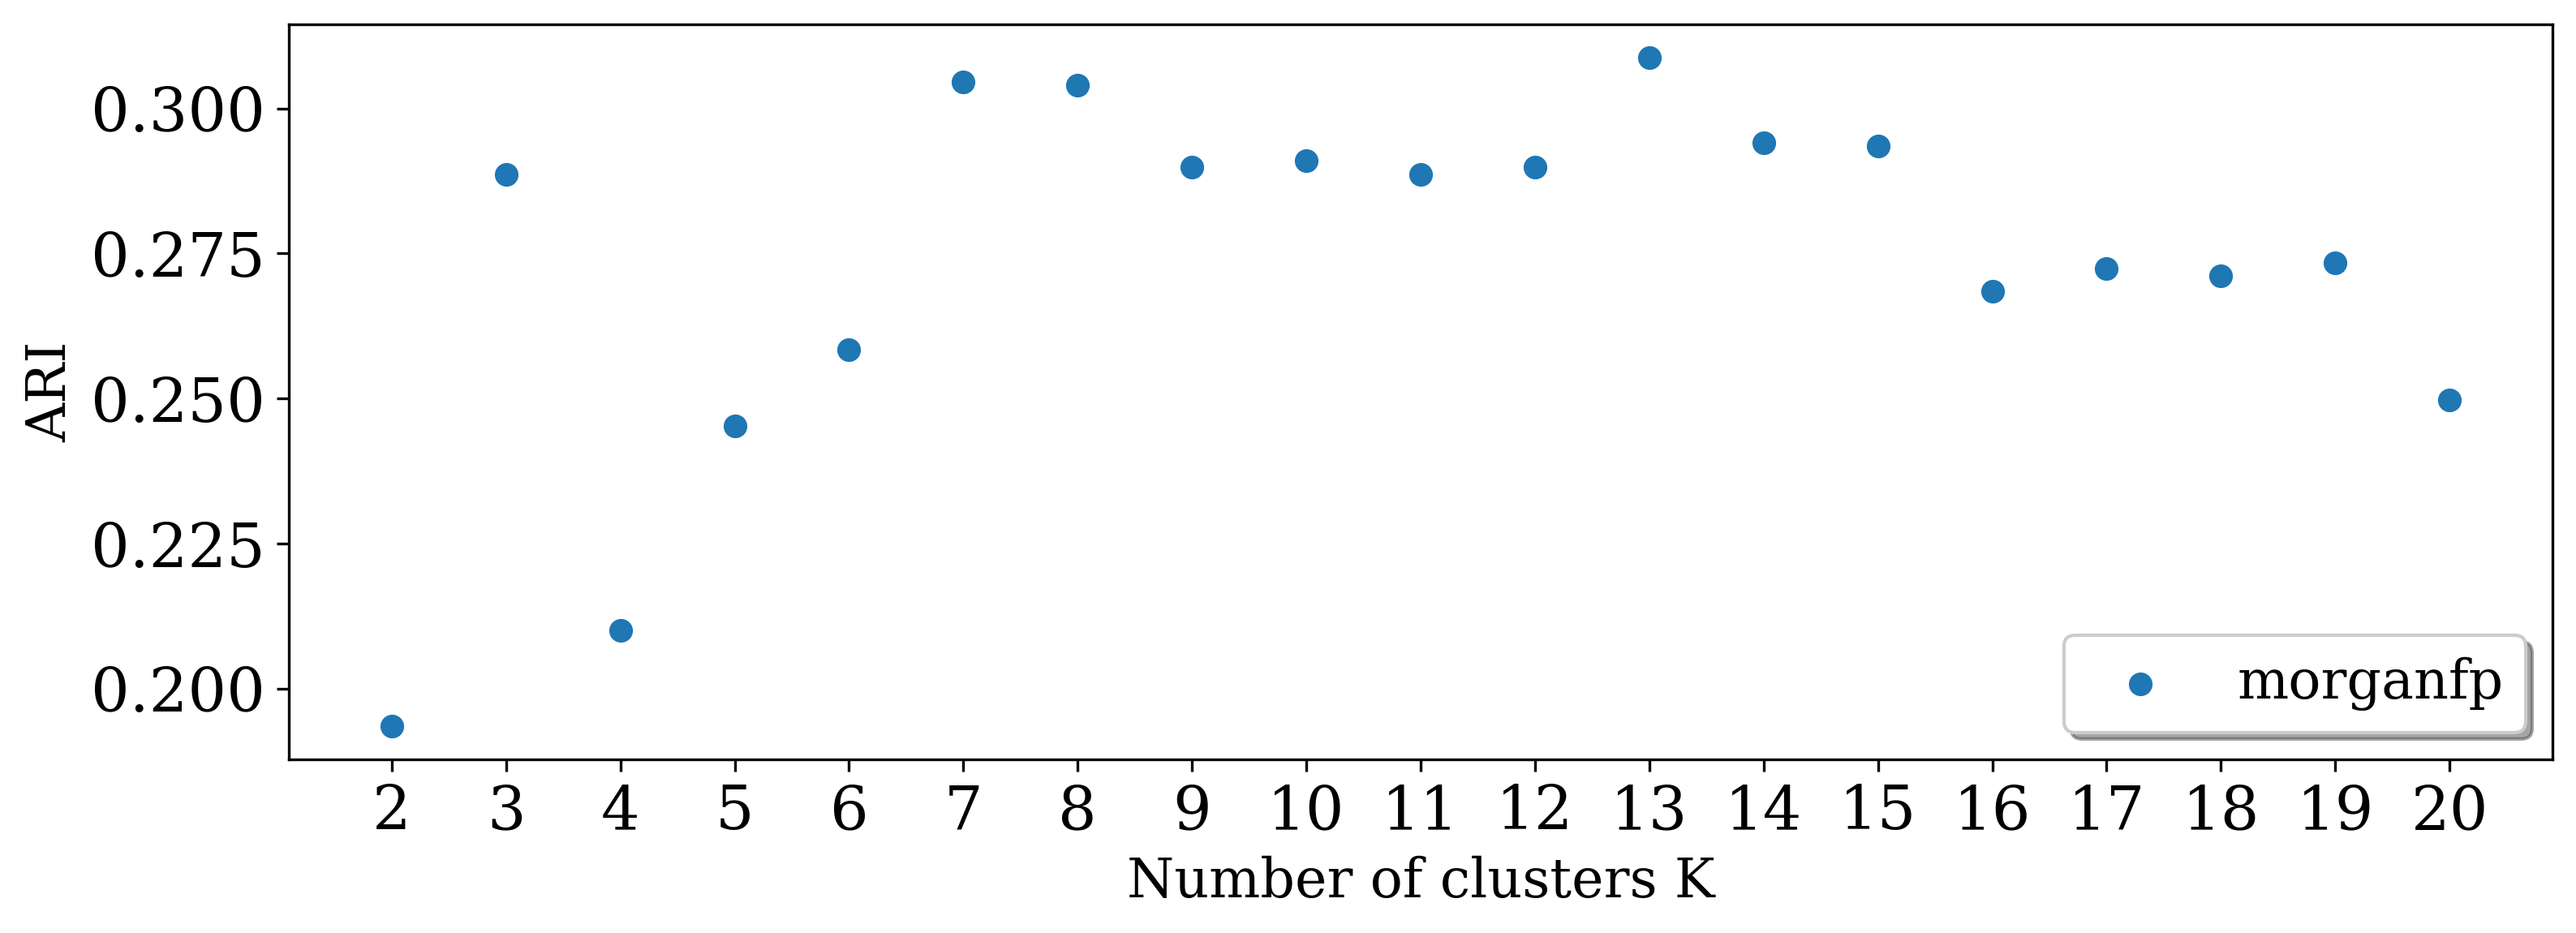

In [973]:
plot = sil_K_plot("ARI", df_result['K'], df_result['Hier_RF_p5_maccs_ARI'], label="morganfp")

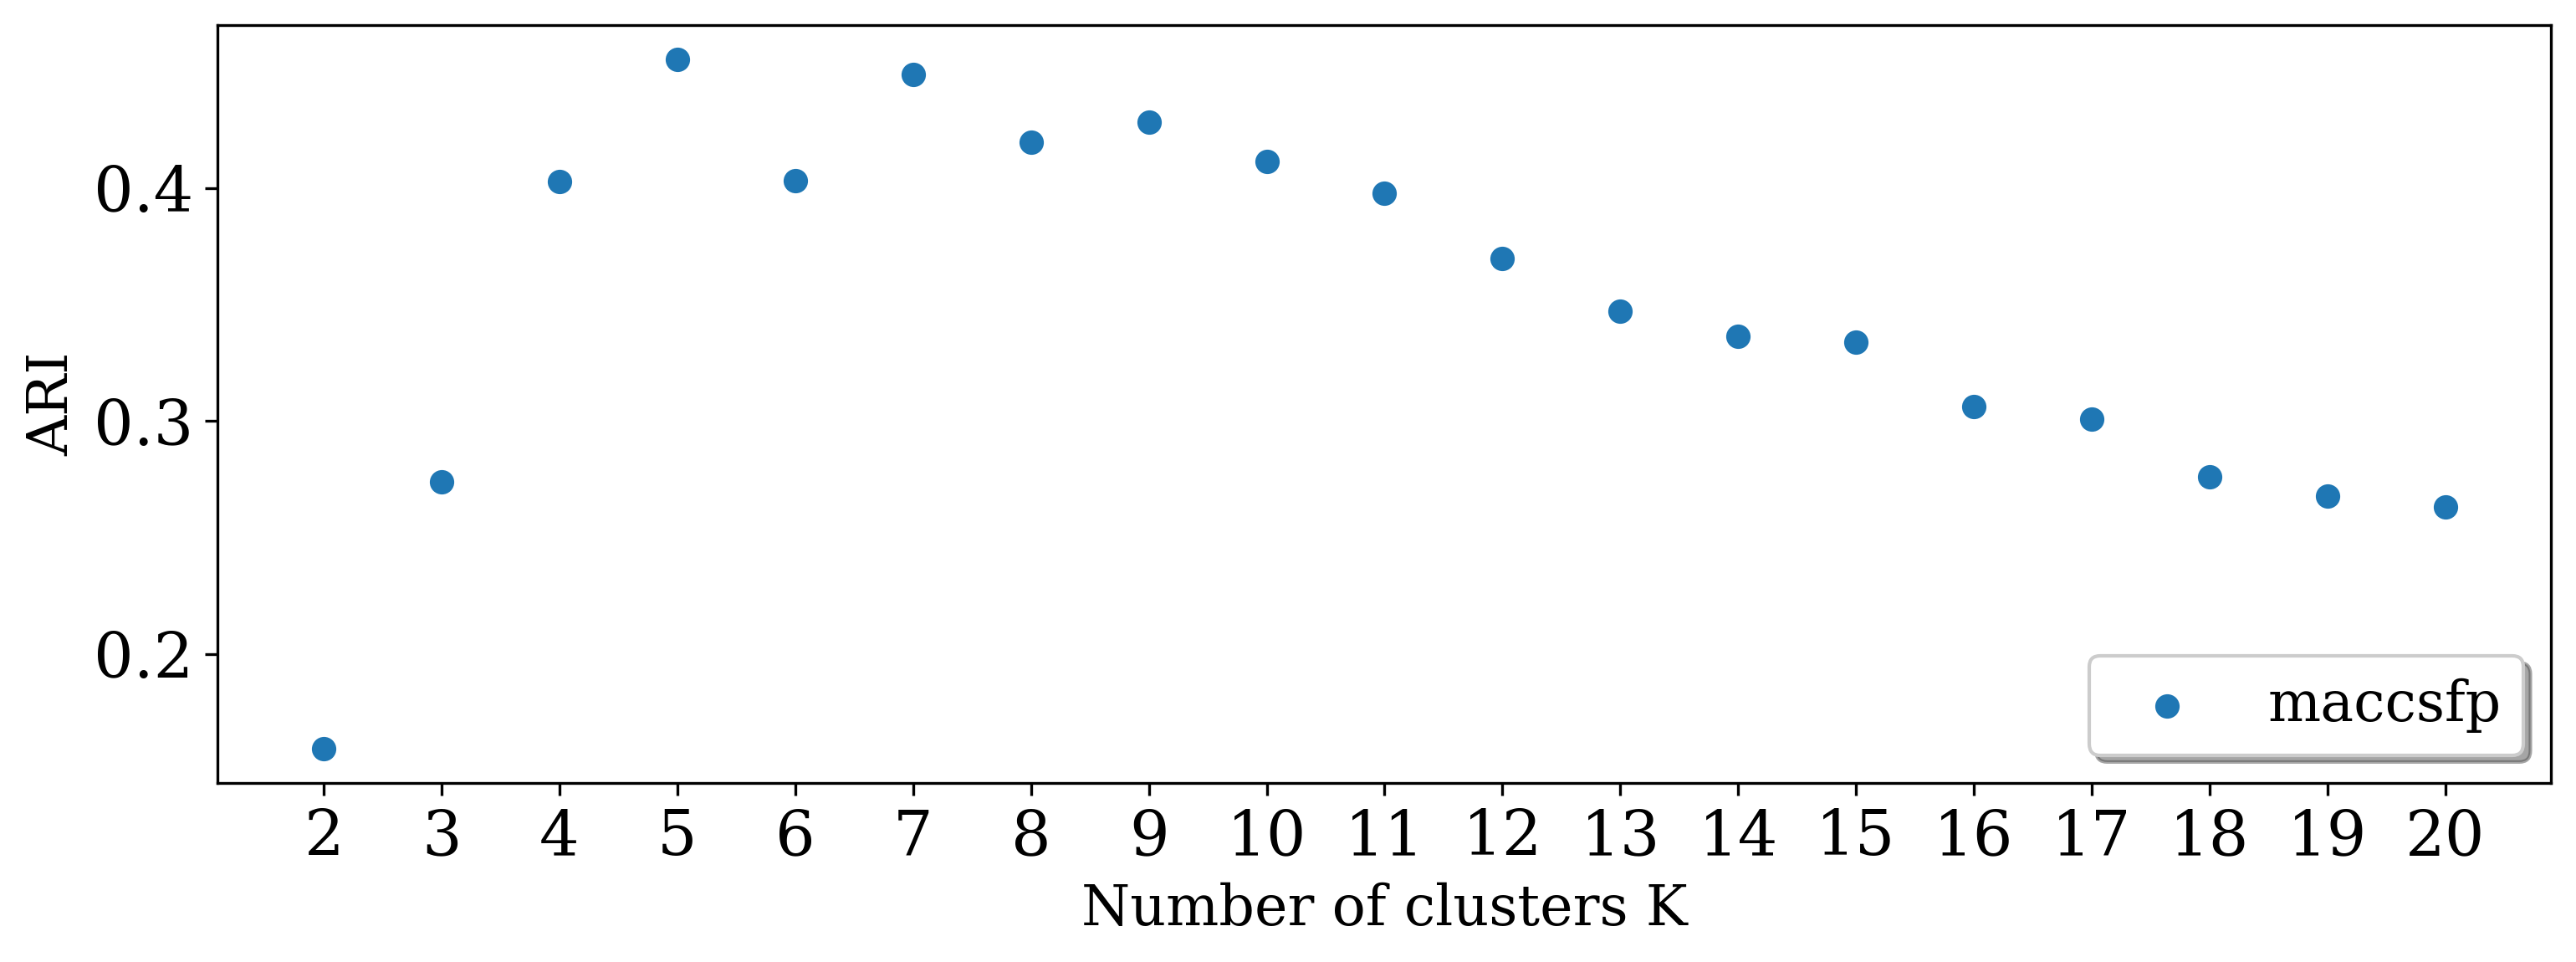

In [974]:
plot = sil_K_plot("ARI", df_result['K'], df_result['Hier_RF_p5_morgan_ARI'], label="maccsfp")

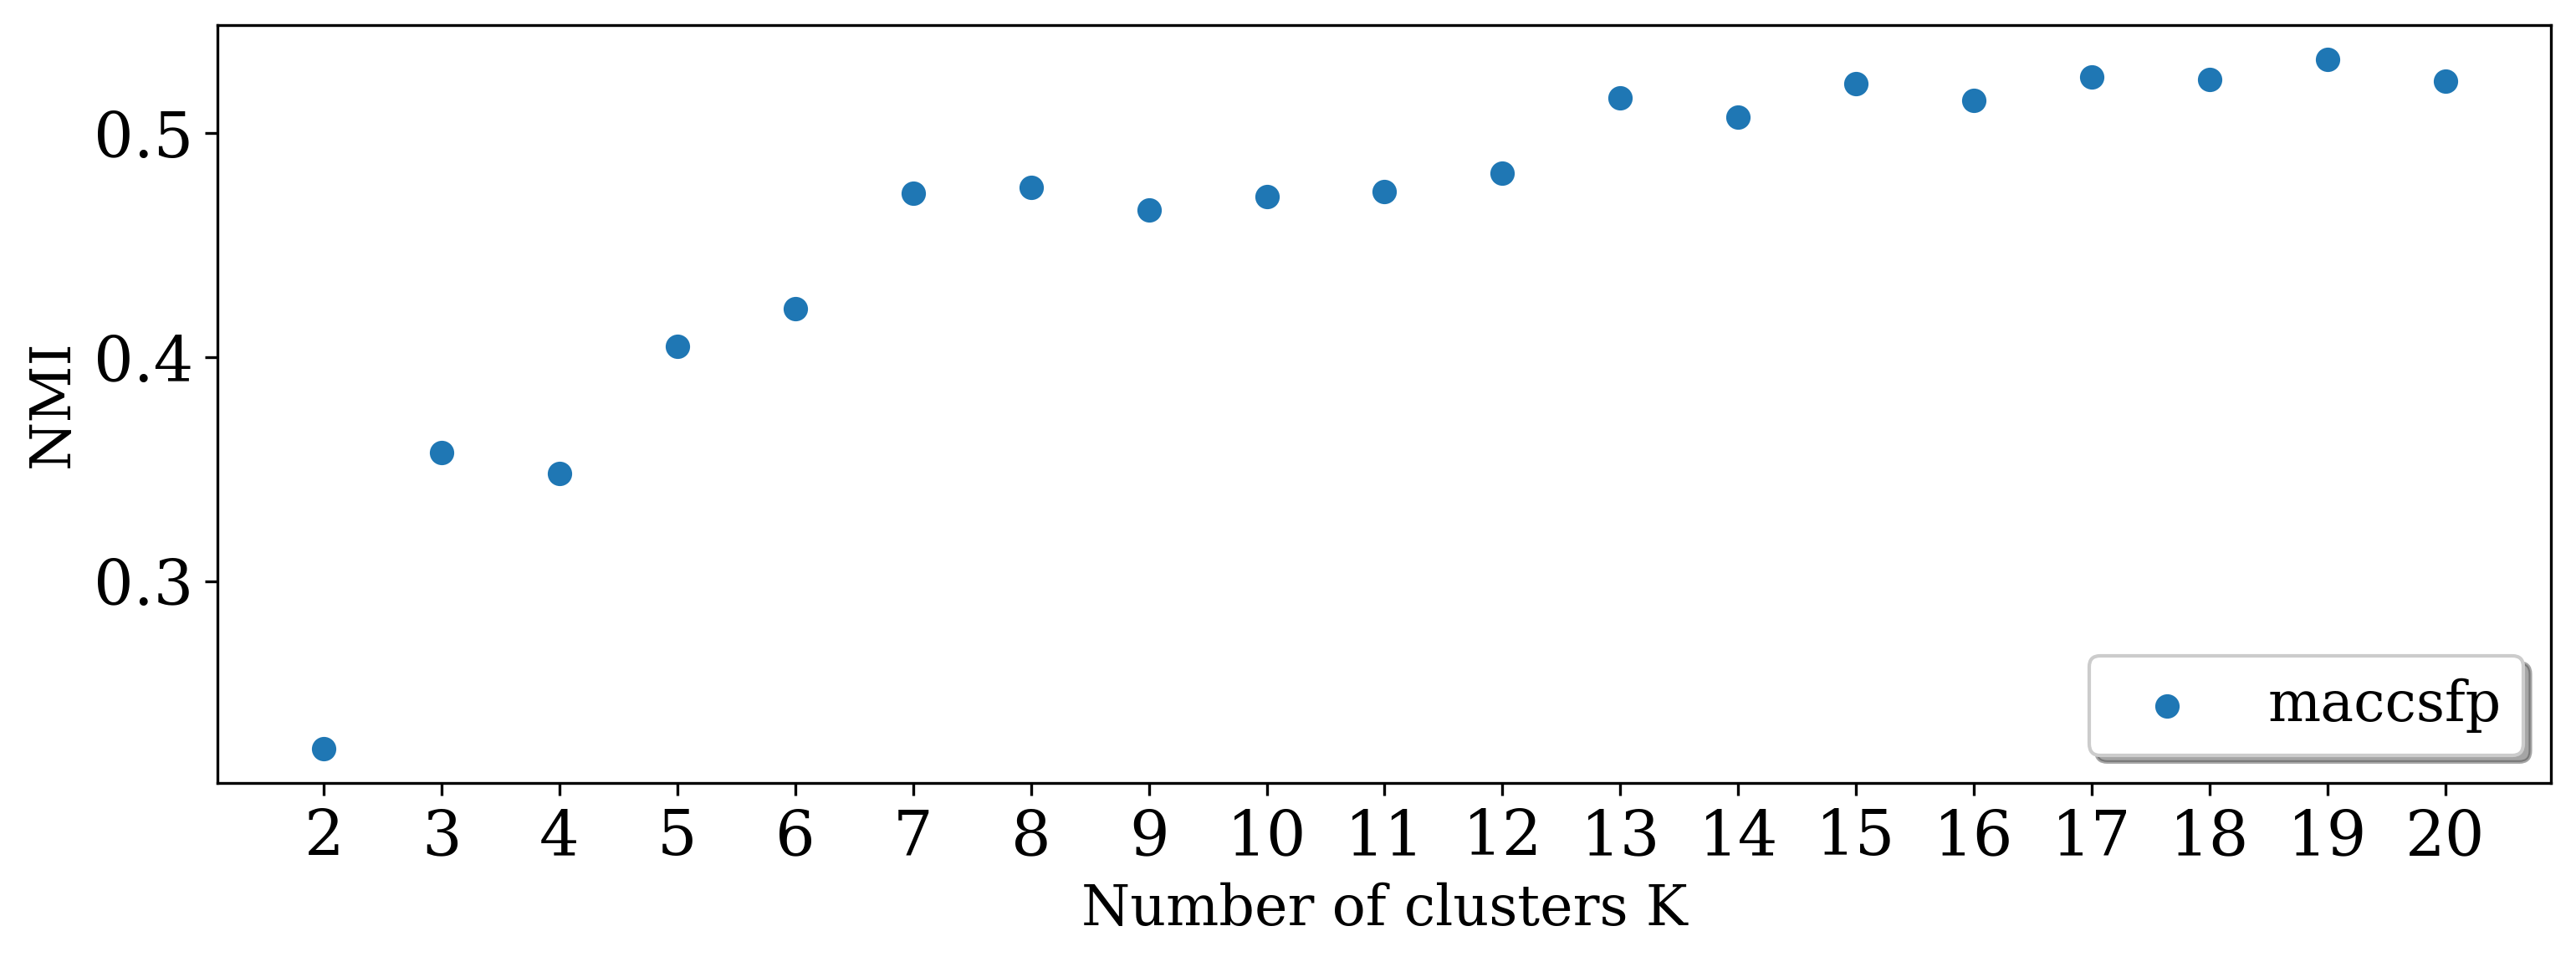

In [975]:
plot = sil_K_plot("NMI", df_result['K'], df_result['Hier_RF_p5_maccs_NMI'], label="maccsfp")

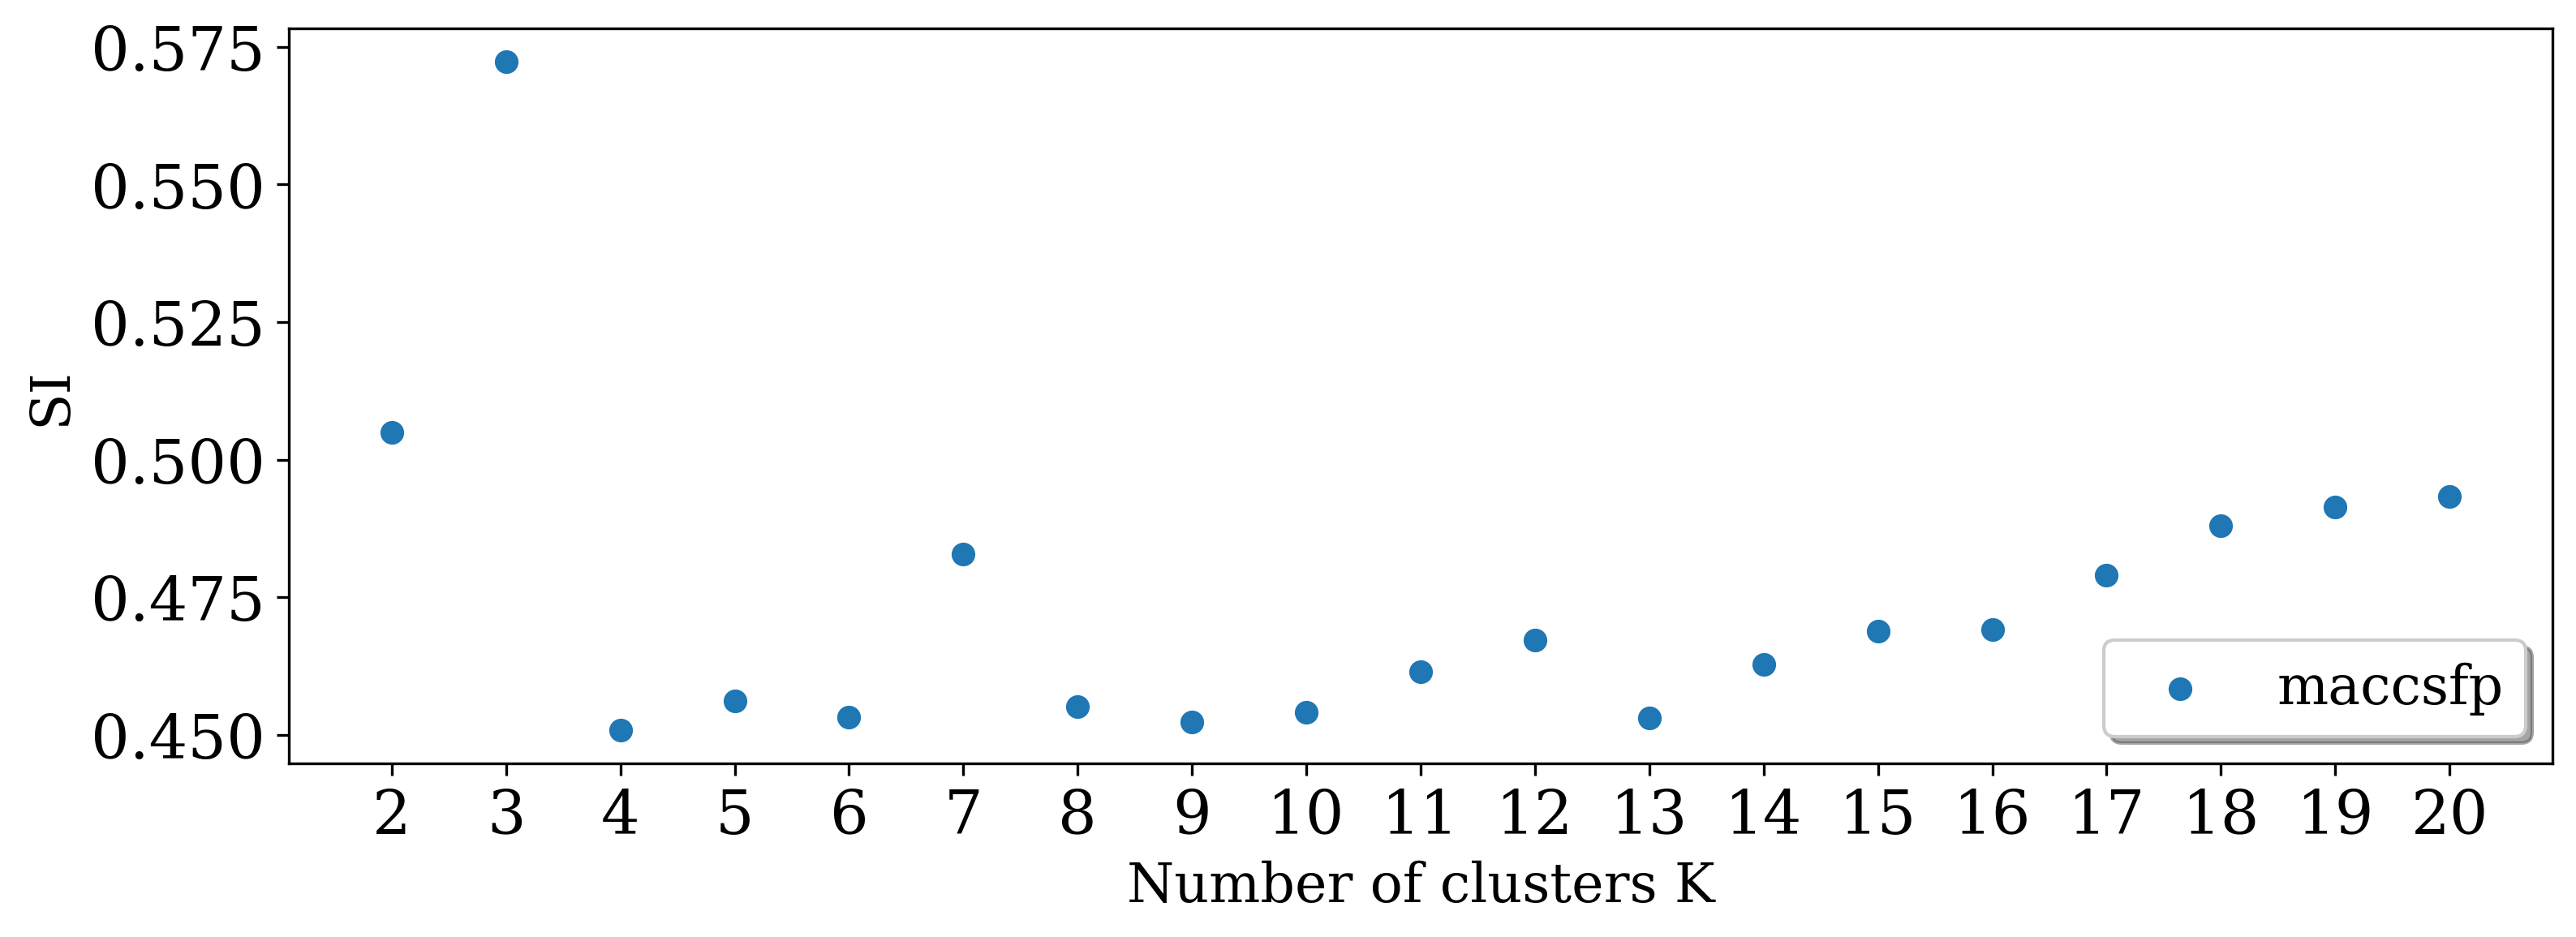

In [976]:
plot = sil_K_plot("SI", df_result['K'], df_result['Hier_RF_p5_maccs_Sil'], label="maccsfp")

In [84]:
df_result.to_csv(path+"Clustering performance by varying requested K, evaluated by K=Pharm.csv",index=False)

## Implementation of Spectral Clustering
#### Parameterization:
* eigen_solver = ['arpack'], which is the default
* eigen_tol = [0.1, 0.01, 0.001, 0.0001, 0.00001]
* gamma: range(25, 400, 25)
* assign_labels = ['kmeans', 'discretize']

In [300]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [560]:
gamma = np.arange(1,6,1)
eigen_tol = [0.1, 0.01, 0.001,0.0001,0.00001, 0.000001]
spec_cl_grid_params = {
    "gamma" : gamma,
    "eigen_tol": eigen_tol,
    "affinity": 'rbf',
    "assign_labels": 'kmeans',
    'random_state':13
}

In [ ]:
n_neighbors = np.arange(7,20,2)
eigen_tol = [0.1, 0.01, 0.001,0.0001,0.00001, 0.000001]
spec_cl_grid_params = {
    "eigen_tol": eigen_tol,
    "n_neighbors": n_neighbors,
    "affinity": "nearest_neighbors",
    "assign_labels": 'kmeans',
    'random_state':13
}

In [561]:
def get_spec_cl_params():
    spec_cl_params_base = list()
    for gamma in spec_cl_grid_params['gamma']:
        for eigen_tol in spec_cl_grid_params['eigen_tol']:
            spec_cl_params = {
                "gamma": gamma,
                "eigen_tol": eigen_tol,
                "affinity": 'rbf',
                "assign_labels":'kmeans',
                'random_state':13}
            spec_cl_params_base.append(spec_cl_params)
    return spec_cl_params_base

spec_cl_params_base = get_spec_cl_params()

In [562]:
def spec_cl_parameterization():
    spec_cl_model = list()
    #spec_cl_params_base = list()
    for params in spec_cl_params_base:
        print(params)
        silhouette,n_clu = list(),list()
        for n_clusters in range(2,51):
            
            cluster_nodes=SpectralClustering(**params, n_clusters = n_clusters).fit_predict(df_cid)
            score = silhouette_score(df_cid.values, cluster_nodes, metric='euclidean')
            silhouette.append(score)
            n_clu.append(n_clusters)
        
    
        result = zip(n_clu,silhouette)
        zipped_result = list(result)
        df_result = pd.DataFrame(zipped_result,columns=['n_clusters','average_silouette'])
        #print(df_result.head(5))
        print("maximum average silhouette score")
        print(df_result[df_result['average_silouette']==max(silhouette)])
        #print("*****Done with one params*****")

In [581]:
#rogot_goldberg
df_cid, df_pair = similarity_matrix(NPS_active,rogot_goldberg,"RF_p7_maccs")
#tanimoto
#df_cid, df_pair = similarity_matrix(NPS_active,tanimoto,"morganfp")

In [582]:
spec_cl_parameterization()

{'gamma': 1, 'eigen_tol': 0.1, 'affinity': 'rbf', 'assign_labels': 'kmeans', 'random_state': 13}
maximum average silhouette score
    n_clusters  average_silouette
33          35           0.550112
{'gamma': 1, 'eigen_tol': 0.01, 'affinity': 'rbf', 'assign_labels': 'kmeans', 'random_state': 13}
maximum average silhouette score
    n_clusters  average_silouette
33          35           0.550112
{'gamma': 1, 'eigen_tol': 0.001, 'affinity': 'rbf', 'assign_labels': 'kmeans', 'random_state': 13}
maximum average silhouette score
    n_clusters  average_silouette
22          24           0.538523
{'gamma': 1, 'eigen_tol': 0.0001, 'affinity': 'rbf', 'assign_labels': 'kmeans', 'random_state': 13}
maximum average silhouette score
    n_clusters  average_silouette
22          24           0.538523
{'gamma': 1, 'eigen_tol': 1e-05, 'affinity': 'rbf', 'assign_labels': 'kmeans', 'random_state': 13}
maximum average silhouette score
    n_clusters  average_silouette
22          24           0.538523
{'

### Eigengap heuristic for finding the optimal number of clusters
Paper "A Tutorial on Spectral Clustering - Ulrike von Luxburg"
##### Approach based on perturbation theory and spectral graph theory to calculate the optimal number of clusters. 
* Eigengap heuristic suggests the number of clusters k is usually given by the value of k that maximizes the engengap (difference between consecutive eigenvalues).
* The larger the eigengap is, the closer the eigenvectors of the ideal case and hence the better spectral clustering works

In [509]:
def predict_k(affinity_matrix):
    """predict number of optimal k based on the eigengap.
    
    Parameters
    ----------
    affinity_matrix : array-like or sparse matrix, shape: (n_samples, n_samples) adjacency matrix.
    Each element of this matrix contains a measure of similarity between two of the data points.
    
    Steps recommended in the paper 
    "A Tutorial on Spectral Clustering, 2007
        Luxburg, Ulrike
        http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf"
        
        1. Construct the normalized Laplacian matrix: L = D−1/2AD−1/2
        2. Find the eigenvalues and their associated eigen vectors 
        3. Identify the maximum gap which corresponds to the number of clusters by eigengap heuristic
        
    Returns
    ----------
    k: integer
       estimated number of clusters"""
    L = csgraph.laplacian(affinity_matrix, normed=True)
    n_components = affinity_matrix.shape[0] - 1
    
    eigenvalues, eigenvectors = eigsh(-L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    eigenvalues = -eigenvalues[::-1] #reverse and sign inversion
    
    max_gap = 0
    gap_pre_index = 0
    for i in range(1, eigenvalues.size):
        gap = eigenvalues[i]-eigenvalues[i-1]
        if gap > max_gap:
            max_gap = gap
            gap_pre_index = i - 1
    print(max_gap)

    k = gap_pre_index + 1
    print("Optimal number of clusters:", k)    

    #plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
    #fig = plt.figure(figsize=(8,4), dpi = 300)
    plt.rc('font', family='serif', size = 10)
    plt.scatter(np.arange(30)+1, eigenvalues[0:30])
    plt.xticks(np.arange(1,31,step=1))
    plt.title('The first 30 eigenvalues of Laplacian')
    plt.grid()
    plt.show()
    #fig.tight_layout()
    #fig.savefig(path+"Figure. First 30 eigenvalues.png",  bbox_inches='tight')
    return k, max_gap

In [585]:
def optimal_K_evaluation(NPS_train, similarity, fingerprint):
    df_cid, df_pair = similarity_matrix(NPS_train,similarity,fingerprint)

    clustering = SpectralClustering(affinity='nearest_neighbors',n_neighbors=11,eigen_tol=0.001, random_state=13).fit(df_cid)
    print(clustering)
    # Get Affinity matrix
    A = clustering.affinity_matrix_
    # Determine optimal K using max eigenvalue gap

    optimal_K, max_gap = predict_k(A)
    
    Ph_labels_pred = SpectralClustering(n_clusters = optimal_K, affinity='nearest_neighbors',n_neighbors=11,eigen_tol=0.001, random_state=13).fit_predict(df_cid)
    ARI = adjusted_rand_score(NPS_train['Pharm class label'], Ph_labels_pred) 
    NMI = adjusted_mutual_info_score(NPS_train['Pharm class label'], Ph_labels_pred)
    sil = silhouette_score(df_cid.values, Ph_labels_pred, metric='euclidean')
    print("Cluster label predicted according to pharmacological categorization: K =",optimal_K)
    print("ARI %0.3f" %ARI, ", NMI: %0.3f" % NMI, ", Silhouette: %0.3f" %sil)
    
    return optimal_K, max_gap, ARI, NMI, sil

Total of  189 evaluations
Leave [0] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13535311619455692
Optimal number of clusters: 16


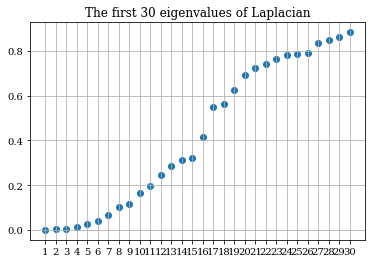

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.448
********************
Leave [1] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12665410848767
Optimal number of clusters: 16


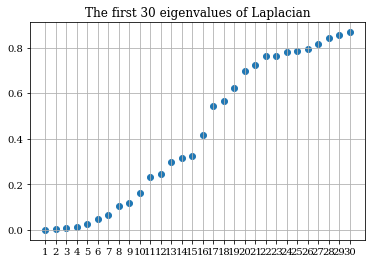

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.466 , Silhouette: 0.443
********************
Leave [2] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1399088001322799
Optimal number of clusters: 16


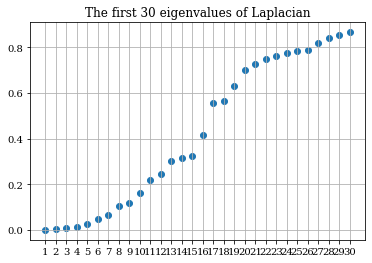

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.444
********************
Leave [3] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1263796522184708
Optimal number of clusters: 16


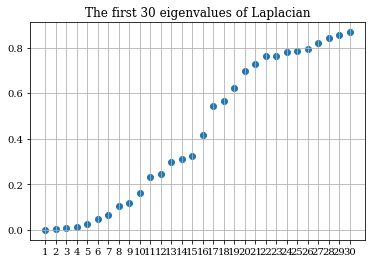

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.443
********************
Leave [4] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13457105782772372
Optimal number of clusters: 16


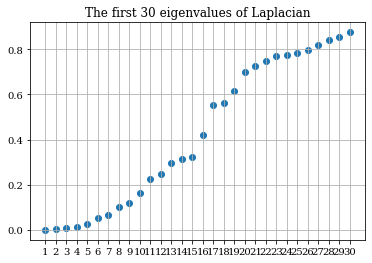

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.461 , Silhouette: 0.443
********************
Leave [5] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12657029037830658
Optimal number of clusters: 16


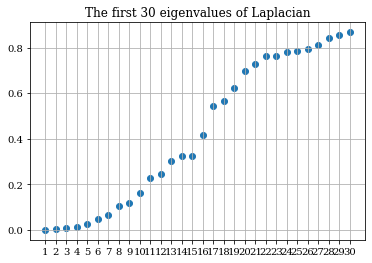

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.442
********************
Leave [6] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1292322014791052
Optimal number of clusters: 16


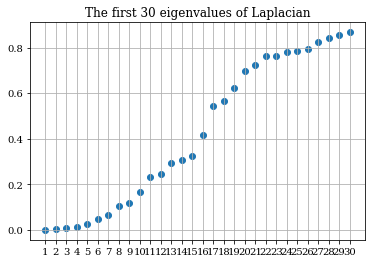

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.443
********************
Leave [7] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1235036425007765
Optimal number of clusters: 16


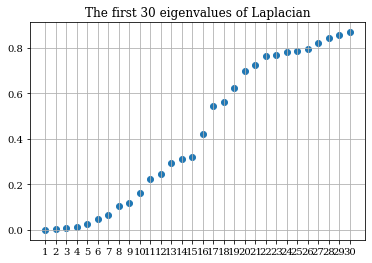

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.180 , NMI: 0.452 , Silhouette: 0.439
********************
Leave [8] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1263748156704778
Optimal number of clusters: 16


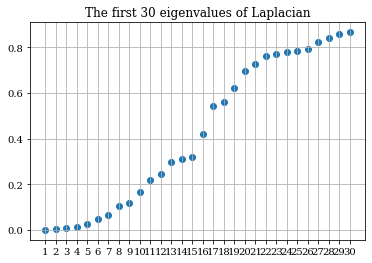

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.180 , NMI: 0.452 , Silhouette: 0.438
********************
Leave [9] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1264256124055485
Optimal number of clusters: 16


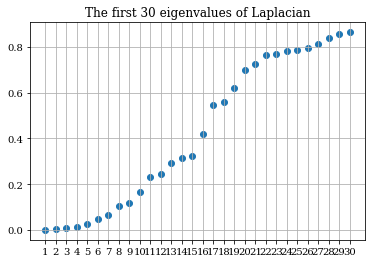

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.180 , NMI: 0.452 , Silhouette: 0.439
********************
Leave [10] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1265710607929167
Optimal number of clusters: 16


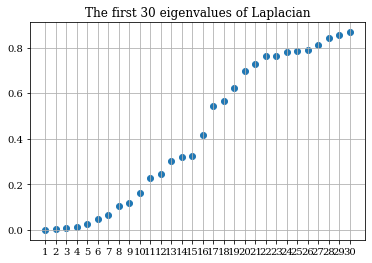

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.443
********************
Leave [11] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14950504600601078
Optimal number of clusters: 16


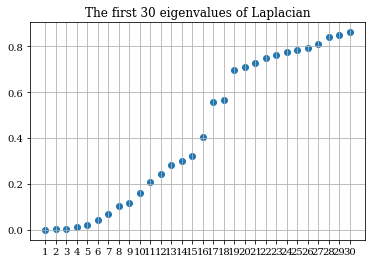

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.450
********************
Leave [12] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.137075140465863
Optimal number of clusters: 16


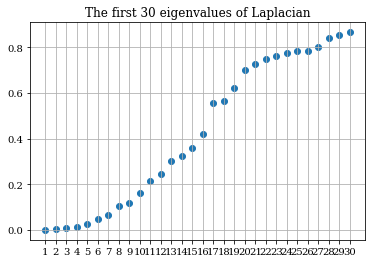

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.459 , Silhouette: 0.441
********************
Leave [13] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1370751404658641
Optimal number of clusters: 16


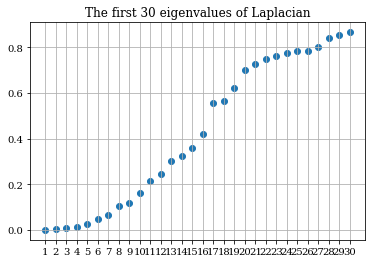

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.459 , Silhouette: 0.441
********************
Leave [14] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1341817902146869
Optimal number of clusters: 16


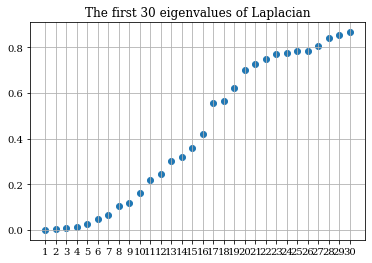

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.461 , Silhouette: 0.441
********************
Leave [15] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1370178785690439
Optimal number of clusters: 16


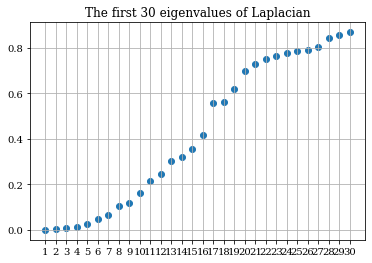

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.459 , Silhouette: 0.442
********************
Leave [16] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1370435781513355
Optimal number of clusters: 16


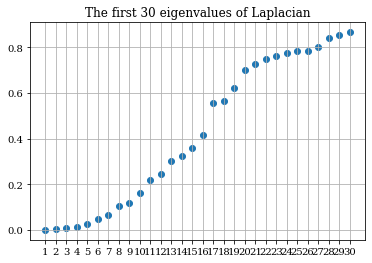

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.466 , Silhouette: 0.442
********************
Leave [17] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13732154426307264
Optimal number of clusters: 16


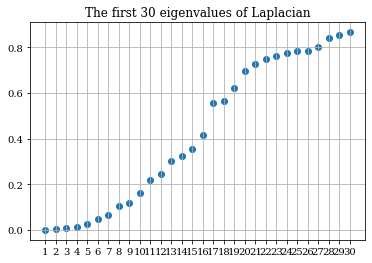

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.466 , Silhouette: 0.442
********************
Leave [18] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13419921586067818
Optimal number of clusters: 16


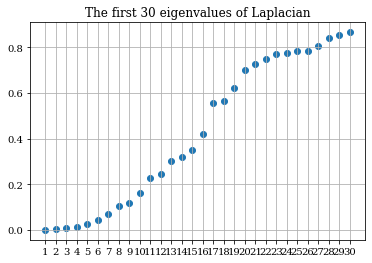

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.452 , Silhouette: 0.438
********************
Leave [19] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1264910575658662
Optimal number of clusters: 16


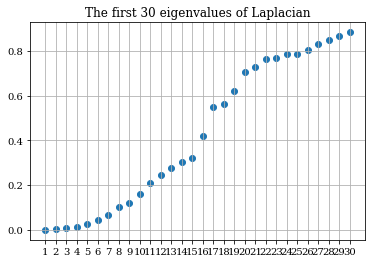

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.459 , Silhouette: 0.446
********************
Leave [20] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12669698692213616
Optimal number of clusters: 16


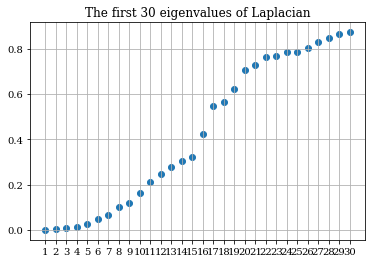

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.468 , Silhouette: 0.442
********************
Leave [21] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12019774750379253
Optimal number of clusters: 16


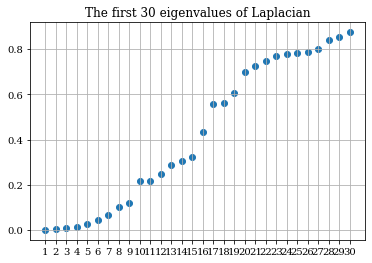

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.455 , Silhouette: 0.440
********************
Leave [22] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13545636204586597
Optimal number of clusters: 16


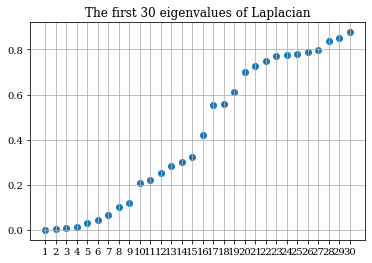

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.456 , Silhouette: 0.444
********************
Leave [23] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1354563620458682
Optimal number of clusters: 16


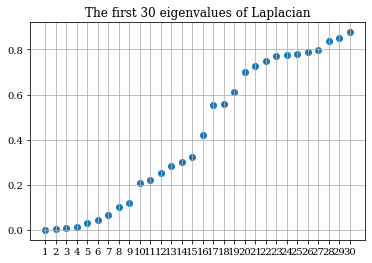

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.456 , Silhouette: 0.444
********************
Leave [24] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12577204544563547
Optimal number of clusters: 16


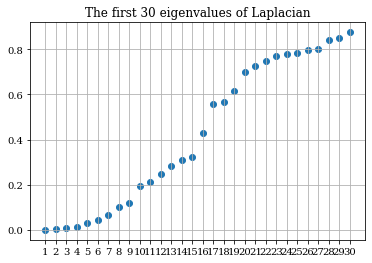

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.460 , Silhouette: 0.446
********************
Leave [25] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1201977475037943
Optimal number of clusters: 16


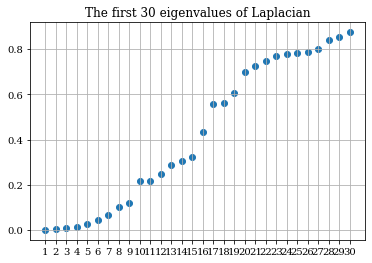

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.455 , Silhouette: 0.440
********************
Leave [26] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12019774750379142
Optimal number of clusters: 16


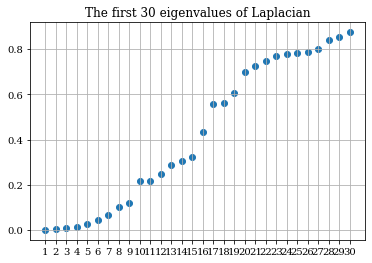

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.455 , Silhouette: 0.440
********************
Leave [27] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12308945987018838
Optimal number of clusters: 16


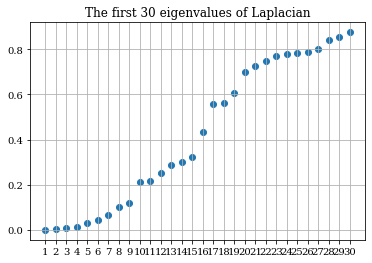

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.455 , Silhouette: 0.441
********************
Leave [28] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13434387908729106
Optimal number of clusters: 16


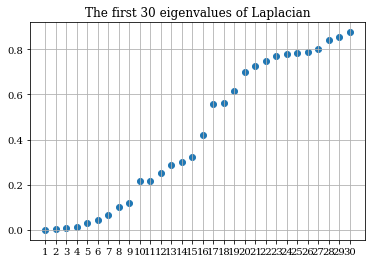

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.455 , Silhouette: 0.441
********************
Leave [29] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12103531690821967
Optimal number of clusters: 15


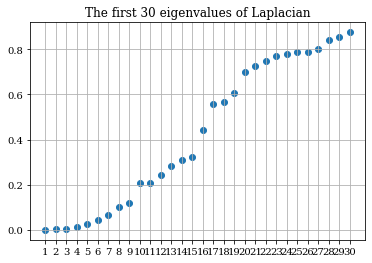

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.176 , NMI: 0.435 , Silhouette: 0.437
********************
Leave [30] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12178395622525007
Optimal number of clusters: 16


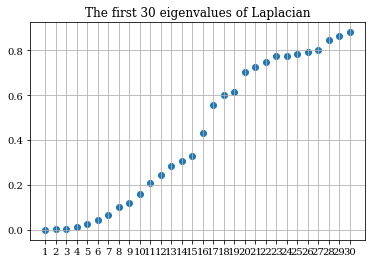

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.441
********************
Leave [31] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12572833971802244
Optimal number of clusters: 16


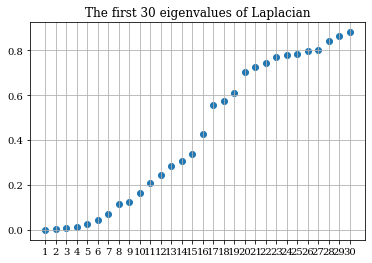

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.445
********************
Leave [32] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.11833758884909185
Optimal number of clusters: 15


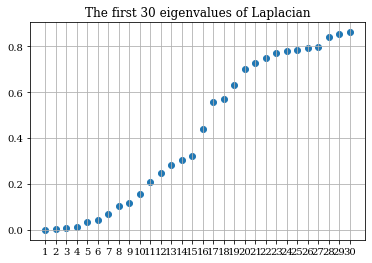

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.178 , NMI: 0.438 , Silhouette: 0.441
********************
Leave [33] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1217839562252494
Optimal number of clusters: 16


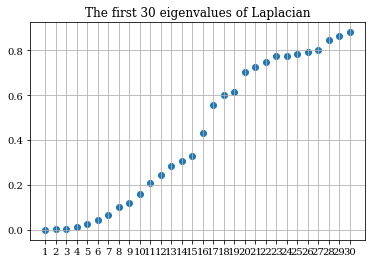

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.441
********************
Leave [34] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12572833971802222
Optimal number of clusters: 16


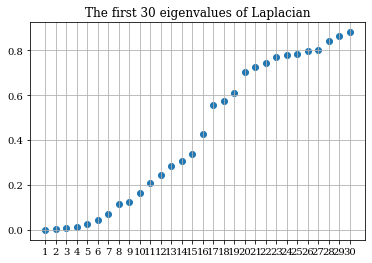

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.445
********************
Leave [35] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12178395622524874
Optimal number of clusters: 16


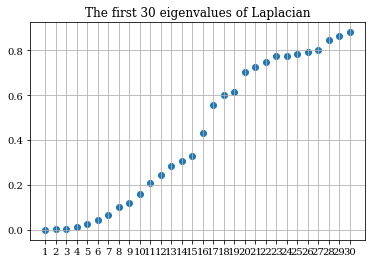

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.441
********************
Leave [36] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13658883072584693
Optimal number of clusters: 16


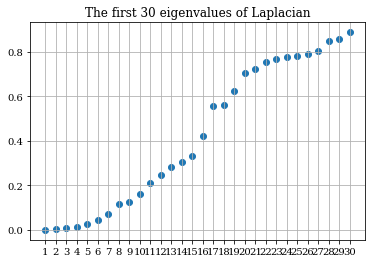

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.446
********************
Leave [37] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1322704027210997
Optimal number of clusters: 16


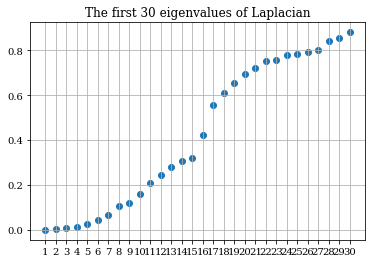

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.447
********************
Leave [38] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.133166834126359
Optimal number of clusters: 16


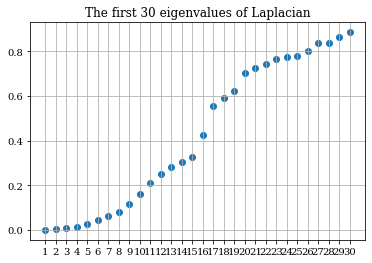

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.442
********************
Leave [39] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13400157995767703
Optimal number of clusters: 16


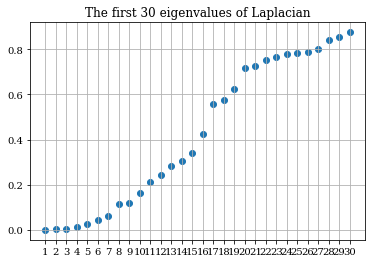

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.446
********************
Leave [40] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12852917650546725
Optimal number of clusters: 16


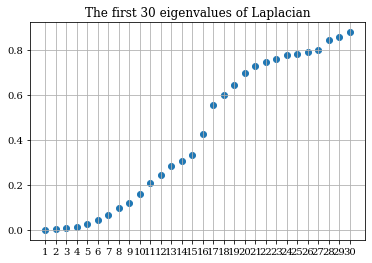

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [41] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1367830462441626
Optimal number of clusters: 16


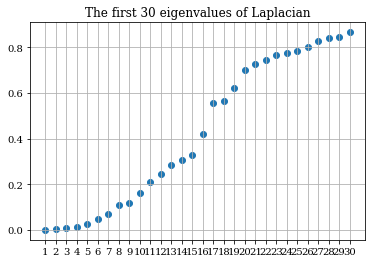

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.457 , Silhouette: 0.443
********************
Leave [42] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1366362182534584
Optimal number of clusters: 16


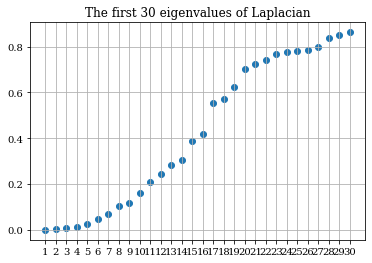

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.434
********************
Leave [43] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12634862697465565
Optimal number of clusters: 16


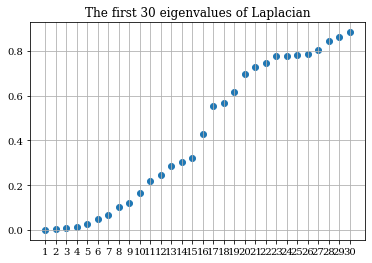

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.445
********************
Leave [44] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1346494459223786
Optimal number of clusters: 16


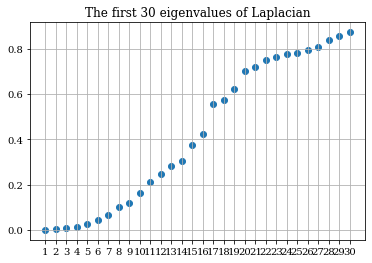

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.460 , Silhouette: 0.445
********************
Leave [45] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13606978276440662
Optimal number of clusters: 16


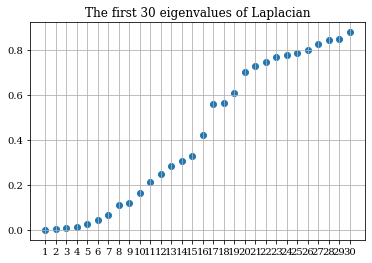

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.455 , Silhouette: 0.440
********************
Leave [46] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1414032991080083
Optimal number of clusters: 16


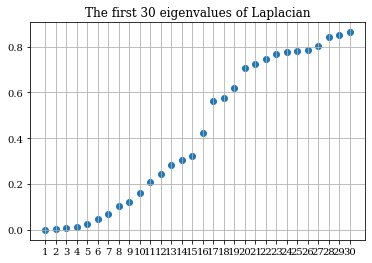

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [47] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14140329910800964
Optimal number of clusters: 16


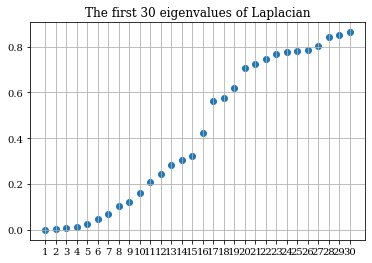

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [48] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1344417980874597
Optimal number of clusters: 15


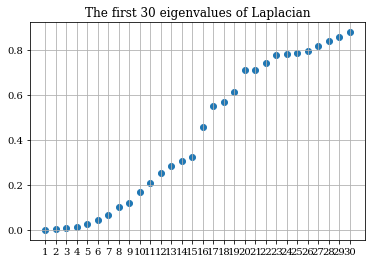

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.178 , NMI: 0.438 , Silhouette: 0.441
********************
Leave [49] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12974170532021634
Optimal number of clusters: 16


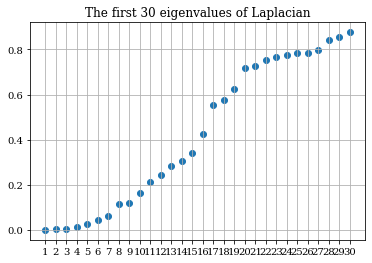

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.461 , Silhouette: 0.442
********************
Leave [50] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.11826604467721613
Optimal number of clusters: 15


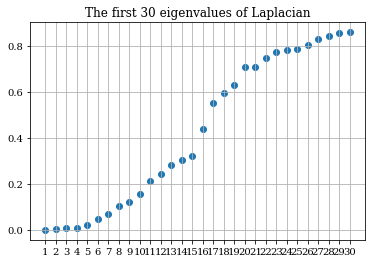

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.174 , NMI: 0.435 , Silhouette: 0.442
********************
Leave [51] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1413957267654371
Optimal number of clusters: 16


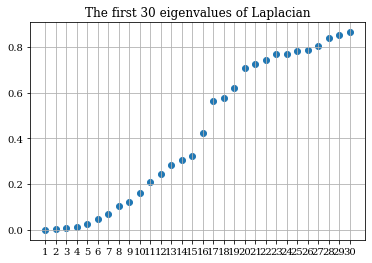

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [52] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543777
Optimal number of clusters: 16


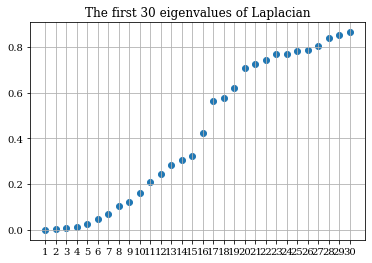

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [53] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13444179524744237
Optimal number of clusters: 15


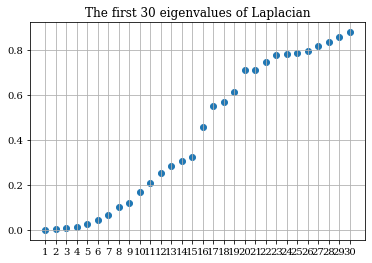

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.178 , NMI: 0.438 , Silhouette: 0.441
********************
Leave [54] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543843
Optimal number of clusters: 16


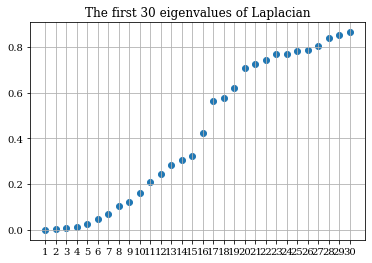

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [55] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543954
Optimal number of clusters: 16


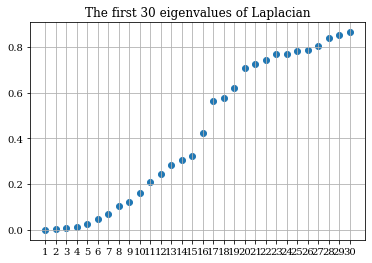

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [56] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676544154
Optimal number of clusters: 16


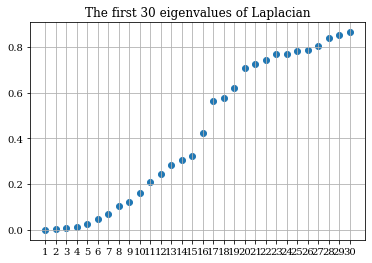

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [57] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543777
Optimal number of clusters: 16


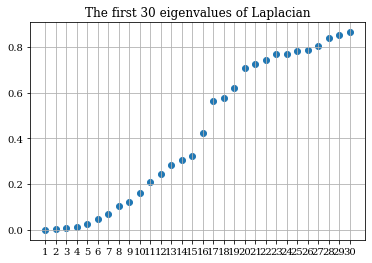

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [58] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543932
Optimal number of clusters: 16


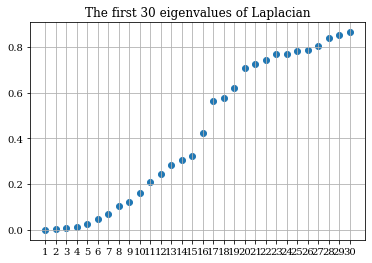

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [59] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543954
Optimal number of clusters: 16


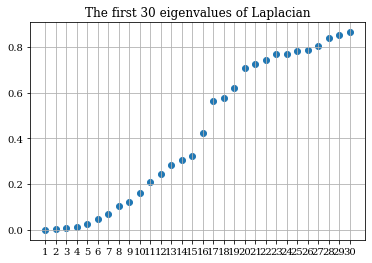

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [60] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139572676543932
Optimal number of clusters: 16


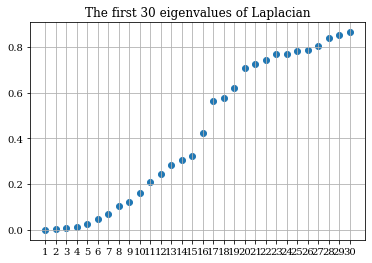

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [61] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13212663048492468
Optimal number of clusters: 16


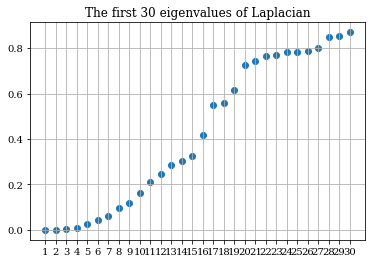

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.465 , Silhouette: 0.445
********************
Leave [62] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13212663048492534
Optimal number of clusters: 16


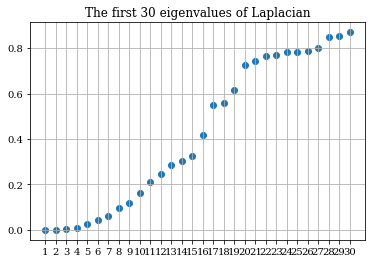

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.465 , Silhouette: 0.445
********************
Leave [63] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139506750542008
Optimal number of clusters: 16


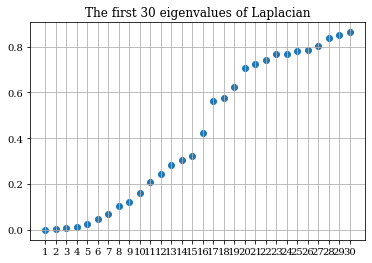

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [64] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139506750542163
Optimal number of clusters: 16


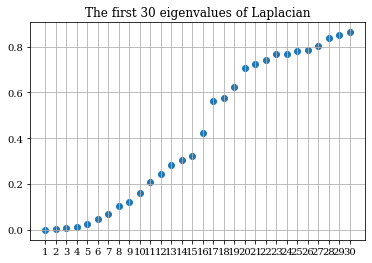

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [65] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14139506750541875
Optimal number of clusters: 16


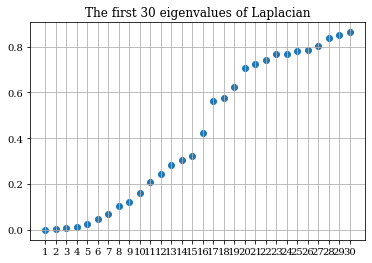

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [66] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13443162205517667
Optimal number of clusters: 16


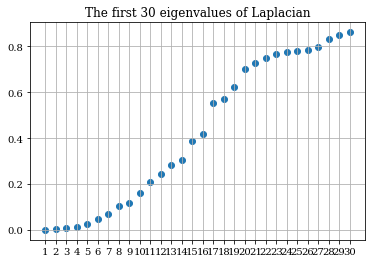

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.438
********************
Leave [67] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13142376716536064
Optimal number of clusters: 16


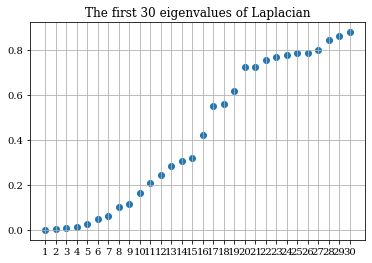

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.446
********************
Leave [68] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1344316220551771
Optimal number of clusters: 16


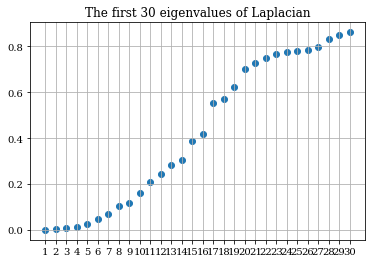

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.438
********************
Leave [69] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12933006786011192
Optimal number of clusters: 16


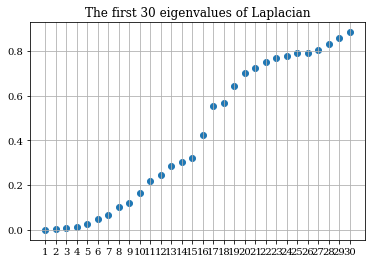

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.473 , Silhouette: 0.446
********************
Leave [70] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1286380289945659
Optimal number of clusters: 16


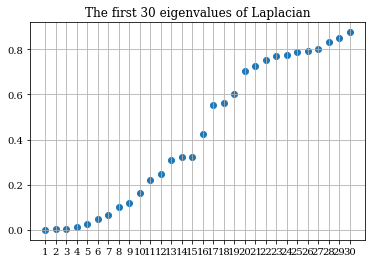

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.463 , Silhouette: 0.445
********************
Leave [71] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13149336326540695
Optimal number of clusters: 16


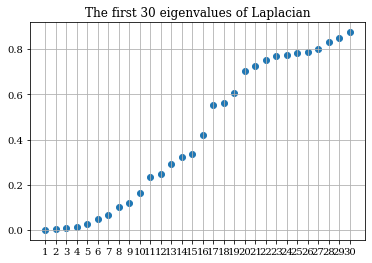

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.190 , NMI: 0.465 , Silhouette: 0.446
********************
Leave [72] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1314952106322076
Optimal number of clusters: 16


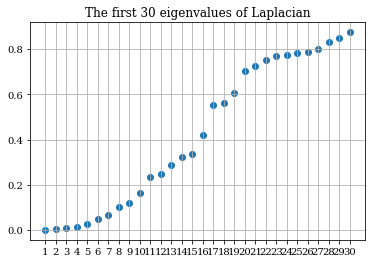

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.456 , Silhouette: 0.446
********************
Leave [73] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13389983831260666
Optimal number of clusters: 16


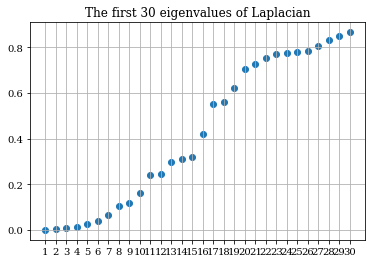

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.463 , Silhouette: 0.448
********************
Leave [74] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14067754449594427
Optimal number of clusters: 16


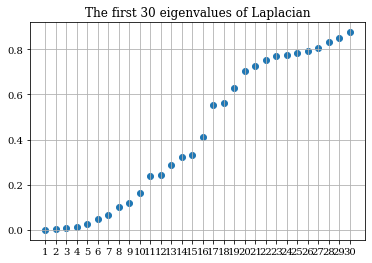

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.446 , Silhouette: 0.441
********************
Leave [75] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13743977314790312
Optimal number of clusters: 16


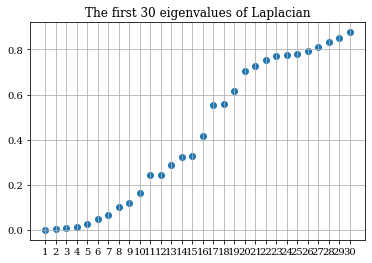

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.446 , Silhouette: 0.441
********************
Leave [76] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1323783635659479
Optimal number of clusters: 16


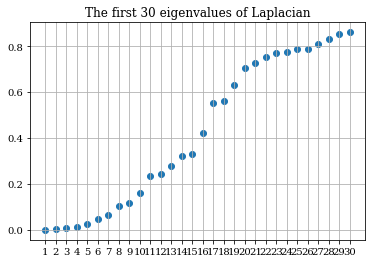

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.445
********************
Leave [77] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13743990098083292
Optimal number of clusters: 16


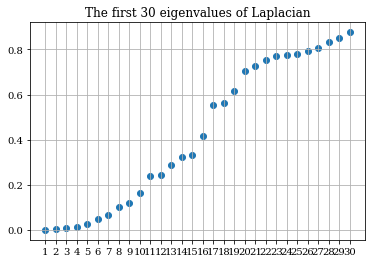

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.446 , Silhouette: 0.441
********************
Leave [78] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13145845858791394
Optimal number of clusters: 16


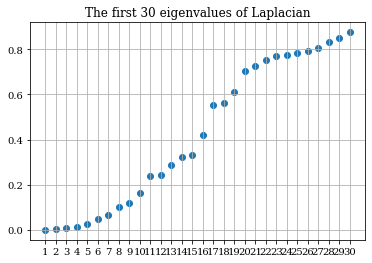

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.446 , Silhouette: 0.441
********************
Leave [79] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12625327033814182
Optimal number of clusters: 16


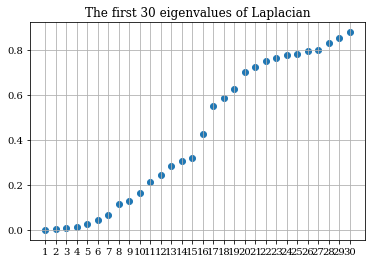

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.447
********************
Leave [80] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1250158132511332
Optimal number of clusters: 16


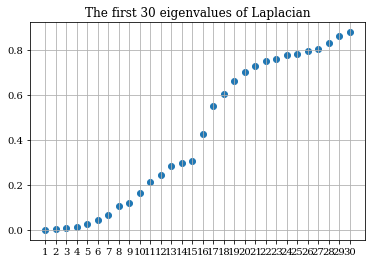

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.446
********************
Leave [81] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13063961417447523
Optimal number of clusters: 16


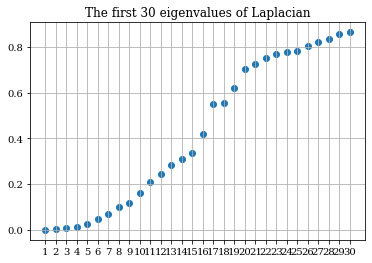

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.461 , Silhouette: 0.443
********************
Leave [82] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13767611134903812
Optimal number of clusters: 16


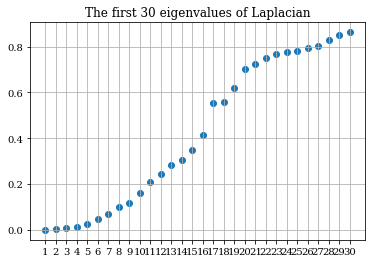

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.461 , Silhouette: 0.445
********************
Leave [83] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1341884027205138
Optimal number of clusters: 16


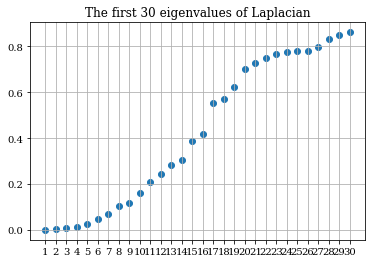

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.438
********************
Leave [84] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13054173057957708
Optimal number of clusters: 16


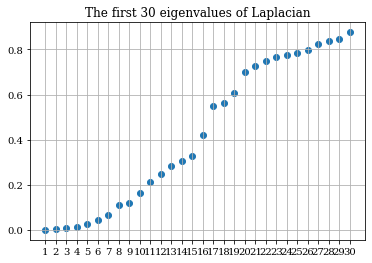

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.440
********************
Leave [85] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13054173057957996
Optimal number of clusters: 16


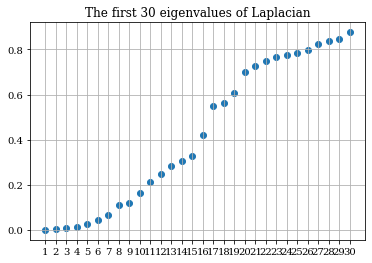

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.440
********************
Leave [86] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13054173057957974
Optimal number of clusters: 16


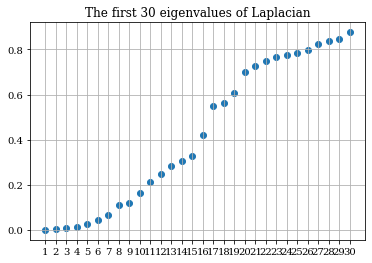

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.440
********************
Leave [87] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13054173057957996
Optimal number of clusters: 16


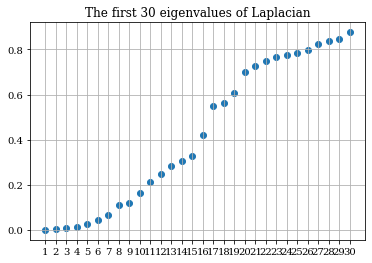

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.440
********************
Leave [88] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12397903535663302
Optimal number of clusters: 16


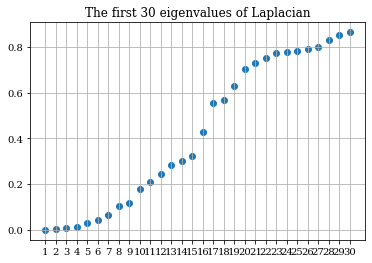

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.445
********************
Leave [89] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12397903535663213
Optimal number of clusters: 16


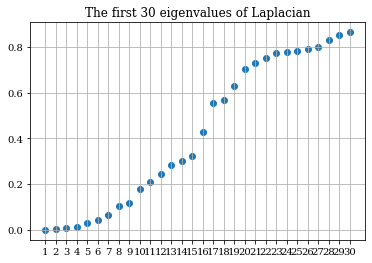

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.445
********************
Leave [90] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12709847234840055
Optimal number of clusters: 16


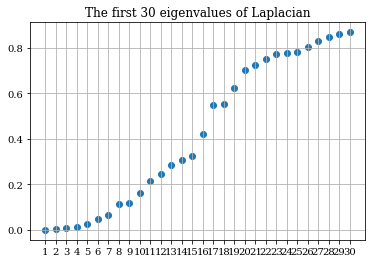

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.442
********************
Leave [91] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13123667686360285
Optimal number of clusters: 16


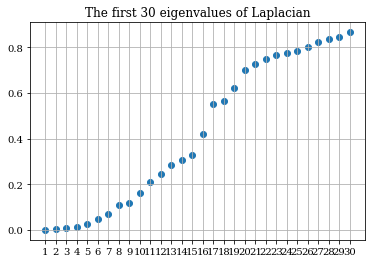

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.188 , NMI: 0.464 , Silhouette: 0.441
********************
Leave [92] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1252715574524872
Optimal number of clusters: 16


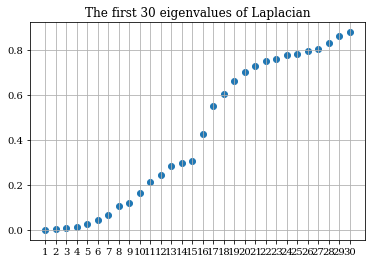

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.456 , Silhouette: 0.439
********************
Leave [93] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12926952598841757
Optimal number of clusters: 16


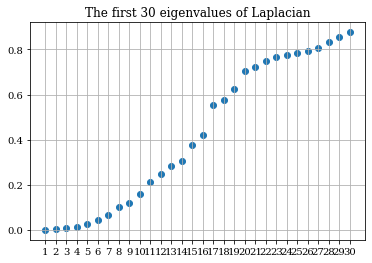

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.461 , Silhouette: 0.441
********************
Leave [94] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1450258376961273
Optimal number of clusters: 16


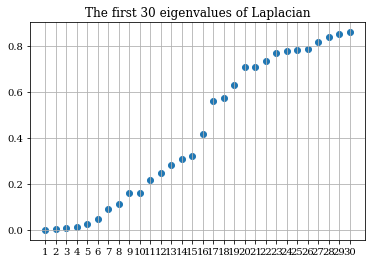

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [95] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1450258376961271
Optimal number of clusters: 16


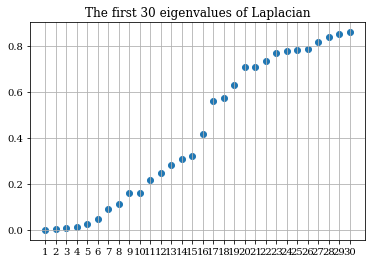

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [96] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14502583769612842
Optimal number of clusters: 16


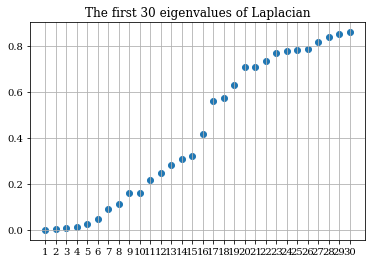

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [97] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14502883108032139
Optimal number of clusters: 16


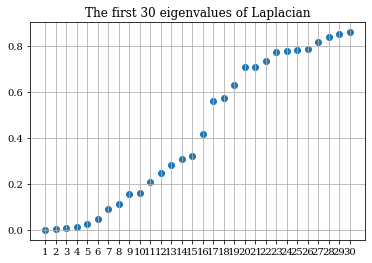

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [98] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14502883108032005
Optimal number of clusters: 16


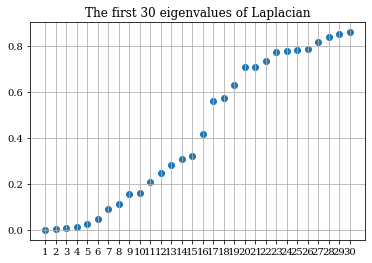

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [99] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14169349339623927
Optimal number of clusters: 16


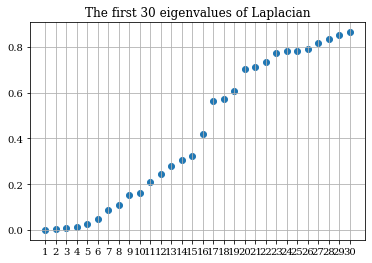

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.439
********************
Leave [100] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1450266697761884
Optimal number of clusters: 16


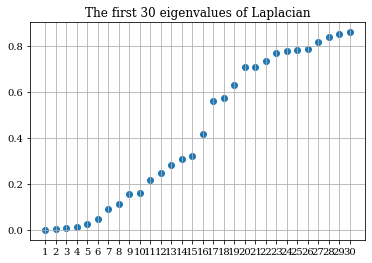

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.462 , Silhouette: 0.443
********************
Leave [101] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14455410589609907
Optimal number of clusters: 16


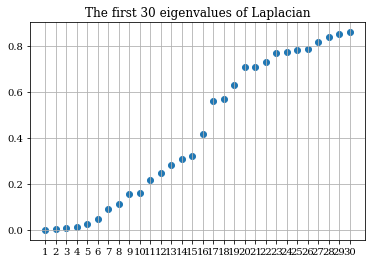

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [102] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.11895263110509724
Optimal number of clusters: 15


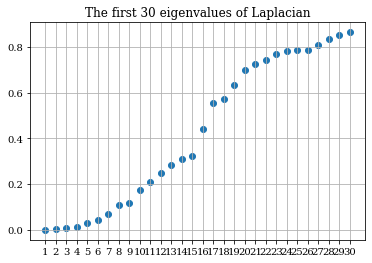

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.203 , NMI: 0.464 , Silhouette: 0.420
********************
Leave [103] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12630143076155842
Optimal number of clusters: 15


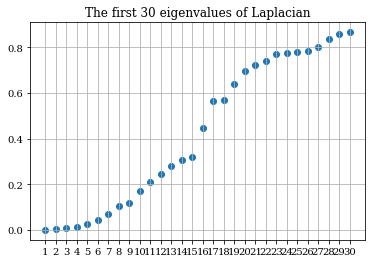

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.174 , NMI: 0.434 , Silhouette: 0.440
********************
Leave [104] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1441588055337406
Optimal number of clusters: 16


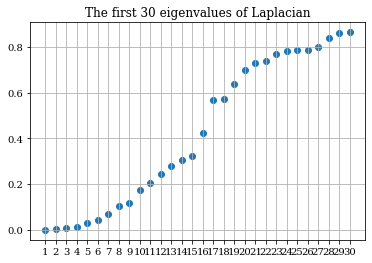

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.458 , Silhouette: 0.445
********************
Leave [105] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.135515562172849
Optimal number of clusters: 15


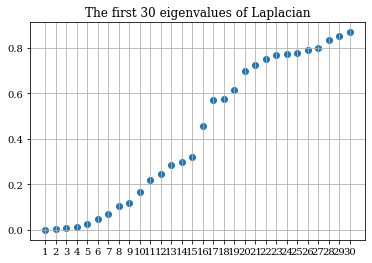

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.174 , NMI: 0.434 , Silhouette: 0.441
********************
Leave [106] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12029163328643011
Optimal number of clusters: 16


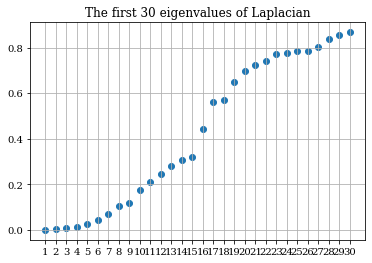

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.453 , Silhouette: 0.442
********************
Leave [107] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14371498458918386
Optimal number of clusters: 16


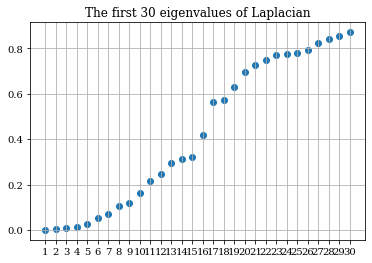

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.471 , Silhouette: 0.447
********************
Leave [108] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12581055618075165
Optimal number of clusters: 15


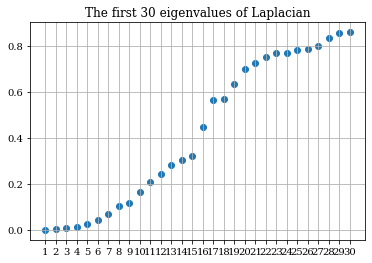

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.174 , NMI: 0.434 , Silhouette: 0.441
********************
Leave [109] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1244153129370631
Optimal number of clusters: 16


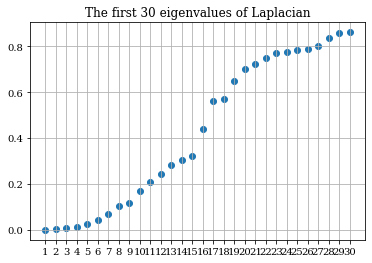

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.453 , Silhouette: 0.443
********************
Leave [110] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.12878572877231353
Optimal number of clusters: 15


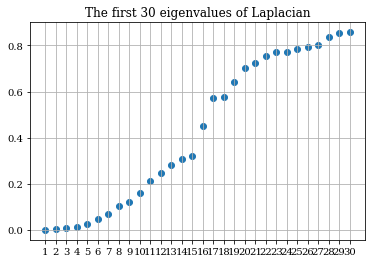

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.174 , NMI: 0.434 , Silhouette: 0.442
********************
Leave [111] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13233025339702298
Optimal number of clusters: 15


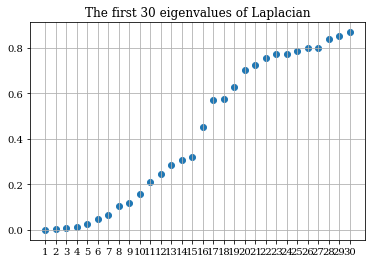

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.174 , NMI: 0.434 , Silhouette: 0.442
********************
Leave [112] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14228663433818522
Optimal number of clusters: 16


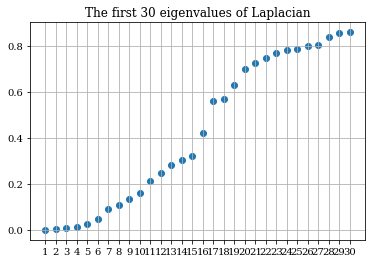

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.452 , Silhouette: 0.447
********************
Leave [113] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14372378670032893
Optimal number of clusters: 16


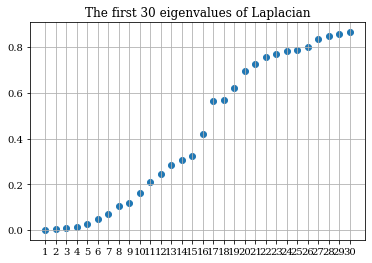

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.465 , Silhouette: 0.445
********************
Leave [114] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13112170832190762
Optimal number of clusters: 16


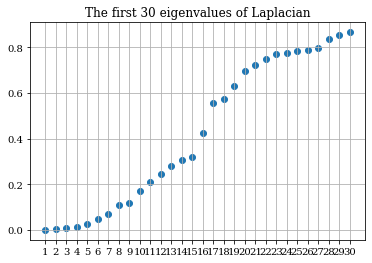

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.453 , Silhouette: 0.444
********************
Leave [115] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13080482994988496
Optimal number of clusters: 16


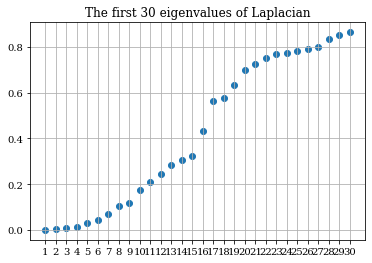

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.453 , Silhouette: 0.445
********************
Leave [116] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14136188360156465
Optimal number of clusters: 16


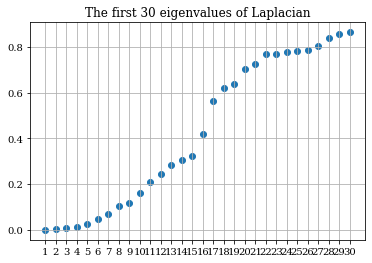

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.446
********************
Leave [117] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1413618836015631
Optimal number of clusters: 16


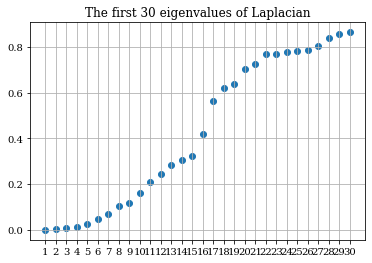

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.446
********************
Leave [118] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14129529873499092
Optimal number of clusters: 16


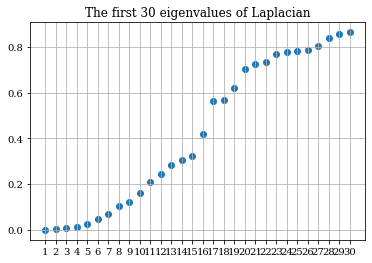

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [119] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14131625219010746
Optimal number of clusters: 16


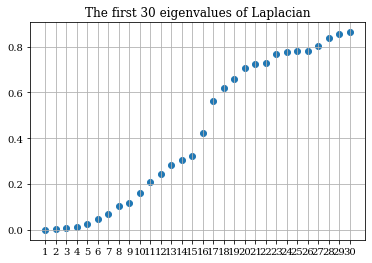

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.446
********************
Leave [120] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14129126018948313
Optimal number of clusters: 16


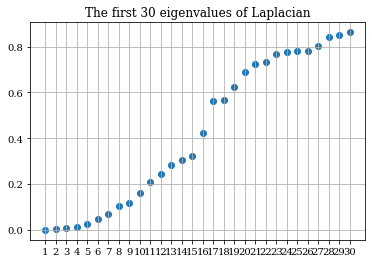

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.443
********************
Leave [121] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14373789791259806
Optimal number of clusters: 16


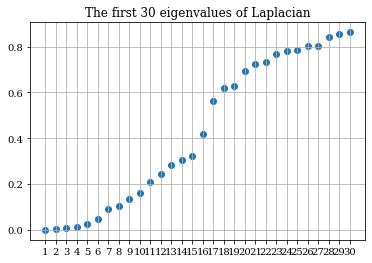

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.452 , Silhouette: 0.450
********************
Leave [122] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14230692310461834
Optimal number of clusters: 16


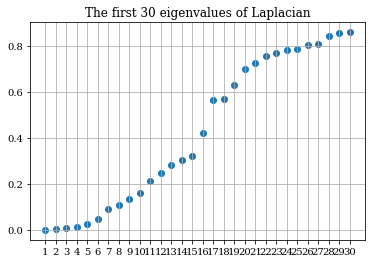

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.452 , Silhouette: 0.447
********************
Leave [123] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1408152824875386
Optimal number of clusters: 16


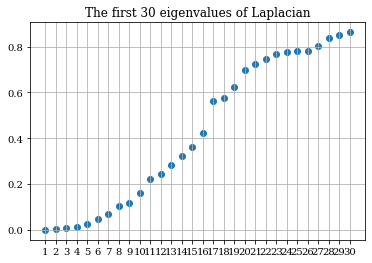

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.463 , Silhouette: 0.441
********************
Leave [124] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14025240022706442
Optimal number of clusters: 16


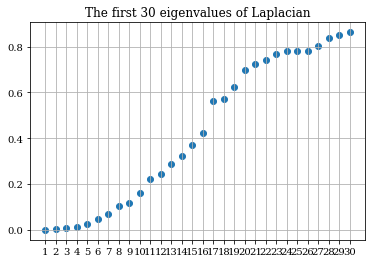

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.441
********************
Leave [125] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14061779301568977
Optimal number of clusters: 16


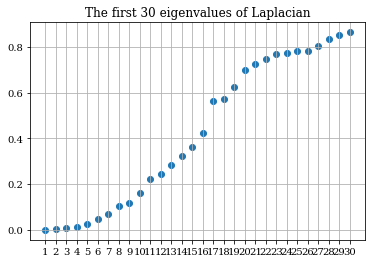

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.463 , Silhouette: 0.440
********************
Leave [126] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14072155976132583
Optimal number of clusters: 16


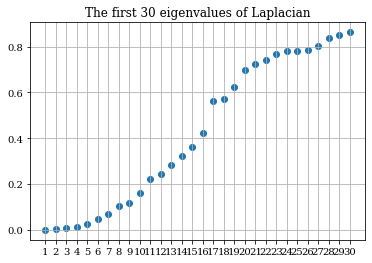

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.463 , Silhouette: 0.440
********************
Leave [127] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14026545579609961
Optimal number of clusters: 16


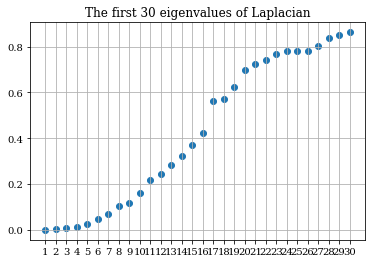

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.462 , Silhouette: 0.436
********************
Leave [128] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1407215597613254
Optimal number of clusters: 16


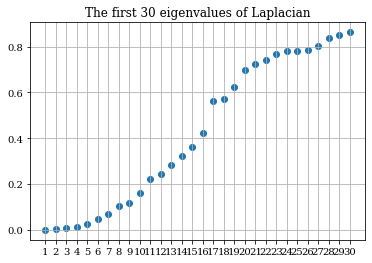

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.463 , Silhouette: 0.440
********************
Leave [129] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14622061384123897
Optimal number of clusters: 16


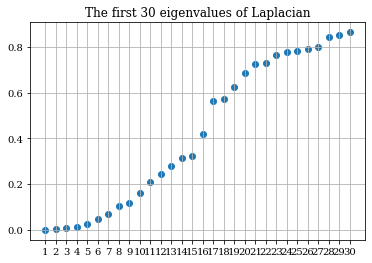

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.467 , Silhouette: 0.444
********************
Leave [130] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14076066354440098
Optimal number of clusters: 16


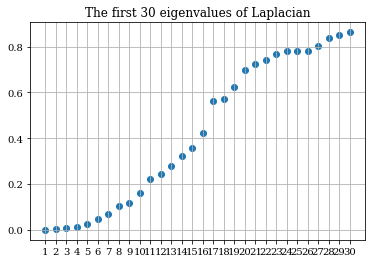

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.463 , Silhouette: 0.440
********************
Leave [131] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1467277074226272
Optimal number of clusters: 16


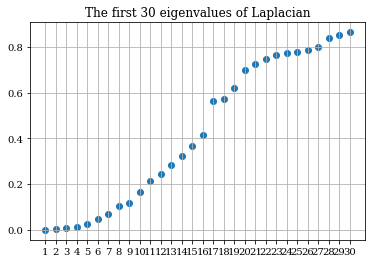

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.459 , Silhouette: 0.442
********************
Leave [132] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14381192844559676
Optimal number of clusters: 16


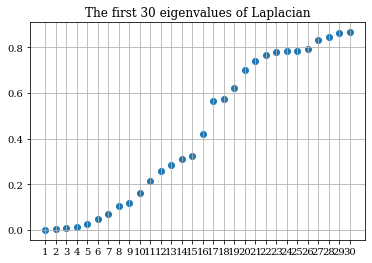

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.454 , Silhouette: 0.444
********************
Leave [133] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14254023941682004
Optimal number of clusters: 16


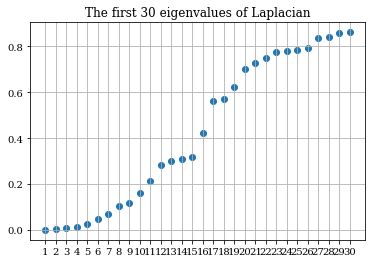

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.442
********************
Leave [134] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1418964416900057
Optimal number of clusters: 16


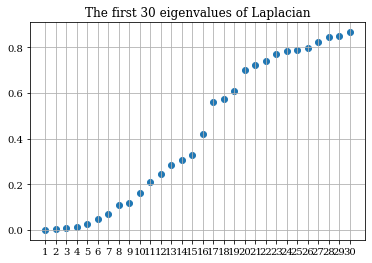

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.466 , Silhouette: 0.440
********************
Leave [135] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14622306960147946
Optimal number of clusters: 16


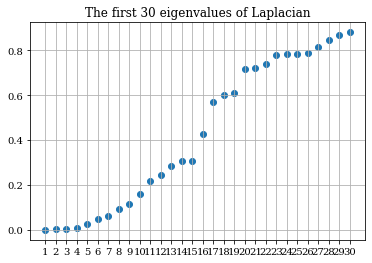

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.464 , Silhouette: 0.450
********************
Leave [136] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1402181561663085
Optimal number of clusters: 16


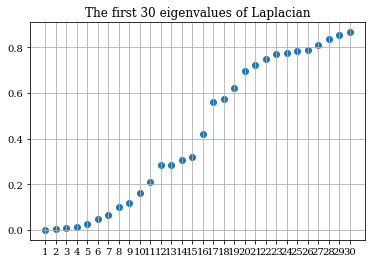

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.461 , Silhouette: 0.446
********************
Leave [137] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13388991541605044
Optimal number of clusters: 16


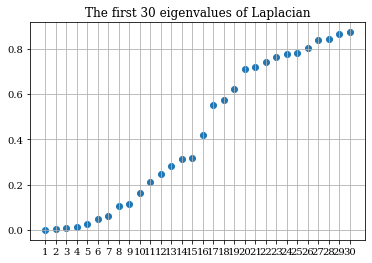

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.462 , Silhouette: 0.445
********************
Leave [138] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14255267178824216
Optimal number of clusters: 16


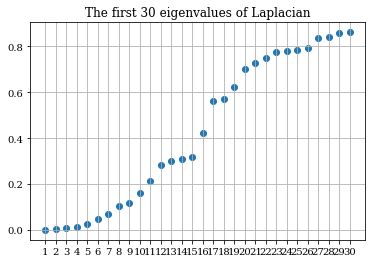

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.453 , Silhouette: 0.437
********************
Leave [139] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13544221047761007
Optimal number of clusters: 16


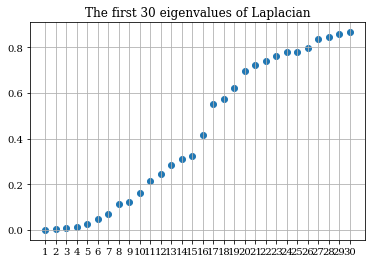

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.462 , Silhouette: 0.443
********************
Leave [140] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14253957347350954
Optimal number of clusters: 16


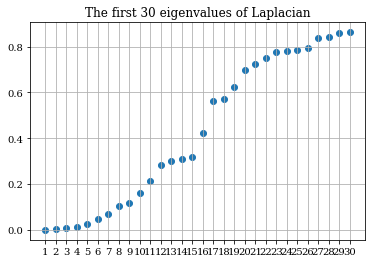

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.453 , Silhouette: 0.437
********************
Leave [141] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13089913265113062
Optimal number of clusters: 16


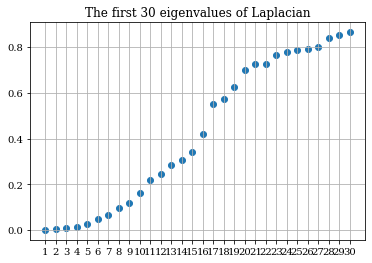

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.187 , NMI: 0.462 , Silhouette: 0.447
********************
Leave [142] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14250299649729903
Optimal number of clusters: 16


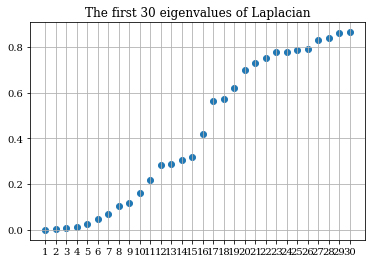

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.439
********************
Leave [143] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14252714107993247
Optimal number of clusters: 16


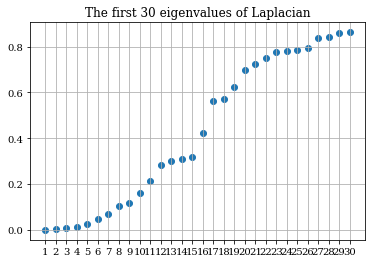

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.454 , Silhouette: 0.441
********************
Leave [144] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14126611390703459
Optimal number of clusters: 16


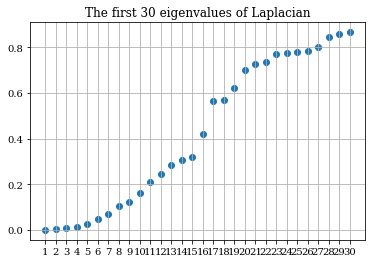

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.190 , NMI: 0.470 , Silhouette: 0.437
********************
Leave [145] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14250299649729814
Optimal number of clusters: 16


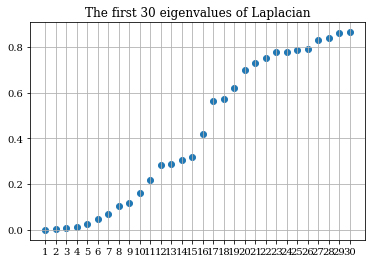

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.439
********************
Leave [146] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13944987514462226
Optimal number of clusters: 16


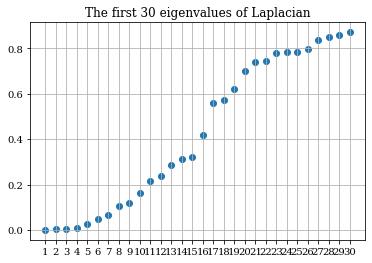

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.178 , NMI: 0.451 , Silhouette: 0.443
********************
Leave [147] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14433487300191783
Optimal number of clusters: 16


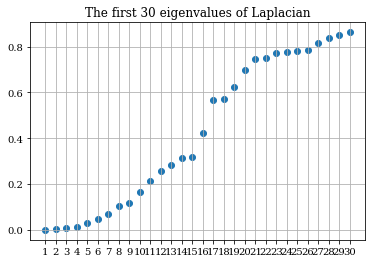

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.443
********************
Leave [148] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14434283495532485
Optimal number of clusters: 16


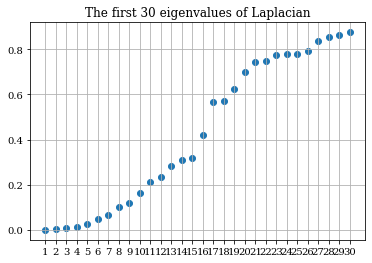

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.446
********************
Leave [149] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14090934825546264
Optimal number of clusters: 16


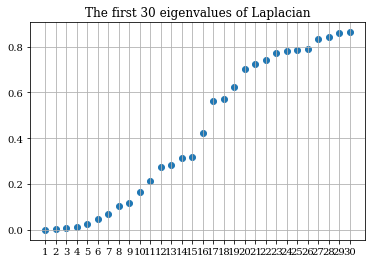

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.444
********************
Leave [150] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1443428349553264
Optimal number of clusters: 16


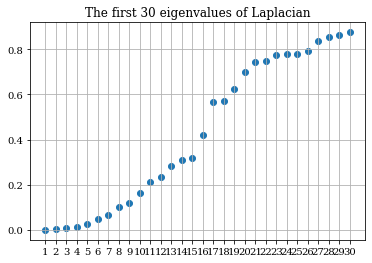

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.446
********************
Leave [151] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14125921100936023
Optimal number of clusters: 16


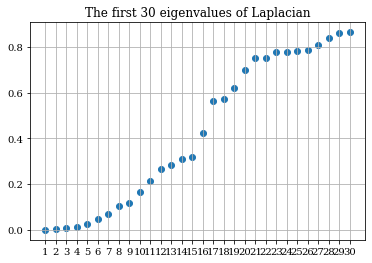

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.442
********************
Leave [152] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1412592110093609
Optimal number of clusters: 16


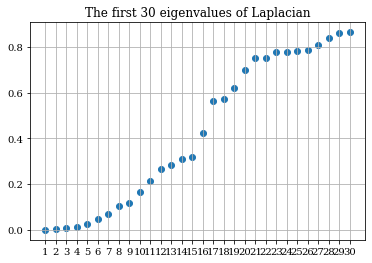

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.442
********************
Leave [153] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1412316389757038
Optimal number of clusters: 16


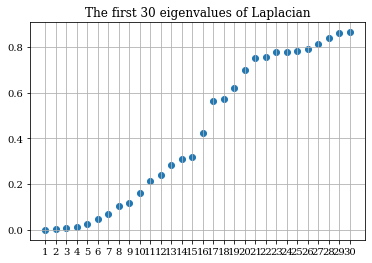

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.462 , Silhouette: 0.445
********************
Leave [154] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14150933646645902
Optimal number of clusters: 16


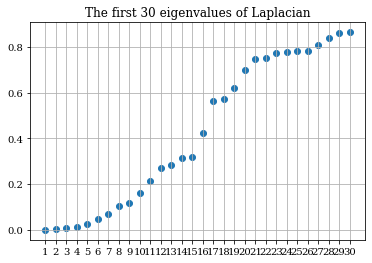

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [155] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1317907208848632
Optimal number of clusters: 16


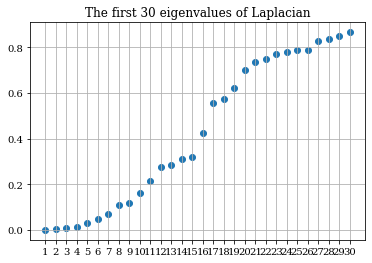

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.453 , Silhouette: 0.440
********************
Leave [156] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14415528566171454
Optimal number of clusters: 16


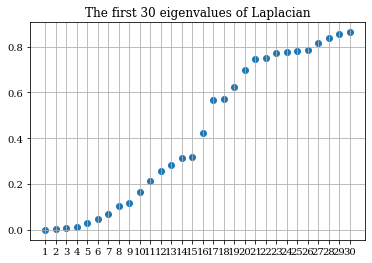

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.443
********************
Leave [157] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14401347198087433
Optimal number of clusters: 16


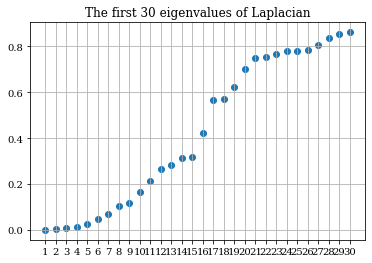

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.444
********************
Leave [158] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.131776367145642
Optimal number of clusters: 16


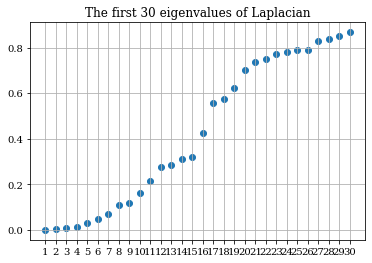

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.453 , Silhouette: 0.440
********************
Leave [159] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14151753817586332
Optimal number of clusters: 16


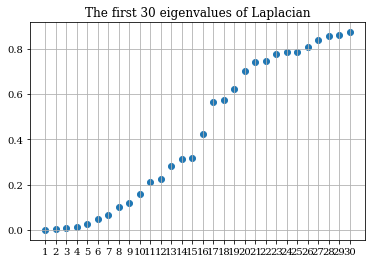

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.181 , NMI: 0.453 , Silhouette: 0.443
********************
Leave [160] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14377082334963687
Optimal number of clusters: 16


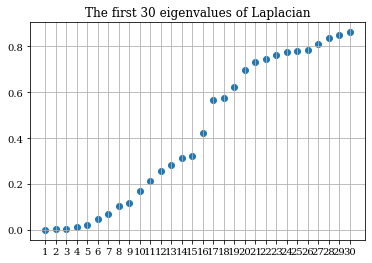

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.446
********************
Leave [161] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1456362310349728
Optimal number of clusters: 16


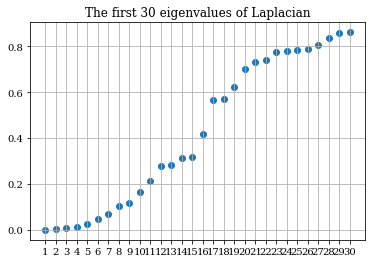

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.444
********************
Leave [162] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14131273922351606
Optimal number of clusters: 16


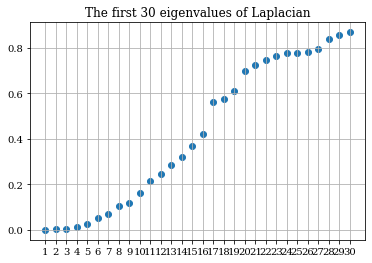

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.459 , Silhouette: 0.442
********************
Leave [163] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13760704203735297
Optimal number of clusters: 16


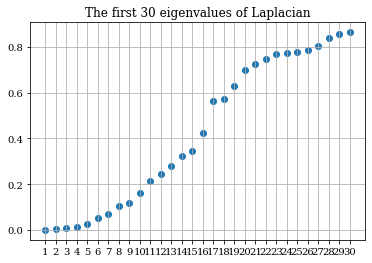

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.191 , NMI: 0.467 , Silhouette: 0.440
********************
Leave [164] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1376733302608204
Optimal number of clusters: 16


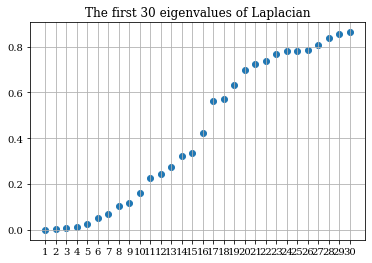

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.457 , Silhouette: 0.440
********************
Leave [165] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.16579057489140703
Optimal number of clusters: 15


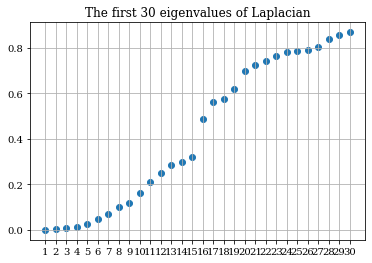

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.178 , NMI: 0.440 , Silhouette: 0.442
********************
Leave [166] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13852752010036107
Optimal number of clusters: 16


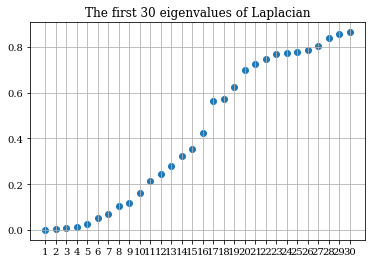

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.466 , Silhouette: 0.438
********************
Leave [167] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14190855028600424
Optimal number of clusters: 16


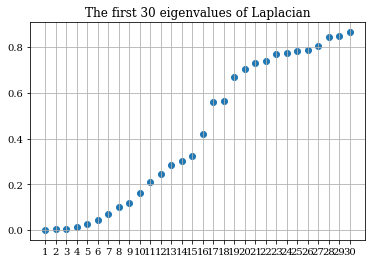

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.471 , Silhouette: 0.447
********************
Leave [168] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14409464019924778
Optimal number of clusters: 16


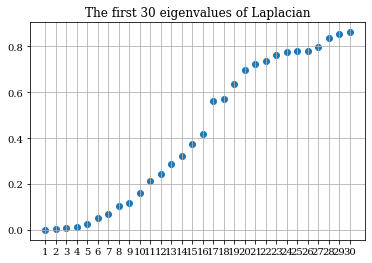

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.454 , Silhouette: 0.443
********************
Leave [169] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14152390430578365
Optimal number of clusters: 16


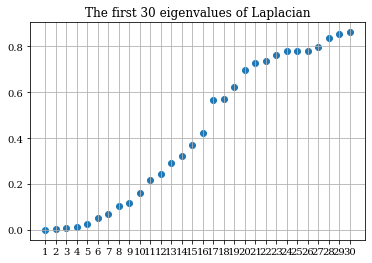

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.183 , NMI: 0.459 , Silhouette: 0.440
********************
Leave [170] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13982800295633835
Optimal number of clusters: 16


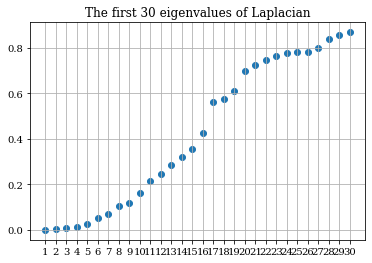

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.184 , NMI: 0.459 , Silhouette: 0.443
********************
Leave [171] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14018463165056572
Optimal number of clusters: 16


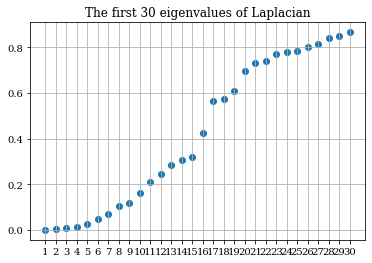

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.457 , Silhouette: 0.443
********************
Leave [172] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13799352782722174
Optimal number of clusters: 16


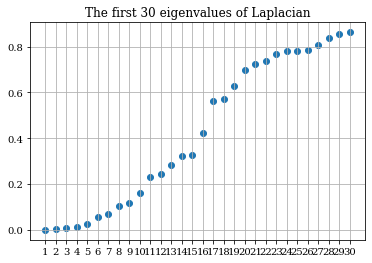

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.458 , Silhouette: 0.438
********************
Leave [173] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1379758594683096
Optimal number of clusters: 16


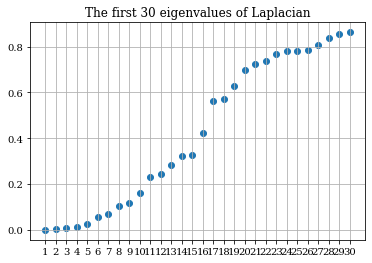

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.466 , Silhouette: 0.439
********************
Leave [174] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14079439669613203
Optimal number of clusters: 15


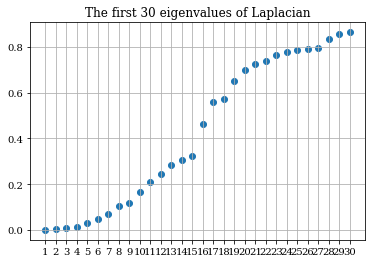

Cluster label predicted according to pharmacological categorization: K = 15
ARI 0.182 , NMI: 0.445 , Silhouette: 0.439
********************
Leave [175] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1368080468816848
Optimal number of clusters: 16


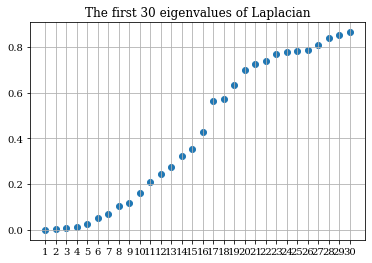

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.457 , Silhouette: 0.440
********************
Leave [176] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13415319493510447
Optimal number of clusters: 16


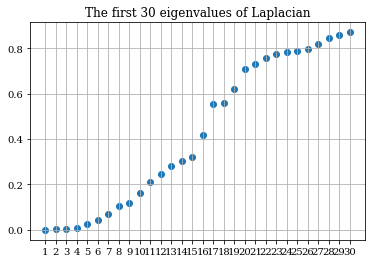

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.451 , Silhouette: 0.442
********************
Leave [177] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13788806409968601
Optimal number of clusters: 16


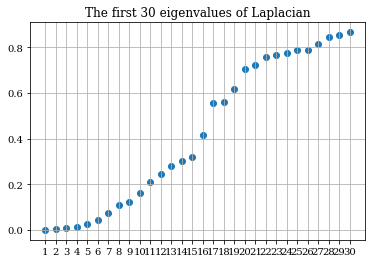

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.442
********************
Leave [178] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1446616530153797
Optimal number of clusters: 16


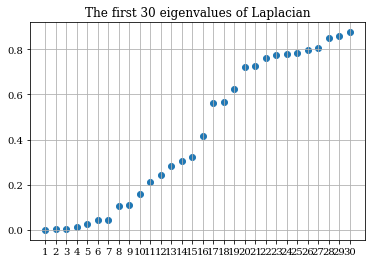

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.470 , Silhouette: 0.448
********************
Leave [179] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13788806409968557
Optimal number of clusters: 16


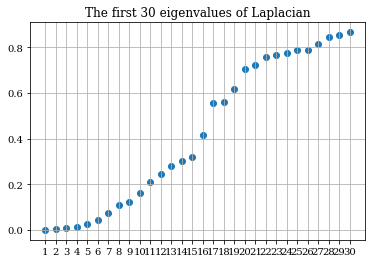

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.457 , Silhouette: 0.442
********************
Leave [180] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13437448852247091
Optimal number of clusters: 16


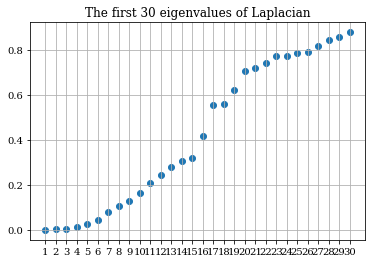

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.451 , Silhouette: 0.442
********************
Leave [181] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13415319493510913
Optimal number of clusters: 16


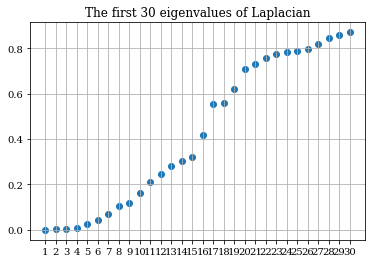

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.451 , Silhouette: 0.442
********************
Leave [182] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1413589313759993
Optimal number of clusters: 16


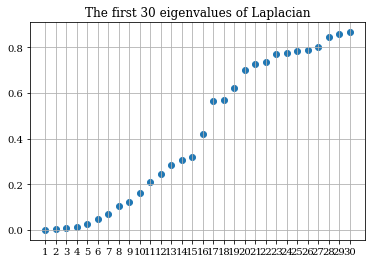

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.440
********************
Leave [183] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.1341838646522282
Optimal number of clusters: 16


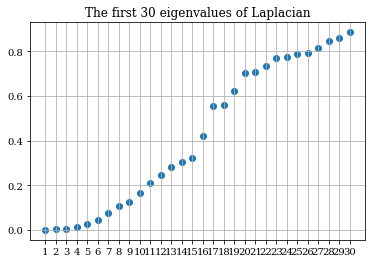

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.451 , Silhouette: 0.442
********************
Leave [184] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14627476685956187
Optimal number of clusters: 16


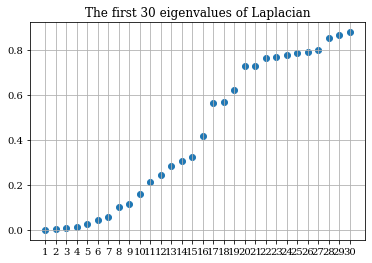

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.189 , NMI: 0.470 , Silhouette: 0.446
********************
Leave [185] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.14113994433764265
Optimal number of clusters: 16


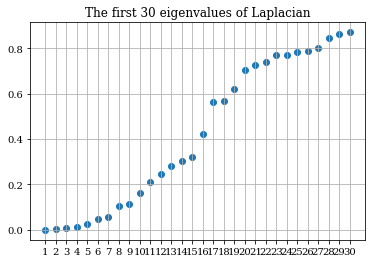

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.186 , NMI: 0.456 , Silhouette: 0.444
********************
Leave [186] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13187310451978473
Optimal number of clusters: 16


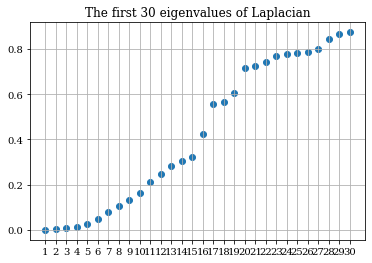

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.451 , Silhouette: 0.443
********************
Leave [187] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13187310451978385
Optimal number of clusters: 16


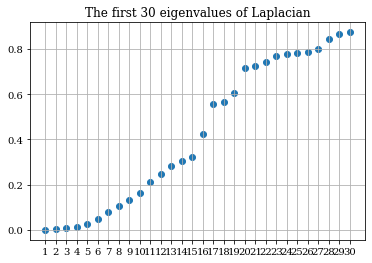

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.182 , NMI: 0.451 , Silhouette: 0.443
********************
Leave [188] out
188
SpectralClustering(affinity='nearest_neighbors', eigen_tol=0.001,
                   n_neighbors=11, random_state=13)
0.13179124522002184
Optimal number of clusters: 16


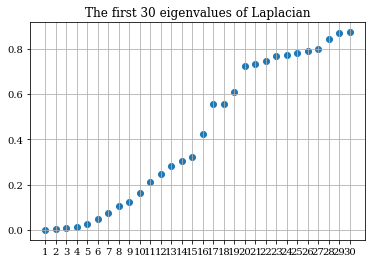

Cluster label predicted according to pharmacological categorization: K = 16
ARI 0.185 , NMI: 0.460 , Silhouette: 0.444
********************


In [600]:
folds = NPS_active.shape[0]
print("Total of ",folds,"evaluations")
LOO = LeaveOneOut()
opt_K_total, max_gap_total, ARI_total, NMI_total, sil_total = [],[],[],[],[]
for train_index, test_index in LOO.split(NPS_active):
    print("Leave", test_index, "out")
    NPS_train, NPS_test = NPS_active.iloc[train_index], NPS_active.iloc[test_index]
    print(NPS_train.shape[0])
    NPS_train.reset_index(drop=True, inplace=True)
    
    optimal_K, max_gap, ARI, NMI, sil = optimal_K_evaluation(NPS_train, rogot_goldberg,"RF_p7_maccs")
    #optimal_K, max_gap, ARI, NMI, sil = optimal_K_evaluation(NPS_train, tanimoto,"morganfp")
    opt_K_total.append(optimal_K)
    max_gap_total.append(max_gap)
    ARI_total.append(ARI)
    NMI_total.append(NMI)
    sil_total.append(sil)
    print("*"*20)

In [601]:
print("Optimal number of clusters determined using eigenvalue heuristic %0.3f" %(np.mean(opt_K_total)), "std %0.3f" %(np.std(opt_K_total)))
print("Average max eigenvalue gap %0.3f" %(np.mean(max_gap_total)), "std %0.3f" %(np.std(max_gap_total)))

print("ARI Pharmacological cluster label average %0.3f" %(np.mean(ARI_total)), "std %0.3f" %(np.std(ARI_total)))
print("NMI Pharmacological cluster label average %0.3f" %(np.mean(NMI_total)), "std %0.3f" %(np.std(NMI_total)))
print("Silhouettee Pharmacological cluster label average %0.3f" %(np.mean(sil_total)), "std %0.3f" %(np.std(sil_total)))

Optimal number of clusters determined using eigenvalue heuristic 15.931 std 0.253
Average max eigenvalue gap 0.136 std 0.008
ARI Pharmacological cluster label average 0.184 std 0.004
NMI Pharmacological cluster label average 0.457 std 0.007
Silhouettee Pharmacological cluster label average 0.442 std 0.003


In [909]:
folds = NPS_active.shape[0]
print("Total of ",folds,"evaluations")
LOO = LeaveOneOut()
ARI_MCS_total, NMI_MCS_total, sil_MCS_total,ARI_Ph_total, NMI_Ph_total, sil_Ph_total = [],[],[],[],[],[]
for train_index, test_index in LOO.split(NPS_active):
    print("Leave", test_index, "out")
    NPS_train, NPS_test = NPS_active.iloc[train_index], NPS_active.iloc[test_index]
    print(NPS_train.shape[0])
    NPS_train.reset_index(drop=True, inplace=True)
    
    #df_cid, df_pair = similarity_matrix(NPS_train, tanimoto,"maccsfp")
    df_cid, df_pair = similarity_matrix(NPS_train, rogot_goldberg,"RF_p7_maccs")
    
    # Cluster label according to maximum common core, form 17 clusters
    MCS_labels_pred = SpectralClustering(n_clusters=17,affinity='rbf',gamma=5.0,assign_labels='kmeans',random_state=13,eigen_tol=0.001).fit_predict(df_cid)
    ARI_MCS = adjusted_rand_score(NPS_train['MCS_K'], MCS_labels_pred) 
    NMI_MCS = adjusted_mutual_info_score(NPS_train['MCS_K'], MCS_labels_pred)
    sil_MCS = silhouette_score(df_cid.values, MCS_labels_pred, metric='euclidean')
    print("Cluster label predicted according to maximum common substructure cluster: K = 17")
    print("ARI %0.3f" %ARI_MCS, ", NMI: %0.3f" % NMI_MCS, ", Silhouette: %0.3f" %sil_MCS)
    
    # Cluster label according to pharmacological categorization, form 5 clusters
    Ph_labels_pred = SpectralClustering(n_clusters=5,affinity='rbf',gamma=5.0,assign_labels='kmeans',random_state=13,eigen_tol=0.001).fit_predict(df_cid)
    ARI_Ph = adjusted_rand_score(NPS_train['Pharm class label'], Ph_labels_pred) 
    NMI_Ph = adjusted_mutual_info_score(NPS_train['Pharm class label'], Ph_labels_pred)
    sil_Ph = silhouette_score(df_cid.values, Ph_labels_pred, metric='euclidean')
    print("Cluster label predicted according to pharmacological categorization: K = 5")
    print("ARI %0.3f" %ARI_Ph, ", NMI: %0.3f" % NMI_Ph, ", Silhouette: %0.3f" %sil_Ph)

    ARI_MCS_total.append(ARI_MCS)
    NMI_MCS_total.append(NMI_MCS)
    sil_MCS_total.append(sil_MCS)
    ARI_Ph_total.append(ARI_Ph)
    NMI_Ph_total.append(NMI_Ph)
    sil_Ph_total.append(sil_Ph)
    print("*"*20)

Total of  189 evaluations
Leave [0] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.413 , NMI: 0.613 , Silhouette: 0.509
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.171 , NMI: 0.259 , Silhouette: 0.193
********************
Leave [1] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.413 , NMI: 0.613 , Silhouette: 0.504
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.195 , NMI: 0.314 , Silhouette: 0.181
********************
Leave [2] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.409 , NMI: 0.611 , Silhouette: 0.497
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.115 , NMI: 0.299 , Silhouette: 0.118
********************
Leave [3] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.413 , NMI: 0.613 , Silhoue

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.410 , NMI: 0.611 , Silhouette: 0.495
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.070 , NMI: 0.225 , Silhouette: 0.086
********************
Leave [30] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.417 , NMI: 0.615 , Silhouette: 0.504
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.115 , NMI: 0.257 , Silhouette: 0.291
********************
Leave [31] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.210 , NMI: 0.494 , Silhouette: 0.133
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.108 , NMI: 0.249 , Silhouette: 0.181
********************
Leave [32] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.421 , NMI: 0.622 , Silhouette: 0.498
Cluster label predicted accord

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.299 , NMI: 0.554 , Silhouette: 0.233
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.078 , NMI: 0.278 , Silhouette: 0.178
********************
Leave [60] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.299 , NMI: 0.554 , Silhouette: 0.233
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.078 , NMI: 0.278 , Silhouette: 0.178
********************
Leave [61] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.432 , NMI: 0.629 , Silhouette: 0.488
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.078 , NMI: 0.278 , Silhouette: 0.175
********************
Leave [62] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.432 , NMI: 0.629 , Silhouette: 0.488
Cluster label predicted accord

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.418 , NMI: 0.616 , Silhouette: 0.498
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.085 , NMI: 0.291 , Silhouette: 0.180
********************
Leave [90] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.414 , NMI: 0.613 , Silhouette: 0.496
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.117 , NMI: 0.301 , Silhouette: 0.118
********************
Leave [91] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.414 , NMI: 0.613 , Silhouette: 0.495
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.080 , NMI: 0.287 , Silhouette: 0.174
********************
Leave [92] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.419 , NMI: 0.621 , Silhouette: 0.497
Cluster label predicted accord

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.432 , NMI: 0.621 , Silhouette: 0.498
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.121 , NMI: 0.304 , Silhouette: 0.120
********************
Leave [119] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.388 , NMI: 0.603 , Silhouette: 0.406
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.109 , NMI: 0.241 , Silhouette: 0.268
********************
Leave [120] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.415 , NMI: 0.613 , Silhouette: 0.497
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.106 , NMI: 0.237 , Silhouette: 0.158
********************
Leave [121] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.419 , NMI: 0.617 , Silhouette: 0.501
Cluster label predicted acc

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.407 , NMI: 0.612 , Silhouette: 0.495
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.117 , NMI: 0.302 , Silhouette: 0.121
********************
Leave [148] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.407 , NMI: 0.612 , Silhouette: 0.495
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.117 , NMI: 0.302 , Silhouette: 0.121
********************
Leave [149] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.243 , NMI: 0.516 , Silhouette: 0.111
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.117 , NMI: 0.302 , Silhouette: 0.121
********************
Leave [150] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.407 , NMI: 0.612 , Silhouette: 0.495
Cluster label predicted acc

Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.199 , NMI: 0.484 , Silhouette: 0.127
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.084 , NMI: 0.288 , Silhouette: 0.175
********************
Leave [177] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.199 , NMI: 0.484 , Silhouette: 0.126
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.118 , NMI: 0.256 , Silhouette: 0.296
********************
Leave [178] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.419 , NMI: 0.616 , Silhouette: 0.500
Cluster label predicted according to pharmacological categorization: K = 5
ARI 0.057 , NMI: 0.253 , Silhouette: 0.125
********************
Leave [179] out
188
Cluster label predicted according to maximum common substructure cluster: K = 17
ARI 0.199 , NMI: 0.484 , Silhouette: 0.126
Cluster label predicted acc

In [910]:
print("ARI MCS cluster label average %0.3f" %(np.mean(ARI_MCS_total)), "std %0.3f" %(np.std(ARI_MCS_total)))
print("NMI MCS cluster label average %0.3f" %(np.mean(NMI_MCS_total)), "std %0.3f" %(np.std(NMI_MCS_total)))
print("Silhouettee MCS cluster label average %0.3f" %(np.mean(sil_MCS_total)), "std %0.3f" %(np.std(sil_MCS_total)))
print("*"*20)
print("ARI Pharmacological cluster label average %0.3f" %(np.mean(ARI_Ph_total)), "std %0.3f" %(np.std(ARI_Ph_total)))
print("NMI Pharmacological cluster label average %0.3f" %(np.mean(NMI_Ph_total)), "std %0.3f" %(np.std(NMI_Ph_total)))
print("Silhouettee Pharmacological cluster label average %0.3f" %(np.mean(sil_Ph_total)), "std %0.3f" %(np.std(sil_Ph_total)))

ARI MCS cluster label average 0.350 std 0.096
NMI MCS cluster label average 0.574 std 0.063
Silhouettee MCS cluster label average 0.374 std 0.175
********************
ARI Pharmacological cluster label average 0.107 std 0.031
NMI Pharmacological cluster label average 0.281 std 0.031
Silhouettee Pharmacological cluster label average 0.154 std 0.055


### Final evaluation of spectral by varying K
* MACCS
* Morgan
* Ph-fp 
* Mol_fp

In [85]:
for i in range(df_result.shape[0]):
    K = i+2
    print("Requested number of clusters", K)
    
    LOO = LeaveOneOut()
    ARI_K_total, NMI_K_total, sil_K_total = [],[],[]
    for train_index, test_index in LOO.split(NPS_active):
        print("Leave", test_index, "out")
        Mol_fp_train, NPS_Pharm_label= df_Mol_fp_cid.iloc[train_index], NPS_active.iloc[train_index]

        # Cluster label according to pharmacological categorization, form 5 clusters
        Ph_labels_pred = SpectralClustering(n_clusters=K,affinity='rbf',gamma=1.0,assign_labels='kmeans',random_state=13,eigen_tol=0.001).fit_predict(Mol_fp_train)
        ARI = adjusted_rand_score(NPS_Pharm_label['Pharm class label'], Ph_labels_pred) 
        NMI = adjusted_mutual_info_score(NPS_Pharm_label['Pharm class label'], Ph_labels_pred)
        sil = silhouette_score(X,Ph_labels_pred,metric="euclidean")
    
        ARI_K_total.append(ARI)
        NMI_K_total.append(NMI)
        sil_K_total.append(sil)
    df_result.loc[i,"Spec_"+"Mol_fp"+"_ARI"]=np.mean(ARI_K_total)
    df_result.loc[i,"Spec_"+"Mol_fp"+"_NMI"]=np.mean(NMI_K_total)
    df_result.loc[i,"Spec_"+"Mol_fp"+"_Sil"]=np.mean(sil_K_total)

Requested number of clusters 2
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leav

Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 5
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] o

Leave [112] out
Leave [113] out
Leave [114] out
Leave [115] out
Leave [116] out
Leave [117] out
Leave [118] out
Leave [119] out
Leave [120] out
Leave [121] out
Leave [122] out
Leave [123] out
Leave [124] out
Leave [125] out
Leave [126] out
Leave [127] out
Leave [128] out
Leave [129] out
Leave [130] out
Leave [131] out
Leave [132] out
Leave [133] out
Leave [134] out
Leave [135] out
Leave [136] out
Leave [137] out
Leave [138] out
Leave [139] out
Leave [140] out
Leave [141] out
Leave [142] out
Leave [143] out
Leave [144] out
Leave [145] out
Leave [146] out
Leave [147] out
Leave [148] out
Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [1

Leave [72] out
Leave [73] out
Leave [74] out
Leave [75] out
Leave [76] out
Leave [77] out
Leave [78] out
Leave [79] out
Leave [80] out
Leave [81] out
Leave [82] out
Leave [83] out
Leave [84] out
Leave [85] out
Leave [86] out
Leave [87] out
Leave [88] out
Leave [89] out
Leave [90] out
Leave [91] out
Leave [92] out
Leave [93] out
Leave [94] out
Leave [95] out
Leave [96] out
Leave [97] out
Leave [98] out
Leave [99] out
Leave [100] out
Leave [101] out
Leave [102] out
Leave [103] out
Leave [104] out
Leave [105] out
Leave [106] out
Leave [107] out
Leave [108] out
Leave [109] out
Leave [110] out
Leave [111] out
Leave [112] out
Leave [113] out
Leave [114] out
Leave [115] out
Leave [116] out
Leave [117] out
Leave [118] out
Leave [119] out
Leave [120] out
Leave [121] out
Leave [122] out
Leave [123] out
Leave [124] out
Leave [125] out
Leave [126] out
Leave [127] out
Leave [128] out
Leave [129] out
Leave [130] out
Leave [131] out
Leave [132] out
Leave [133] out
Leave [134] out
Leave [135] out
Leav

Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56] out
Leave [57] out
Leave [58] out
Leave [59] out
Leave [60] out
Leave [61] out
Leave [62] out
Leave [63] out
Leave [64] out
Leave [65] out
Leave [66] out
Leave [67] out
Leave [68] out
Leave [69] out
Leave [70] out
Leave [71] out
Leave [72] out
Leave [73] out
Leave [74] out
Leave [75] out
Leave [76] out
Leave [77] out
Leave [78] out
Leave [79] out
Leave [80] out
Leave [81] out
Leave [82] out
Leave [83] out
Leave [84] out
Leave [85] out
Leave [86] out
Leave [87] out
Leave [88] out
Leave [89] out
Leave [90] out
Leave [91] out
Leave [92] out
Leave [93] out
Leave [94] out
Leave [95] out
Leave [96]

Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 16
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
Leave [15] out
Leave [16] out
Leave [17] out
Leave [18] out
Leave [19] out
Leave [20] out
Leave [21] out
Leave [22] out
Leave [23] out
Leave [24] out
Leave [25] out
Leave [26] out
Leave [27] out
Leave [28] out
Leave [29] out
Leave [30] out
Leave [31] out
Leave [32] out
Leave [33] out
Leave [34] out
Leave [35] out
Leave [36] out
Leave [37] out
Leave [38] out
Leave [39] out
Leave [40] out
Leave [41] out
Leave [42] out
Leave [43] out
Leave [44] out
Leave [45] out
Leave [46] out
Leave [47] out
Leave [48] out
Leave [49] out
Leave [50] out
Leave [51] out
Leave [52] out
Leave [53] out
Leave [54] out
Leave [55] out
Leave [56]

Leave [142] out
Leave [143] out
Leave [144] out
Leave [145] out
Leave [146] out
Leave [147] out
Leave [148] out
Leave [149] out
Leave [150] out
Leave [151] out
Leave [152] out
Leave [153] out
Leave [154] out
Leave [155] out
Leave [156] out
Leave [157] out
Leave [158] out
Leave [159] out
Leave [160] out
Leave [161] out
Leave [162] out
Leave [163] out
Leave [164] out
Leave [165] out
Leave [166] out
Leave [167] out
Leave [168] out
Leave [169] out
Leave [170] out
Leave [171] out
Leave [172] out
Leave [173] out
Leave [174] out
Leave [175] out
Leave [176] out
Leave [177] out
Leave [178] out
Leave [179] out
Leave [180] out
Leave [181] out
Leave [182] out
Leave [183] out
Leave [184] out
Leave [185] out
Leave [186] out
Leave [187] out
Leave [188] out
Requested number of clusters 19
Leave [0] out
Leave [1] out
Leave [2] out
Leave [3] out
Leave [4] out
Leave [5] out
Leave [6] out
Leave [7] out
Leave [8] out
Leave [9] out
Leave [10] out
Leave [11] out
Leave [12] out
Leave [13] out
Leave [14] out
L

In [985]:
fingerprint = "RF_p5_maccs"
similarity = rogot_goldberg
#similarity = tanimoto

for i in range(df_result.shape[0]):
    K = i+2
    print("Requested number of clusters", K)
    
    LOO = LeaveOneOut()
    ARI_K_total, NMI_K_total, sil_K_total = [],[],[]
    for train_index, test_index in LOO.split(NPS_active):
        print("Leave", test_index, "out")
        NPS_train, NPS_test = NPS_active.iloc[train_index], NPS_active.iloc[test_index]
        #print(NPS_train.shape[0])
        NPS_train.reset_index(drop=True, inplace=True)
    
        df_cid, df_pair = similarity_matrix(NPS_train,similarity,fingerprint)
        
        # Cluster label according to pharmacological categorization, form 5 clusters
        Ph_labels_pred = SpectralClustering(n_clusters=K,affinity='rbf',gamma=1.0,assign_labels='kmeans',random_state=13,eigen_tol=0.001).fit_predict(df_cid)
        ARI = adjusted_rand_score(NPS_train['Pharm class label'], Ph_labels_pred) 
        NMI = adjusted_mutual_info_score(NPS_train['Pharm class label'], Ph_labels_pred)
        sil = silhouette_score(df_cid.values, Ph_labels_pred, metric='euclidean')
        print("ARI %0.3f" %ARI, ", NMI: %0.3f" % NMI, ", Silhouette: %0.3f" %sil)
    
        ARI_K_total.append(ARI)
        NMI_K_total.append(NMI)
        sil_K_total.append(sil)
    
    df_result.loc[i,"Spec_"+fingerprint+"_ARI"]=np.mean(ARI_K_total)
    df_result.loc[i,"Spec_"+fingerprint+"_NMI"]=np.mean(NMI_K_total)
    df_result.loc[i,"Spec_"+fingerprint+"_Sil"]=np.mean(sil_K_total)

Requested number of clusters 2
Leave [0] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.413
Leave [1] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [2] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.414
Leave [3] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [4] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.414
Leave [5] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [6] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [7] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [8] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [9] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.416
Leave [10] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.415
Leave [11] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.412
Leave [12] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.417
Leave [13] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.417
Leave [14] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.417
Leave [15] out
ARI 0.201 , NMI: 0.294 , Silhouette: 0.417
Leave [16] out
ARI 0.201 , NMI: 0.294 , Silhouette:

ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [141] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [142] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [143] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [144] out
ARI 0.201 , NMI: 0.305 , Silhouette: 0.410
Leave [145] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [146] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [147] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [148] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [149] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [150] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [151] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [152] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [153] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [154] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [155] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [156] out
ARI 0.199 , NMI: 0.293 , Silhouette: 0.410
Leave [157] o

ARI 0.311 , NMI: 0.375 , Silhouette: 0.577
Leave [93] out
ARI 0.311 , NMI: 0.375 , Silhouette: 0.577
Leave [94] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [95] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [96] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [97] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [98] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [99] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.581
Leave [100] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [101] out
ARI 0.312 , NMI: 0.373 , Silhouette: 0.578
Leave [102] out
ARI 0.319 , NMI: 0.380 , Silhouette: 0.578
Leave [103] out
ARI 0.319 , NMI: 0.380 , Silhouette: 0.579
Leave [104] out
ARI 0.319 , NMI: 0.380 , Silhouette: 0.578
Leave [105] out
ARI 0.319 , NMI: 0.380 , Silhouette: 0.579
Leave [106] out
ARI 0.319 , NMI: 0.380 , Silhouette: 0.579
Leave [107] out
ARI 0.316 , NMI: 0.392 , Silhouette: 0.576
Leave [108] out
ARI 0.319 , NMI: 0.380 , Silhouette: 0.579
Leave [109] out
ARI 

ARI 0.335 , NMI: 0.430 , Silhouette: 0.543
Leave [44] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.540
Leave [45] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.540
Leave [46] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.541
Leave [47] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.541
Leave [48] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.540
Leave [49] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.540
Leave [50] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.539
Leave [51] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.541
Leave [52] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.541
Leave [53] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.540
Leave [54] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.542
Leave [55] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.542
Leave [56] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.542
Leave [57] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.542
Leave [58] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.541
Leave [59] out
ARI 0.335 , NMI: 0.430 , Silhouette: 0.541
Leave [60] out
ARI 0.335 , NM

ARI 0.335 , NMI: 0.427 , Silhouette: 0.539
Leave [184] out
ARI 0.335 , NMI: 0.427 , Silhouette: 0.539
Leave [185] out
ARI 0.335 , NMI: 0.427 , Silhouette: 0.541
Leave [186] out
ARI 0.335 , NMI: 0.427 , Silhouette: 0.541
Leave [187] out
ARI 0.335 , NMI: 0.427 , Silhouette: 0.541
Leave [188] out
ARI 0.335 , NMI: 0.427 , Silhouette: 0.541
Requested number of clusters 5
Leave [0] out
ARI 0.254 , NMI: 0.423 , Silhouette: 0.455
Leave [1] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.450
Leave [2] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.453
Leave [3] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.450
Leave [4] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.453
Leave [5] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.451
Leave [6] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.451
Leave [7] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.451
Leave [8] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.451
Leave [9] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.452
Leave [10] out
ARI 0.249 , NMI: 0.412 , Silhouette: 0.451
Lea

ARI 0.257 , NMI: 0.430 , Silhouette: 0.454
Leave [136] out
ARI 0.341 , NMI: 0.438 , Silhouette: 0.512
Leave [137] out
ARI 0.254 , NMI: 0.418 , Silhouette: 0.453
Leave [138] out
ARI 0.341 , NMI: 0.438 , Silhouette: 0.512
Leave [139] out
ARI 0.254 , NMI: 0.418 , Silhouette: 0.453
Leave [140] out
ARI 0.341 , NMI: 0.438 , Silhouette: 0.512
Leave [141] out
ARI 0.254 , NMI: 0.418 , Silhouette: 0.453
Leave [142] out
ARI 0.341 , NMI: 0.438 , Silhouette: 0.512
Leave [143] out
ARI 0.341 , NMI: 0.438 , Silhouette: 0.512
Leave [144] out
ARI 0.342 , NMI: 0.446 , Silhouette: 0.511
Leave [145] out
ARI 0.341 , NMI: 0.438 , Silhouette: 0.512
Leave [146] out
ARI 0.238 , NMI: 0.376 , Silhouette: 0.444
Leave [147] out
ARI 0.254 , NMI: 0.418 , Silhouette: 0.452
Leave [148] out
ARI 0.243 , NMI: 0.375 , Silhouette: 0.449
Leave [149] out
ARI 0.254 , NMI: 0.418 , Silhouette: 0.452
Leave [150] out
ARI 0.243 , NMI: 0.375 , Silhouette: 0.449
Leave [151] out
ARI 0.254 , NMI: 0.418 , Silhouette: 0.452
Leave [152] o

ARI 0.245 , NMI: 0.417 , Silhouette: 0.421
Leave [87] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.421
Leave [88] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.418
Leave [89] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.418
Leave [90] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.420
Leave [91] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.420
Leave [92] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.422
Leave [93] out
ARI 0.245 , NMI: 0.417 , Silhouette: 0.423
Leave [94] out
ARI 0.247 , NMI: 0.405 , Silhouette: 0.421
Leave [95] out
ARI 0.247 , NMI: 0.405 , Silhouette: 0.421
Leave [96] out
ARI 0.247 , NMI: 0.405 , Silhouette: 0.421
Leave [97] out
ARI 0.250 , NMI: 0.420 , Silhouette: 0.420
Leave [98] out
ARI 0.250 , NMI: 0.420 , Silhouette: 0.420
Leave [99] out
ARI 0.250 , NMI: 0.420 , Silhouette: 0.427
Leave [100] out
ARI 0.250 , NMI: 0.420 , Silhouette: 0.423
Leave [101] out
ARI 0.247 , NMI: 0.408 , Silhouette: 0.422
Leave [102] out
ARI 0.250 , NMI: 0.420 , Silhouette: 0.420
Leave [103] out
ARI 0.250 

ARI 0.235 , NMI: 0.400 , Silhouette: 0.425
Leave [38] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.416
Leave [39] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.417
Leave [40] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.416
Leave [41] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.418
Leave [42] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.419
Leave [43] out
ARI 0.295 , NMI: 0.463 , Silhouette: 0.436
Leave [44] out
ARI 0.233 , NMI: 0.405 , Silhouette: 0.422
Leave [45] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.419
Leave [46] out
ARI 0.233 , NMI: 0.405 , Silhouette: 0.412
Leave [47] out
ARI 0.233 , NMI: 0.405 , Silhouette: 0.412
Leave [48] out
ARI 0.236 , NMI: 0.398 , Silhouette: 0.429
Leave [49] out
ARI 0.234 , NMI: 0.404 , Silhouette: 0.422
Leave [50] out
ARI 0.233 , NMI: 0.406 , Silhouette: 0.420
Leave [51] out
ARI 0.233 , NMI: 0.405 , Silhouette: 0.412
Leave [52] out
ARI 0.233 , NMI: 0.405 , Silhouette: 0.412
Leave [53] out
ARI 0.233 , NMI: 0.405 , Silhouette: 0.420
Leave [54] out
ARI 0.240 , NM

ARI 0.230 , NMI: 0.402 , Silhouette: 0.418
Leave [178] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.418
Leave [179] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.417
Leave [180] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.418
Leave [181] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.417
Leave [182] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.415
Leave [183] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.415
Leave [184] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.415
Leave [185] out
ARI 0.237 , NMI: 0.408 , Silhouette: 0.424
Leave [186] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.417
Leave [187] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.417
Leave [188] out
ARI 0.230 , NMI: 0.402 , Silhouette: 0.417
Requested number of clusters 8
Leave [0] out
ARI 0.280 , NMI: 0.456 , Silhouette: 0.434
Leave [1] out
ARI 0.276 , NMI: 0.447 , Silhouette: 0.430
Leave [2] out
ARI 0.276 , NMI: 0.447 , Silhouette: 0.433
Leave [3] out
ARI 0.276 , NMI: 0.447 , Silhouette: 0.430
Leave [4] out
ARI 0.276 , NMI: 0.447 , Silhouette

ARI 0.286 , NMI: 0.468 , Silhouette: 0.429
Leave [130] out
ARI 0.278 , NMI: 0.450 , Silhouette: 0.431
Leave [131] out
ARI 0.278 , NMI: 0.450 , Silhouette: 0.431
Leave [132] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.427
Leave [133] out
ARI 0.277 , NMI: 0.450 , Silhouette: 0.429
Leave [134] out
ARI 0.281 , NMI: 0.452 , Silhouette: 0.431
Leave [135] out
ARI 0.286 , NMI: 0.472 , Silhouette: 0.429
Leave [136] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.426
Leave [137] out
ARI 0.281 , NMI: 0.452 , Silhouette: 0.429
Leave [138] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.426
Leave [139] out
ARI 0.281 , NMI: 0.452 , Silhouette: 0.430
Leave [140] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.426
Leave [141] out
ARI 0.281 , NMI: 0.452 , Silhouette: 0.429
Leave [142] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.426
Leave [143] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.426
Leave [144] out
ARI 0.282 , NMI: 0.455 , Silhouette: 0.426
Leave [145] out
ARI 0.277 , NMI: 0.447 , Silhouette: 0.426
Leave [146] o

ARI 0.262 , NMI: 0.438 , Silhouette: 0.405
Leave [81] out
ARI 0.262 , NMI: 0.438 , Silhouette: 0.406
Leave [82] out
ARI 0.268 , NMI: 0.445 , Silhouette: 0.417
Leave [83] out
ARI 0.268 , NMI: 0.445 , Silhouette: 0.416
Leave [84] out
ARI 0.267 , NMI: 0.441 , Silhouette: 0.412
Leave [85] out
ARI 0.267 , NMI: 0.441 , Silhouette: 0.412
Leave [86] out
ARI 0.267 , NMI: 0.441 , Silhouette: 0.412
Leave [87] out
ARI 0.267 , NMI: 0.441 , Silhouette: 0.412
Leave [88] out
ARI 0.275 , NMI: 0.448 , Silhouette: 0.418
Leave [89] out
ARI 0.275 , NMI: 0.448 , Silhouette: 0.418
Leave [90] out
ARI 0.268 , NMI: 0.445 , Silhouette: 0.416
Leave [91] out
ARI 0.268 , NMI: 0.445 , Silhouette: 0.416
Leave [92] out
ARI 0.268 , NMI: 0.445 , Silhouette: 0.419
Leave [93] out
ARI 0.268 , NMI: 0.445 , Silhouette: 0.419
Leave [94] out
ARI 0.266 , NMI: 0.439 , Silhouette: 0.405
Leave [95] out
ARI 0.266 , NMI: 0.439 , Silhouette: 0.405
Leave [96] out
ARI 0.266 , NMI: 0.439 , Silhouette: 0.405
Leave [97] out
ARI 0.270 , NM

ARI 0.273 , NMI: 0.451 , Silhouette: 0.409
Leave [32] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.419
Leave [33] out
ARI 0.269 , NMI: 0.450 , Silhouette: 0.411
Leave [34] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.416
Leave [35] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.414
Leave [36] out
ARI 0.269 , NMI: 0.450 , Silhouette: 0.411
Leave [37] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.416
Leave [38] out
ARI 0.269 , NMI: 0.450 , Silhouette: 0.410
Leave [39] out
ARI 0.270 , NMI: 0.453 , Silhouette: 0.416
Leave [40] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.414
Leave [41] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.415
Leave [42] out
ARI 0.273 , NMI: 0.454 , Silhouette: 0.417
Leave [43] out
ARI 0.274 , NMI: 0.450 , Silhouette: 0.414
Leave [44] out
ARI 0.270 , NMI: 0.449 , Silhouette: 0.414
Leave [45] out
ARI 0.270 , NMI: 0.449 , Silhouette: 0.411
Leave [46] out
ARI 0.275 , NMI: 0.450 , Silhouette: 0.406
Leave [47] out
ARI 0.275 , NMI: 0.450 , Silhouette: 0.406
Leave [48] out
ARI 0.273 , NM

ARI 0.305 , NMI: 0.470 , Silhouette: 0.440
Leave [173] out
ARI 0.305 , NMI: 0.470 , Silhouette: 0.440
Leave [174] out
ARI 0.270 , NMI: 0.449 , Silhouette: 0.412
Leave [175] out
ARI 0.290 , NMI: 0.453 , Silhouette: 0.425
Leave [176] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Leave [177] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Leave [178] out
ARI 0.269 , NMI: 0.452 , Silhouette: 0.419
Leave [179] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Leave [180] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Leave [181] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Leave [182] out
ARI 0.269 , NMI: 0.452 , Silhouette: 0.416
Leave [183] out
ARI 0.269 , NMI: 0.452 , Silhouette: 0.416
Leave [184] out
ARI 0.269 , NMI: 0.452 , Silhouette: 0.416
Leave [185] out
ARI 0.271 , NMI: 0.458 , Silhouette: 0.414
Leave [186] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.424
Leave [187] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Leave [188] out
ARI 0.289 , NMI: 0.454 , Silhouette: 0.425
Requested num

ARI 0.295 , NMI: 0.465 , Silhouette: 0.424
Leave [125] out
ARI 0.295 , NMI: 0.467 , Silhouette: 0.423
Leave [126] out
ARI 0.295 , NMI: 0.465 , Silhouette: 0.423
Leave [127] out
ARI 0.295 , NMI: 0.465 , Silhouette: 0.423
Leave [128] out
ARI 0.295 , NMI: 0.465 , Silhouette: 0.423
Leave [129] out
ARI 0.299 , NMI: 0.480 , Silhouette: 0.427
Leave [130] out
ARI 0.295 , NMI: 0.465 , Silhouette: 0.423
Leave [131] out
ARI 0.295 , NMI: 0.465 , Silhouette: 0.424
Leave [132] out
ARI 0.291 , NMI: 0.463 , Silhouette: 0.422
Leave [133] out
ARI 0.291 , NMI: 0.463 , Silhouette: 0.425
Leave [134] out
ARI 0.308 , NMI: 0.474 , Silhouette: 0.423
Leave [135] out
ARI 0.299 , NMI: 0.476 , Silhouette: 0.426
Leave [136] out
ARI 0.291 , NMI: 0.463 , Silhouette: 0.421
Leave [137] out
ARI 0.299 , NMI: 0.469 , Silhouette: 0.423
Leave [138] out
ARI 0.291 , NMI: 0.463 , Silhouette: 0.421
Leave [139] out
ARI 0.299 , NMI: 0.469 , Silhouette: 0.423
Leave [140] out
ARI 0.291 , NMI: 0.463 , Silhouette: 0.421
Leave [141] o

ARI 0.285 , NMI: 0.474 , Silhouette: 0.422
Leave [76] out
ARI 0.284 , NMI: 0.473 , Silhouette: 0.423
Leave [77] out
ARI 0.285 , NMI: 0.474 , Silhouette: 0.422
Leave [78] out
ARI 0.280 , NMI: 0.472 , Silhouette: 0.424
Leave [79] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [80] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.432
Leave [81] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.430
Leave [82] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.430
Leave [83] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.430
Leave [84] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [85] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [86] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [87] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [88] out
ARI 0.311 , NMI: 0.498 , Silhouette: 0.434
Leave [89] out
ARI 0.311 , NMI: 0.498 , Silhouette: 0.434
Leave [90] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [91] out
ARI 0.303 , NMI: 0.494 , Silhouette: 0.431
Leave [92] out
ARI 0.303 , NM

ARI 0.292 , NMI: 0.503 , Silhouette: 0.429
Leave [27] out
ARI 0.308 , NMI: 0.514 , Silhouette: 0.427
Leave [28] out
ARI 0.314 , NMI: 0.519 , Silhouette: 0.423
Leave [29] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.427
Leave [30] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.424
Leave [31] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.424
Leave [32] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.430
Leave [33] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.424
Leave [34] out
ARI 0.302 , NMI: 0.510 , Silhouette: 0.423
Leave [35] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.424
Leave [36] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.425
Leave [37] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.426
Leave [38] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.423
Leave [39] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.424
Leave [40] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.424
Leave [41] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.425
Leave [42] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.426
Leave [43] out
ARI 0.292 , NM

ARI 0.292 , NMI: 0.503 , Silhouette: 0.429
Leave [168] out
ARI 0.292 , NMI: 0.502 , Silhouette: 0.428
Leave [169] out
ARI 0.292 , NMI: 0.502 , Silhouette: 0.428
Leave [170] out
ARI 0.294 , NMI: 0.503 , Silhouette: 0.425
Leave [171] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.426
Leave [172] out
ARI 0.291 , NMI: 0.502 , Silhouette: 0.423
Leave [173] out
ARI 0.291 , NMI: 0.502 , Silhouette: 0.423
Leave [174] out
ARI 0.292 , NMI: 0.503 , Silhouette: 0.427
Leave [175] out
ARI 0.292 , NMI: 0.502 , Silhouette: 0.427
Leave [176] out
ARI 0.290 , NMI: 0.499 , Silhouette: 0.423
Leave [177] out
ARI 0.290 , NMI: 0.499 , Silhouette: 0.422
Leave [178] out
ARI 0.301 , NMI: 0.507 , Silhouette: 0.423
Leave [179] out
ARI 0.290 , NMI: 0.499 , Silhouette: 0.424
Leave [180] out
ARI 0.301 , NMI: 0.507 , Silhouette: 0.423
Leave [181] out
ARI 0.290 , NMI: 0.499 , Silhouette: 0.423
Leave [182] out
ARI 0.301 , NMI: 0.507 , Silhouette: 0.420
Leave [183] out
ARI 0.301 , NMI: 0.507 , Silhouette: 0.420
Leave [184] o

ARI 0.244 , NMI: 0.482 , Silhouette: 0.397
Leave [120] out
ARI 0.244 , NMI: 0.482 , Silhouette: 0.400
Leave [121] out
ARI 0.314 , NMI: 0.504 , Silhouette: 0.447
Leave [122] out
ARI 0.329 , NMI: 0.518 , Silhouette: 0.442
Leave [123] out
ARI 0.271 , NMI: 0.483 , Silhouette: 0.415
Leave [124] out
ARI 0.271 , NMI: 0.483 , Silhouette: 0.415
Leave [125] out
ARI 0.271 , NMI: 0.483 , Silhouette: 0.415
Leave [126] out
ARI 0.372 , NMI: 0.543 , Silhouette: 0.437
Leave [127] out
ARI 0.372 , NMI: 0.543 , Silhouette: 0.437
Leave [128] out
ARI 0.372 , NMI: 0.543 , Silhouette: 0.437
Leave [129] out
ARI 0.246 , NMI: 0.483 , Silhouette: 0.397
Leave [130] out
ARI 0.372 , NMI: 0.543 , Silhouette: 0.437
Leave [131] out
ARI 0.372 , NMI: 0.543 , Silhouette: 0.438
Leave [132] out
ARI 0.245 , NMI: 0.481 , Silhouette: 0.400
Leave [133] out
ARI 0.244 , NMI: 0.479 , Silhouette: 0.395
Leave [134] out
ARI 0.346 , NMI: 0.533 , Silhouette: 0.437
Leave [135] out
ARI 0.336 , NMI: 0.534 , Silhouette: 0.441
Leave [136] o

ARI 0.364 , NMI: 0.539 , Silhouette: 0.449
Leave [71] out
ARI 0.486 , NMI: 0.568 , Silhouette: 0.401
Leave [72] out
ARI 0.500 , NMI: 0.581 , Silhouette: 0.401
Leave [73] out
ARI 0.281 , NMI: 0.497 , Silhouette: 0.418
Leave [74] out
ARI 0.276 , NMI: 0.487 , Silhouette: 0.389
Leave [75] out
ARI 0.307 , NMI: 0.510 , Silhouette: 0.447
Leave [76] out
ARI 0.247 , NMI: 0.482 , Silhouette: 0.404
Leave [77] out
ARI 0.324 , NMI: 0.519 , Silhouette: 0.446
Leave [78] out
ARI 0.244 , NMI: 0.481 , Silhouette: 0.402
Leave [79] out
ARI 0.271 , NMI: 0.488 , Silhouette: 0.411
Leave [80] out
ARI 0.271 , NMI: 0.488 , Silhouette: 0.411
Leave [81] out
ARI 0.274 , NMI: 0.487 , Silhouette: 0.416
Leave [82] out
ARI 0.273 , NMI: 0.485 , Silhouette: 0.416
Leave [83] out
ARI 0.274 , NMI: 0.487 , Silhouette: 0.415
Leave [84] out
ARI 0.272 , NMI: 0.484 , Silhouette: 0.416
Leave [85] out
ARI 0.272 , NMI: 0.484 , Silhouette: 0.416
Leave [86] out
ARI 0.272 , NMI: 0.484 , Silhouette: 0.416
Leave [87] out
ARI 0.272 , NM

ARI 0.363 , NMI: 0.550 , Silhouette: 0.458
Leave [22] out
ARI 0.363 , NMI: 0.550 , Silhouette: 0.458
Leave [23] out
ARI 0.361 , NMI: 0.553 , Silhouette: 0.457
Leave [24] out
ARI 0.365 , NMI: 0.562 , Silhouette: 0.456
Leave [25] out
ARI 0.341 , NMI: 0.534 , Silhouette: 0.459
Leave [26] out
ARI 0.352 , NMI: 0.546 , Silhouette: 0.458
Leave [27] out
ARI 0.363 , NMI: 0.550 , Silhouette: 0.461
Leave [28] out
ARI 0.357 , NMI: 0.547 , Silhouette: 0.459
Leave [29] out
ARI 0.355 , NMI: 0.552 , Silhouette: 0.455
Leave [30] out
ARI 0.355 , NMI: 0.552 , Silhouette: 0.454
Leave [31] out
ARI 0.355 , NMI: 0.552 , Silhouette: 0.454
Leave [32] out
ARI 0.365 , NMI: 0.554 , Silhouette: 0.453
Leave [33] out
ARI 0.355 , NMI: 0.552 , Silhouette: 0.454
Leave [34] out
ARI 0.375 , NMI: 0.561 , Silhouette: 0.446
Leave [35] out
ARI 0.352 , NMI: 0.546 , Silhouette: 0.454
Leave [36] out
ARI 0.357 , NMI: 0.544 , Silhouette: 0.456
Leave [37] out
ARI 0.290 , NMI: 0.500 , Silhouette: 0.460
Leave [38] out
ARI 0.355 , NM

ARI 0.363 , NMI: 0.553 , Silhouette: 0.452
Leave [163] out
ARI 0.363 , NMI: 0.562 , Silhouette: 0.450
Leave [164] out
ARI 0.362 , NMI: 0.561 , Silhouette: 0.453
Leave [165] out
ARI 0.356 , NMI: 0.551 , Silhouette: 0.455
Leave [166] out
ARI 0.245 , NMI: 0.485 , Silhouette: 0.417
Leave [167] out
ARI 0.367 , NMI: 0.567 , Silhouette: 0.453
Leave [168] out
ARI 0.359 , NMI: 0.552 , Silhouette: 0.455
Leave [169] out
ARI 0.359 , NMI: 0.552 , Silhouette: 0.455
Leave [170] out
ARI 0.363 , NMI: 0.553 , Silhouette: 0.452
Leave [171] out
ARI 0.368 , NMI: 0.567 , Silhouette: 0.456
Leave [172] out
ARI 0.357 , NMI: 0.547 , Silhouette: 0.451
Leave [173] out
ARI 0.357 , NMI: 0.547 , Silhouette: 0.451
Leave [174] out
ARI 0.362 , NMI: 0.557 , Silhouette: 0.455
Leave [175] out
ARI 0.350 , NMI: 0.542 , Silhouette: 0.430
Leave [176] out
ARI 0.358 , NMI: 0.558 , Silhouette: 0.450
Leave [177] out
ARI 0.356 , NMI: 0.549 , Silhouette: 0.450
Leave [178] out
ARI 0.360 , NMI: 0.560 , Silhouette: 0.453
Leave [179] o

ARI 0.302 , NMI: 0.539 , Silhouette: 0.453
Leave [115] out
ARI 0.297 , NMI: 0.537 , Silhouette: 0.456
Leave [116] out
ARI 0.294 , NMI: 0.533 , Silhouette: 0.449
Leave [117] out
ARI 0.360 , NMI: 0.563 , Silhouette: 0.452
Leave [118] out
ARI 0.304 , NMI: 0.543 , Silhouette: 0.451
Leave [119] out
ARI 0.298 , NMI: 0.542 , Silhouette: 0.459
Leave [120] out
ARI 0.298 , NMI: 0.542 , Silhouette: 0.462
Leave [121] out
ARI 0.294 , NMI: 0.533 , Silhouette: 0.449
Leave [122] out
ARI 0.312 , NMI: 0.512 , Silhouette: 0.454
Leave [123] out
ARI 0.360 , NMI: 0.551 , Silhouette: 0.449
Leave [124] out
ARI 0.303 , NMI: 0.539 , Silhouette: 0.451
Leave [125] out
ARI 0.356 , NMI: 0.545 , Silhouette: 0.450
Leave [126] out
ARI 0.227 , NMI: 0.473 , Silhouette: 0.422
Leave [127] out
ARI 0.227 , NMI: 0.473 , Silhouette: 0.422
Leave [128] out
ARI 0.227 , NMI: 0.473 , Silhouette: 0.422
Leave [129] out
ARI 0.304 , NMI: 0.545 , Silhouette: 0.453
Leave [130] out
ARI 0.303 , NMI: 0.539 , Silhouette: 0.450
Leave [131] o

ARI 0.333 , NMI: 0.559 , Silhouette: 0.477
Leave [66] out
ARI 0.291 , NMI: 0.530 , Silhouette: 0.433
Leave [67] out
ARI 0.292 , NMI: 0.538 , Silhouette: 0.463
Leave [68] out
ARI 0.318 , NMI: 0.547 , Silhouette: 0.478
Leave [69] out
ARI 0.330 , NMI: 0.549 , Silhouette: 0.473
Leave [70] out
ARI 0.291 , NMI: 0.538 , Silhouette: 0.457
Leave [71] out
ARI 0.302 , NMI: 0.539 , Silhouette: 0.451
Leave [72] out
ARI 0.337 , NMI: 0.552 , Silhouette: 0.469
Leave [73] out
ARI 0.357 , NMI: 0.558 , Silhouette: 0.459
Leave [74] out
ARI 0.331 , NMI: 0.550 , Silhouette: 0.469
Leave [75] out
ARI 0.362 , NMI: 0.556 , Silhouette: 0.455
Leave [76] out
ARI 0.291 , NMI: 0.536 , Silhouette: 0.459
Leave [77] out
ARI 0.242 , NMI: 0.489 , Silhouette: 0.415
Leave [78] out
ARI 0.294 , NMI: 0.538 , Silhouette: 0.453
Leave [79] out
ARI 0.293 , NMI: 0.536 , Silhouette: 0.452
Leave [80] out
ARI 0.295 , NMI: 0.537 , Silhouette: 0.451
Leave [81] out
ARI 0.297 , NMI: 0.537 , Silhouette: 0.455
Leave [82] out
ARI 0.300 , NM

ARI 0.283 , NMI: 0.531 , Silhouette: 0.460
Leave [17] out
ARI 0.284 , NMI: 0.530 , Silhouette: 0.456
Leave [18] out
ARI 0.272 , NMI: 0.528 , Silhouette: 0.472
Leave [19] out
ARI 0.282 , NMI: 0.526 , Silhouette: 0.463
Leave [20] out
ARI 0.283 , NMI: 0.526 , Silhouette: 0.459
Leave [21] out
ARI 0.278 , NMI: 0.528 , Silhouette: 0.462
Leave [22] out
ARI 0.278 , NMI: 0.528 , Silhouette: 0.462
Leave [23] out
ARI 0.296 , NMI: 0.535 , Silhouette: 0.436
Leave [24] out
ARI 0.288 , NMI: 0.534 , Silhouette: 0.470
Leave [25] out
ARI 0.285 , NMI: 0.532 , Silhouette: 0.468
Leave [26] out
ARI 0.285 , NMI: 0.532 , Silhouette: 0.468
Leave [27] out
ARI 0.288 , NMI: 0.534 , Silhouette: 0.467
Leave [28] out
ARI 0.284 , NMI: 0.531 , Silhouette: 0.463
Leave [29] out
ARI 0.285 , NMI: 0.532 , Silhouette: 0.467
Leave [30] out
ARI 0.292 , NMI: 0.537 , Silhouette: 0.457
Leave [31] out
ARI 0.285 , NMI: 0.533 , Silhouette: 0.466
Leave [32] out
ARI 0.275 , NMI: 0.531 , Silhouette: 0.471
Leave [33] out
ARI 0.298 , NM

ARI 0.293 , NMI: 0.534 , Silhouette: 0.454
Leave [158] out
ARI 0.291 , NMI: 0.534 , Silhouette: 0.454
Leave [159] out
ARI 0.274 , NMI: 0.505 , Silhouette: 0.413
Leave [160] out
ARI 0.263 , NMI: 0.489 , Silhouette: 0.418
Leave [161] out
ARI 0.291 , NMI: 0.534 , Silhouette: 0.455
Leave [162] out
ARI 0.284 , NMI: 0.524 , Silhouette: 0.440
Leave [163] out
ARI 0.292 , NMI: 0.527 , Silhouette: 0.447
Leave [164] out
ARI 0.359 , NMI: 0.555 , Silhouette: 0.468
Leave [165] out
ARI 0.355 , NMI: 0.563 , Silhouette: 0.470
Leave [166] out
ARI 0.289 , NMI: 0.533 , Silhouette: 0.459
Leave [167] out
ARI 0.307 , NMI: 0.550 , Silhouette: 0.460
Leave [168] out
ARI 0.306 , NMI: 0.543 , Silhouette: 0.441
Leave [169] out
ARI 0.289 , NMI: 0.510 , Silhouette: 0.418
Leave [170] out
ARI 0.305 , NMI: 0.529 , Silhouette: 0.443
Leave [171] out
ARI 0.304 , NMI: 0.536 , Silhouette: 0.421
Leave [172] out
ARI 0.359 , NMI: 0.557 , Silhouette: 0.464
Leave [173] out
ARI 0.287 , NMI: 0.526 , Silhouette: 0.453
Leave [174] o

ARI 0.271 , NMI: 0.526 , Silhouette: 0.473
Leave [110] out
ARI 0.292 , NMI: 0.536 , Silhouette: 0.440
Leave [111] out
ARI 0.301 , NMI: 0.540 , Silhouette: 0.441
Leave [112] out
ARI 0.320 , NMI: 0.542 , Silhouette: 0.484
Leave [113] out
ARI 0.264 , NMI: 0.520 , Silhouette: 0.476
Leave [114] out
ARI 0.270 , NMI: 0.526 , Silhouette: 0.476
Leave [115] out
ARI 0.270 , NMI: 0.526 , Silhouette: 0.476
Leave [116] out
ARI 0.231 , NMI: 0.480 , Silhouette: 0.425
Leave [117] out
ARI 0.288 , NMI: 0.539 , Silhouette: 0.469
Leave [118] out
ARI 0.286 , NMI: 0.534 , Silhouette: 0.437
Leave [119] out
ARI 0.288 , NMI: 0.539 , Silhouette: 0.469
Leave [120] out
ARI 0.327 , NMI: 0.552 , Silhouette: 0.487
Leave [121] out
ARI 0.292 , NMI: 0.533 , Silhouette: 0.439
Leave [122] out
ARI 0.255 , NMI: 0.495 , Silhouette: 0.430
Leave [123] out
ARI 0.283 , NMI: 0.530 , Silhouette: 0.466
Leave [124] out
ARI 0.284 , NMI: 0.530 , Silhouette: 0.466
Leave [125] out
ARI 0.283 , NMI: 0.530 , Silhouette: 0.466
Leave [126] o

In [86]:
df_result

K  Hier_maccsfp_ARI  Hier_maccsfp_NMI  Hier_maccsfp_Sil  \
0    2          0.079697          0.216820          0.283180   
1    3          0.135458          0.350967          0.342359   
2    4          0.197234          0.378869          0.328728   
3    5          0.281451          0.480031          0.355058   
4    6          0.299274          0.524282          0.386124   
5    7          0.337384          0.503060          0.389286   
6    8          0.357503          0.542671          0.402553   
7    9          0.405128          0.587625          0.420977   
8   10          0.362397          0.568192          0.417392   
9   11          0.338393          0.566381          0.408209   
10  12          0.367502          0.607769          0.420043   
11  13          0.375068          0.628680          0.435846   
12  14          0.321774          0.609161          0.437835   
13  15          0.291865          0.595242          0.436302   
14  16          0.275113          0.583733          0.439492   
15  17          0.270806          0.577767          0.444512   
16  18          0.265477          0.570963          0.452363   
17  19          0.259113          0.563266          0.458142   
18  20          0.252472          0.557796          0.457459   

    Hier_morganfp_ARI  Hier_morganfp_NMI  Hier_morganfp_Sil  \
0            0.183107           0.336951           0.285974   
1            0.175615           0.413729           0.222290   
2            0.309226           0.516856           0.255587   
3            0.350308           0.581800           0.286716   
4            0.416315           0.575918           0.303854   
5            0.364855           0.555714           0.316563   
6            0.393410           0.599401           0.341458   
7            0.418303           0.638363           0.355988   
8            0.456571           0.684163           0.371697   
9            0.407679           0.661990           0.371016   
10           0.420543           0.684910           0.385705   
11           0.402241           0.675587           0.399104   
12           0.369516           0.657587           0.404862   
13           0.344764           0.644256           0.399196   
14           0.308406           0.627702           0.399408   
15           0.317164           0.646682           0.406452   
16           0.305512           0.636206           0.405485   
17           0.290387           0.624986           0.409781   
18           0.280662           0.615707           0.405430   

    Hier_RF_p5_morgan_ARI  Hier_RF_p5_morgan_NMI  Hier_RF_p5_morgan_Sil  ...  \
0                0.159433               0.292555               0.388434  ...   
1                0.273918               0.448922               0.385040  ...   
2                0.402628               0.582488               0.392402  ...   
3                0.455143               0.617015               0.392413  ...   
4                0.403162               0.608706               0.412479  ...   
5                0.448731               0.649330               0.434139  ...   
6                0.419628               0.642991               0.460626  ...   
7                0.428163               0.653255               0.487293  ...   
8                0.411437               0.640374               0.513676  ...   
9                0.397752               0.624645               0.535344  ...   
10               0.369652               0.609019               0.550735  ...   
11               0.347263               0.594958               0.551344  ...   
12               0.336463               0.586275               0.559698  ...   
13               0.333992               0.586995               0.560948  ...   
14               0.306042               0.576572               0.573753  ...   
15               0.300803               0.577247               0.584896  ...   
16               0.275933               0.563908               0.571853  ...   
17               0.2677

In [87]:
df_result.to_csv(path+"Clustering performance by varying requested K, evaluated by K=Pharm.csv",index=False)